# Smart Manufacturing - Testbed 2 - Day 1

Within this notebook, you will be able to grasp how it feel to work as Data Scientist in the field of IoT. 

We will analyze the data that we collected from the AGV and we will develop simple machine learning approaches to predict in advance the fall of the bottle from the AGV.


#### Jupyter

 - Remember that your code is executed dynamically, do not skip the execution of any cell before proceeding
 - Play with the code, do not be afraid to mess the code up. You can always download again the original version of the code
 - If you are using Colab, remember that the rutime will be disconnected after a period of inactivity
 - Ask for any kind of help!

# Data analysis and set up

In every machine learning (ML) task, the very first steps include to prepare the environment and the data for the ML models.

## Import libraries and define utility functions

Here we import useful libraries and code.

In [1]:
import pandas as pd
import numpy as np
import sys
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import floor
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [2]:
mean = lambda l: sum(l) / len(l)

def describe(l):
    print(f'Min={min(l):.4}, Max={max(l):.4}, Avg={mean(l):.4}, Tot={len(l)}')
    return min(l), max(l), mean(l), len(l)

#### Set up global variables

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [18, 12]

#### Paths

Here we define the location of the dataset that we have just collected. We have 3 datasets: one for accelerations/gyroscope, one for positions and one for labels.

In [4]:
f_headers = r'headers.txt'
f_acc = r'test_data/dataset_acc.csv'
f_pos = r'test_data/dataset_pos.csv'
f_labels = r'test_data/labels.csv'

## Raw data import

We import the data that we have just collected.

In [5]:
with open(f_headers) as f_headers:
    col_acc = f_headers.readline()[:-1].split(",")
    col_pos = f_headers.readline()[:-1].split(",")
    col_lab = f_headers.readline().split(",")

In [6]:
acc_df = pd.read_csv(f_acc, names=col_acc)
pos_df = pd.read_csv(f_pos, names=col_pos)
lab_df = pd.read_csv(f_labels, names=col_lab)
all_df = [acc_df, lab_df]

#### Raw data inspection

In [7]:
print(f'The dataset contains {len(acc_df)} samples')
acc_df.head()

The dataset contains 49979 samples


time_server     time_client     Gz      Ax      Ay
0 1651503005.5170 1651176129.8823 0.0687 -2.0750 -0.1953
1 1651503005.6167 1651176129.9824 0.0687 -2.4170 -0.6104
2 1651503005.7167 1651176130.0825 0.0687 -1.5870 -0.0244
3 1651503005.8166 1651176130.1828 0.0687 -2.0260 -0.9766
4 1651503005.9165 1651176130.2830 0.0763 -2.0020 -0.6104

In [8]:
print(f'The dataset contains {len(pos_df)} samples')
pos_df.head()

The dataset contains 25338 samples


time_server    POSx    POSy  orient
0 1651505818.5333 31.7187 29.1164 52.2161
1 1651505818.6358 31.7321 29.1264 54.4788
2 1651505818.7355 31.7467 29.1363 56.8535
3 1651505818.8354 31.7617 29.1457 59.1696
4 1651505818.9354 31.7762 29.1632 61.2057

In [9]:
print(f'The dataset contains {len(lab_df)} samples')
lab_df.head()

The dataset contains 26 samples


time_server label
0 1651505990.9049     s
1 1651506204.2696     f
2 1651506232.7222     s
3 1651506368.3697     f
4 1651506397.5757     s

## Data merge

Since we have 3 datasets, we need some code to merge all the data into one single dataset. 

The following functions allow to merge the data by grouping together those samples whose timestamp is closer.

In [10]:
def find_nearest(array, value, return_index=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if return_index:
        return array[idx], idx
    else:
        return array[idx]

def merge_data(acc, pos, lab):
    
    delta = 0.05
    merged_data = []
    disalignments = []
    
    for i_lab in range(len(lab) - 1):
        if lab.loc[i_lab, "label"] == "s":
            start = lab.loc[i_lab, "time_server"]
            end = lab.loc[i_lab + 1, "time_server"]
            curr_acc = acc[(acc["time_server"] > start - delta) & (acc["time_server"] < end + delta)]
            curr_pos = pos[(pos["time_server"] > start - delta) & (pos["time_server"] < end + delta)]
            
            for i_acc in range(len(curr_acc)):
                curr_data_acc = curr_acc.iloc[i_acc]
                curr_time = curr_data_acc["time_server"]
                curr_data_acc = curr_data_acc.tolist()
                nearest, i_nearest = find_nearest(curr_pos["time_server"].to_numpy(), curr_time)
                disalignments.append(np.abs(curr_time - nearest))
                curr_data_pos = curr_pos.iloc[i_nearest].tolist()
                merged_data.append(curr_data_acc + curr_data_pos + [len(curr_acc) - 1 - i_acc])
                
            print(f'The {int(i_lab / 2 + 1)}° lap lasts for approx. {len(curr_acc) / 10} seconds')
        
    return merged_data, disalignments

In [11]:
merged_data, _ = merge_data(acc_df, pos_df, lab_df)

The 1° lap lasts for approx. 210.1 seconds
The 2° lap lasts for approx. 133.3 seconds
The 3° lap lasts for approx. 106.3 seconds
The 4° lap lasts for approx. 135.8 seconds
The 5° lap lasts for approx. 95.7 seconds
The 6° lap lasts for approx. 99.7 seconds
The 7° lap lasts for approx. 96.8 seconds
The 8° lap lasts for approx. 96.7 seconds
The 9° lap lasts for approx. 95.4 seconds
The 10° lap lasts for approx. 135.3 seconds
The 11° lap lasts for approx. 93.4 seconds
The 12° lap lasts for approx. 94.7 seconds
The 13° lap lasts for approx. 24.3 seconds


We employ `pandas.DataFrame` as data structure to handle the dataset. It basically consists in a tabular data structure.

In [12]:
raw_df = pd.DataFrame(merged_data, columns=col_acc+["time_server_pos"]+col_pos[1:]+["label"])
raw_df

time_server     time_client      Gz       Ax      Ay  \
0     1651505990.8958 1651179115.2670 -0.4809   0.8057 -1.8550   
1     1651505990.9959 1651179115.3674 -0.4427  -3.9060  1.9530   
2     1651505991.0459 1651179115.4177 -0.4809  -2.2460 -1.8310   
3     1651505991.1959 1651179115.5682 -0.3511  -1.3430 -5.4930   
4     1651505991.2958 1651179115.6688 -0.2901  -0.0732 -1.8310   
...               ...             ...     ...      ...     ...   
14170 1651508387.1363 1651181511.5192 -0.0611 -11.8200 -5.1510   
14171 1651508387.2367 1651181511.6195  0.1145  -3.5640 -5.9330   
14172 1651508387.3365 1651181511.7200 -0.0229 -29.0300 -6.2740   
14173 1651508387.4366 1651181511.8204 -0.4275 -31.3700 -1.8310   
14174 1651508387.5465 1651181511.9208 -0.6260 -26.4200  1.8070   

       time_server_pos    POSx    POSy    orient  label  
0      1651505990.9168 31.4612 20.5103   -4.5177   2100  
1      1651505991.0180 31.4529 20.6053   -5.4122   2099  
2      1651505991.0180 31.4529 20.6053   -5.4122   2098  
3      1651505991.2230 31.4423 20.7088   -6.1759   2097  
4      1651505991.3341 31.4336 20.7628   -6.1412   2096  
...                ...     ...     ...       ...    ...  
14170  1651508387.0684 31.1923 26.9123 -155.9550      4  
14171  1651508387.2108 31.1323 26.7749 -156.3772      3  
14172  1651508387.3132 31.1065 26.7159 -156.3608      2  
14173  1651508387.4155 31.0975 26.6952 -156.4760      1  
14174  1651508387.5182 31.0989 26.6961 -156.5710      0  

[14175 rows x 10 columns]

## Data processing

In this section, we perform some operations to process the dataset and reduce it to only those columns of our interest.

In [13]:
useful_columns_raw = ["Gz", "Ax", "Ay", 'POSx', 'POSy', 'orient', "label"]

In [14]:
raw_df_reduced = raw_df[useful_columns_raw]

In the following cell we identify those samples which represent a fault (i.e. a fall of the bottle).

Later on, we split the dataset in several dataset, each one for a distinct experiment/fault.

In [15]:
df_split = []
fault_indexes = raw_df_reduced.index[raw_df_reduced["label"] == 0].tolist() # list of indexes representing faults
        
previous = 0
for fi in fault_indexes:
    df_split.append(raw_df_reduced.iloc[previous:fi+1, :])
    previous = fi + 1

In [16]:
print(f'There are {len(df_split)} faults, hence {len(df_split)} datasets.')
for i, df_tmp in enumerate(df_split):
    print(i, df_tmp.shape)

There are 13 faults, hence 13 datasets.
0 (2101, 7)
1 (1333, 7)
2 (1063, 7)
3 (1358, 7)
4 (957, 7)
5 (997, 7)
6 (968, 7)
7 (967, 7)
8 (954, 7)
9 (1353, 7)
10 (934, 7)
11 (947, 7)
12 (243, 7)


## Features creation

In this section our focus is to determine additional features to extract more insights from the IoT time series.

In particular, we compute the min, max, mean of samples in a window of 10 samples (which accounts for around 1s) and also the derivative (i.e. the difference) between 2 subsequent observations.

In order to compute the aggregation over windows, we employ the `rolling` method available for `pandas` time series.

In [17]:
w_len = 10
margin = w_len

In [18]:
new_dfs = []

for temps in df_split:
    
    means = temps.rolling(w_len).mean()
    means.columns = [t + "_mean" for t in temps.columns]
    
    mins = temps.rolling(w_len).min()
    mins.columns = [t + "_min" for t in temps.columns]
    
    maxs = temps.rolling(w_len).max()
    maxs.columns = [t + "_max" for t in temps.columns]
    
    temps_diff = temps - temps.shift(1)
    temps_diff.columns = [t + "_diff" for t in temps.columns]
    
    df_with_nan = pd.concat([temps, means, mins, maxs, temps_diff], axis=1)
    df_curr = df_with_nan.dropna()
    
    new_dfs.append(df_curr)
    
df_new_features = new_dfs[0]
for to_concat in new_dfs[1:]:
    df_new_features = pd.concat([df_new_features, to_concat])

In [19]:
new_features = ['Gz', 'Ax', 'Ay', 'Gz_mean', 'Ax_mean',
                'Ay_mean', 'Gz_min', 'Ax_min','Ay_min', 
                'Gz_max', 'Ax_max', 'Ay_max', 'Gz_diff', 
                'Ax_diff', 'Ay_diff', 'POSx', 'POSy', 
                'orient', 'label']
df_new_features = df_new_features[new_features]
df_new_features = df_new_features.reset_index(drop=True)

In [20]:
df_new_features.head()

Gz      Ax      Ay  Gz_mean  Ax_mean  Ay_mean  Gz_min  Ax_min  Ay_min  \
0 0.0229  2.5630  0.0000  -0.2206  -0.3174  -1.1864 -0.4809 -3.9060 -5.4930   
1 0.1450 -3.3940  4.3210  -0.1580  -0.7374  -0.5688 -0.4809 -3.9060 -5.4930   
2 0.2137 -0.9277 -4.3460  -0.0924  -0.4396  -1.1987 -0.4809 -3.3940 -5.4930   
3 0.3206  1.1470 -1.4650  -0.0122  -0.1003  -1.1621 -0.3511 -3.3940 -5.4930   
4 0.4198  0.0977 -0.4395   0.0649   0.0438  -0.6568 -0.2901 -3.3940 -4.3460   

   Gz_max  Ax_max  Ay_max  Gz_diff  Ax_diff  Ay_diff    POSx    POSy  orient  \
0  0.0229  3.5400  2.1730   0.0000   3.4419  -2.1730 31.3972 21.0727 -6.8706   
1  0.1450  3.5400  4.3210   0.1221  -5.9570   4.3210 31.3889 21.1417 -6.8653   
2  0.2137  3.5400  4.3210   0.0687   2.4663  -8.6670 31.3803 21.2130 -6.7723   
3  0.3206  3.5400  4.3210   0.1069   2.0747   2.8810 31.3692 21.2846 -6.6144   
4  0.4198  3.5400  4.3210   0.0992  -1.0493   1.0255 31.3604 21.3611 -6.4120   

   label  
0   2091  
1   2090  
2   2089  
3   2088  
4   2087

The `describe` method of the `DataFrame` class allow to get statistical insight over the time series.

In [21]:
df_new_features.describe()

Gz         Ax         Ay    Gz_mean    Ax_mean    Ay_mean  \
count 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000   
mean      0.5341    -2.2674    -0.3477     0.5340    -2.2002    -0.3514   
std       2.0102     4.6531     3.8021     1.9463     2.5636     1.4546   
min      -5.8630   -40.2600   -21.0700    -4.4740   -15.7430    -6.9042   
25%      -0.2061    -3.9060    -2.3190    -0.1939    -3.4643    -1.2280   
50%       0.1756    -2.1240    -0.2930     0.2091    -2.1936    -0.3199   
75%       1.5650     0.3418     1.6850     1.6557    -0.2344     0.5755   
max       5.8400    17.6000    18.7700     4.5664     4.0576     6.4745   

          Gz_min     Ax_min     Ay_min     Gz_max     Ax_max     Ay_max  \
count 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000   
mean     -0.0166    -7.4874    -5.5965     1.0593     2.9465     4.7864   
std       1.9440     4.9432     3.5718     2.0120     3.7635     3.3064   
min      -5.8630   -40.2600   -21.0700    -4.2750   -10.5200    -2.9540   
25%      -0.4962   -10.4500    -7.4460     0.0916    -0.4395     2.4900   
50%      -0.0229    -5.8350    -4.6880     0.5573     3.0030     4.0770   
75%       0.8855    -3.8570    -2.9790     2.4580     5.5180     6.3230   
max       4.3970     0.5615     2.0020     5.8400    17.6000    18.7700   

         Gz_diff    Ax_diff    Ay_diff       POSx       POSy     orient  \
count 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000   
mean     -0.0000    -0.0212     0.0022    31.4998    25.0989    18.7291   
std       0.3111     5.0321     4.9419     0.2992     3.6560   114.8900   
min      -4.2216   -32.9880   -30.4400    30.8190    20.0738  -179.9988   
25%      -0.0611    -2.0750    -2.3680    31.2926    21.0164    -4.9336   
50%       0.0076     0.0000    -0.0244    31.4422    25.8039     1.6788   
75%       0.0763     2.0990     2.4170    31.8378    28.9582   123.4938   
max       2.9540    44.5100    32.5900    32.0663    29.2509   179.9983   

           label  
count 14058.0000  
mean    613.4577  
std     426.8572  
min       0.0000  
25%     273.0000  
50%     566.0000  
75%     859.0000  
max    2091.0000

## Handling seasonality with differencing over position and orientation

Differencing is a technique to make a non-stationary time series stationary. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

Differencing works by computing the differences between consecutive observations. For this reason, it is important to identify the period of the data. There are two possible periods: the temporal and the spatial one. 
- The temporal period would correspond to the time required to complete one lap. Nevertheless, this set up has some complications. Not all the laps share the same durations since the AGV does not follow a predefined track and faults break the seasonality
- The spatial periodicity occurs since a set of similar positions is occupied over all the laps. In particular, we can discretize the positions over blocks of lenght of 0.1m on the main axis (Y) and over the AGV's orientation. 

Exploiting the spatial periodicity is more convenient for this task. In principle, we will be able to enlight more those events which are unusual for a given position and orientation.

We now discretize the positions on the Y axis in 92 discrete values ranging from the min to the max of all available values.

We then discretize the orientation in 3 values to distinguish when the AGV is going in one direction, or in the opposite, or when it is inverting its direction.

In [22]:
df_new_features["POSy"].min(), df_new_features["POSy"].max()

(20.07377243041992, 29.25093078613281)

In [23]:
fixed_pos = np.linspace(20.1, 29.2, 92)
fixed_pos

array([20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21. , 21.1,
       21.2, 21.3, 21.4, 21.5, 21.6, 21.7, 21.8, 21.9, 22. , 22.1, 22.2,
       22.3, 22.4, 22.5, 22.6, 22.7, 22.8, 22.9, 23. , 23.1, 23.2, 23.3,
       23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4,
       24.5, 24.6, 24.7, 24.8, 24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5,
       25.6, 25.7, 25.8, 25.9, 26. , 26.1, 26.2, 26.3, 26.4, 26.5, 26.6,
       26.7, 26.8, 26.9, 27. , 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7,
       27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8,
       28.9, 29. , 29.1, 29.2])

In [24]:
df_new_features["orient_discr"] = pd.Series([1 if (orient > -45 and orient < 45) 
                                             else -1 if (orient < -135 or orient > 135) 
                                             else 0 for orient in df_new_features["orient"]])
df_new_features["POSy_discr"] = pd.Series([find_nearest(fixed_pos, curr_pos, return_index=False) 
                                           for curr_pos in df_new_features["POSy"]])

In [25]:
df_new_features.head()

Gz      Ax      Ay  Gz_mean  Ax_mean  Ay_mean  Gz_min  Ax_min  Ay_min  \
0 0.0229  2.5630  0.0000  -0.2206  -0.3174  -1.1864 -0.4809 -3.9060 -5.4930   
1 0.1450 -3.3940  4.3210  -0.1580  -0.7374  -0.5688 -0.4809 -3.9060 -5.4930   
2 0.2137 -0.9277 -4.3460  -0.0924  -0.4396  -1.1987 -0.4809 -3.3940 -5.4930   
3 0.3206  1.1470 -1.4650  -0.0122  -0.1003  -1.1621 -0.3511 -3.3940 -5.4930   
4 0.4198  0.0977 -0.4395   0.0649   0.0438  -0.6568 -0.2901 -3.3940 -4.3460   

   Gz_max  ...  Ay_max  Gz_diff  Ax_diff  Ay_diff    POSx    POSy  orient  \
0  0.0229  ...  2.1730   0.0000   3.4419  -2.1730 31.3972 21.0727 -6.8706   
1  0.1450  ...  4.3210   0.1221  -5.9570   4.3210 31.3889 21.1417 -6.8653   
2  0.2137  ...  4.3210   0.0687   2.4663  -8.6670 31.3803 21.2130 -6.7723   
3  0.3206  ...  4.3210   0.1069   2.0747   2.8810 31.3692 21.2846 -6.6144   
4  0.4198  ...  4.3210   0.0992  -1.0493   1.0255 31.3604 21.3611 -6.4120   

   label  orient_discr  POSy_discr  
0   2091             1     21.1000  
1   2090             1     21.1000  
2   2089             1     21.2000  
3   2088             1     21.3000  
4   2087             1     21.4000  

[5 rows x 21 columns]

At this point, we have the discretized values that allow us to identifies those samples which correspond to a new iteration of a new period.

We now apply differencing over the mean values of `Ax`, `Ay` and `Gz`.

In [26]:
Ax_differencing_dict = {}
Ay_differencing_dict = {}
Gz_differencing_dict = {}
count_dict = {}
differencing_list_Ax = []
differencing_list_Ay = []
differencing_list_Gz = []

for _, row in df_new_features.iterrows():
    if row["label"] >= margin:
        keys = (row["orient_discr"], row["POSy_discr"])
        if keys not in Ax_differencing_dict:
            Ax_differencing_dict[keys] = row["Ax_mean"]
            Ay_differencing_dict[keys] = row["Ay_mean"]
            Gz_differencing_dict[keys] = row["Gz_mean"]
            count_dict[keys] = 1
        else:
            Ax_differencing_dict[keys] += row["Ax_mean"]
            Ay_differencing_dict[keys] += row["Ay_mean"]
            Gz_differencing_dict[keys] += row["Gz_mean"]
            count_dict[keys] += 1
        
for keys in Ax_differencing_dict:
    Ax_differencing_dict[keys] = Ax_differencing_dict[keys] / count_dict[keys]
    Ay_differencing_dict[keys] = Ay_differencing_dict[keys] / count_dict[keys]
    Gz_differencing_dict[keys] = Gz_differencing_dict[keys] / count_dict[keys]
    
for _, row in df_new_features.iterrows():
    differencing_list_Ax.append(row["Ax_mean"] - Ax_differencing_dict[(row["orient_discr"], row["POSy_discr"])])
    differencing_list_Ay.append(row["Ay_mean"] - Ay_differencing_dict[(row["orient_discr"], row["POSy_discr"])])
    differencing_list_Gz.append(row["Gz_mean"] - Gz_differencing_dict[(row["orient_discr"], row["POSy_discr"])])
    
df_new_features["differencing_Ax_mean"] = pd.Series(differencing_list_Ax)
df_new_features["differencing_Ay_mean"] = pd.Series(differencing_list_Ay)
df_new_features["differencing_Gz_mean"] = pd.Series(differencing_list_Gz)
df_new_features.head()

Gz      Ax      Ay  Gz_mean  Ax_mean  Ay_mean  Gz_min  Ax_min  Ay_min  \
0 0.0229  2.5630  0.0000  -0.2206  -0.3174  -1.1864 -0.4809 -3.9060 -5.4930   
1 0.1450 -3.3940  4.3210  -0.1580  -0.7374  -0.5688 -0.4809 -3.9060 -5.4930   
2 0.2137 -0.9277 -4.3460  -0.0924  -0.4396  -1.1987 -0.4809 -3.3940 -5.4930   
3 0.3206  1.1470 -1.4650  -0.0122  -0.1003  -1.1621 -0.3511 -3.3940 -5.4930   
4 0.4198  0.0977 -0.4395   0.0649   0.0438  -0.6568 -0.2901 -3.3940 -4.3460   

   Gz_max  ...  Ay_diff    POSx    POSy  orient  label  orient_discr  \
0  0.0229  ...  -2.1730 31.3972 21.0727 -6.8706   2091             1   
1  0.1450  ...   4.3210 31.3889 21.1417 -6.8653   2090             1   
2  0.2137  ...  -8.6670 31.3803 21.2130 -6.7723   2089             1   
3  0.3206  ...   2.8810 31.3692 21.2846 -6.6144   2088             1   
4  0.4198  ...   1.0255 31.3604 21.3611 -6.4120   2087             1   

   POSy_discr  differencing_Ax_mean  differencing_Ay_mean  \
0     21.1000               -0.5458               -0.9801   
1     21.1000               -0.9658               -0.3625   
2     21.2000               -0.7052               -1.2222   
3     21.3000               -0.4065               -0.9770   
4     21.4000               -0.4596               -0.3943   

   differencing_Gz_mean  
0               -0.1583  
1               -0.0958  
2               -0.0927  
3               -0.0710  
4               -0.0694  

[5 rows x 24 columns]

In [27]:
df_new_features.columns

Index(['Gz', 'Ax', 'Ay', 'Gz_mean', 'Ax_mean', 'Ay_mean', 'Gz_min', 'Ax_min',
       'Ay_min', 'Gz_max', 'Ax_max', 'Ay_max', 'Gz_diff', 'Ax_diff', 'Ay_diff',
       'POSx', 'POSy', 'orient', 'label', 'orient_discr', 'POSy_discr',
       'differencing_Ax_mean', 'differencing_Ay_mean', 'differencing_Gz_mean'],
      dtype='object')

## Features scaling

Feature scaling is an important procedure since almost all ML models expect ro receive standardized inputs for faster convergence. 

Standardization is a technique which shifts the data distribution to have 0 mean and unitary variance.

In [28]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_new_features), 
                  columns=list(df_new_features.columns))
df = df.drop(columns=["label", 'orient_discr','POSy_discr'])
df["orient_discr"] = df_new_features["orient_discr"]
df["POSy_discr"] = df_new_features["POSy_discr"]
df["label"] = df_new_features["label"]
df

Gz      Ax      Ay  Gz_mean  Ax_mean  Ay_mean  Gz_min  Ax_min  \
0     -0.2543  1.0381  0.0915  -0.3877   0.7344  -0.5741 -0.2389  0.7245   
1     -0.1936 -0.2421  1.2280  -0.3556   0.5706  -0.1495 -0.2389  0.7245   
2     -0.1594  0.2879 -1.0516  -0.3218   0.6868  -0.5825 -0.2389  0.8281   
3     -0.1062  0.7338 -0.2939  -0.2806   0.8192  -0.5573 -0.1721  0.8281   
4     -0.0569  0.5083 -0.0241  -0.2410   0.8754  -0.2099 -0.1407  0.8281   
...       ...     ...     ...      ...      ...      ...     ...     ...   
14053 -0.2961 -2.0530 -1.2634  -0.2791   0.4372  -1.4499 -0.3802 -0.8765   
14054 -0.2088 -0.2787 -1.4690  -0.3038   0.1724  -1.9518 -0.3802 -0.8765   
14055 -0.2771 -5.7517 -1.5587  -0.3371  -0.9571  -2.8515 -0.3802 -4.3582   
14056 -0.4784 -6.2546 -0.3901  -0.3901  -2.4608  -2.1317 -0.3802 -4.8316   
14057 -0.5771 -5.1908  0.5667  -0.4391  -3.5629  -1.5459 -0.3802 -4.8316   

       Ay_min  Gz_max  ...  Ay_diff    POSx    POSy  orient  \
0      0.0290 -0.5151  ...  -0.4402 -0.3430 -1.1013 -0.2228   
1      0.0290 -0.4544  ...   0.8739 -0.3708 -1.0824 -0.2228   
2      0.0290 -0.4203  ...  -1.7543 -0.3993 -1.0629 -0.2220   
3      0.0290 -0.3672  ...   0.5825 -0.4367 -1.0433 -0.2206   
4      0.3501 -0.3179  ...   0.2071 -0.4659 -1.0224 -0.2188   
...       ...     ...  ...      ...     ...     ...     ...   
14053 -1.8769 -0.2154  ...  -0.3710 -1.0279  0.4960 -1.5205   
14054 -1.8769 -0.2154  ...  -0.1587 -1.2284  0.4584 -1.5242   
14055 -1.8769 -0.2268  ...  -0.0695 -1.3146  0.4423 -1.5240   
14056 -0.3129 -0.3634  ...   0.8986 -1.3448  0.4366 -1.5250   
14057 -0.1897 -0.4696  ...   0.7357 -1.3400  0.4369 -1.5259   

       differencing_Ax_mean  differencing_Ay_mean  differencing_Gz_mean  \
0                   -0.3180               -0.7549               -0.1137   
1                   -0.5782               -0.2833               -0.0695   
2                   -0.4167               -0.9397               -0.0674   
3                   -0.2316               -0.7525               -0.0520   
4                   -0.2645               -0.3076               -0.0509   
...                     ...                   ...                   ...   
14053               -0.4630               -0.3554                0.5460   
14054               -1.0422               -0.5698                0.4894   
14055               -2.6711               -2.1763                0.4937   
14056               -5.0599               -1.3770                0.4209   
14057               -6.8107               -0.7264                0.3535   

       orient_discr  POSy_discr  label  
0                 1     21.1000   2091  
1                 1     21.1000   2090  
2                 1     21.2000   2089  
3                 1     21.3000   2088  
4                 1     21.4000   2087  
...             ...         ...    ...  
14053            -1     26.9000      4  
14054            -1     26.8000      3  
14055            -1     26.7000      2  
14056            -1     26.7000      1  
14057            -1     26.7000      0  

[14058 rows x 24 columns]

In [29]:
df.describe()

Gz         Ax         Ay    Gz_mean    Ax_mean    Ay_mean  \
count 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000 14058.0000   
mean      0.0000    -0.0000    -0.0000    -0.0000     0.0000    -0.0000   
std       1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   
min      -3.1824    -8.1652    -5.4504    -2.5731    -5.2828    -4.5050   
25%      -0.3682    -0.3522    -0.5185    -0.3740    -0.4931    -0.6026   
50%      -0.1784     0.0308     0.0144    -0.1669     0.0026     0.0217   
75%       0.5128     0.5607     0.5346     0.5764     0.7669     0.6373   
max       2.6395     4.2698     5.0284     2.0719     2.4411     4.6928   

          Gz_min     Ax_min     Ay_min     Gz_max  ...    Ay_diff       POSx  \
count 14058.0000 14058.0000 14058.0000 14058.0000  ... 14058.0000 14058.0000   
mean     -0.0000    -0.0000     0.0000    -0.0000  ...    -0.0000     0.0000   
std       1.0000     1.0000     1.0000     1.0000  ...     1.0000     1.0000   
min      -3.0076    -6.6301    -4.3323    -2.6513  ...    -6.1603    -2.2757   
25%      -0.2467    -0.5994    -0.5178    -0.4810  ...    -0.4796    -0.6927   
50%      -0.0033     0.3343     0.2544    -0.2495  ...    -0.0054    -0.1924   
75%       0.4640     0.7344     0.7328     0.6952  ...     0.4886     1.1299   
max       2.2704     1.6283     2.1274     2.3762  ...     6.5944     1.8937   

            POSy     orient  differencing_Ax_mean  differencing_Ay_mean  \
count 14058.0000 14058.0000            14058.0000            14058.0000   
mean      0.0000    -0.0000                0.0000                0.0000   
std       1.0000     1.0000                1.0000                1.0000   
min      -1.3745    -1.7298               -7.9837               -4.4441   
25%      -1.1167    -0.2060               -0.4783               -0.6170   
50%       0.1928    -0.1484                0.0243               -0.0230   
75%       1.0556     0.9119                0.4713                0.5986   
max       1.1357     1.4037                5.9977                5.5113   

       differencing_Gz_mean  orient_discr  POSy_discr      label  
count            14058.0000    14058.0000  14058.0000 14058.0000  
mean                 0.0000       -0.0050     25.0962   613.4577  
std                  1.0000        0.9038      3.6576   426.8572  
min                 -2.5851       -1.0000     20.1000     0.0000  
25%                 -0.3887       -1.0000     21.0000   273.0000  
50%                 -0.0101        0.0000     25.8000   566.0000  
75%                  0.3436        1.0000     29.0000   859.0000  
max                  4.1166        1.0000     29.2000  2091.0000  

[8 rows x 24 columns]

## Remaining useful life (RUL)

The following plot shows the Remaining Useful Life (RUL), namely the number of time steps before that a failure occurs.

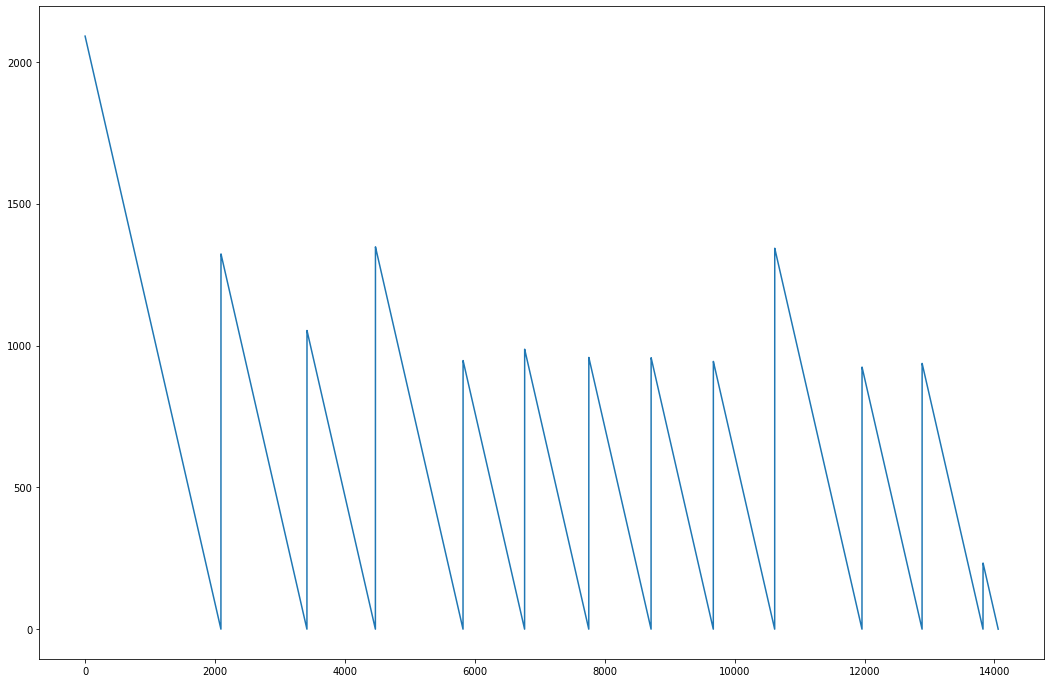

In [30]:
plt.plot(df["label"])
plt.show()

## Data trends visualization

We will now plot some features (possibly zoomed), the positions, and the anomalies over the time axis.

Pay attention to how the mean and differencing methods helps to denoise the input signal and to enlight the unusual behaviours.

In [31]:
def plot_all_signal(df, feature):
    plt.plot(df[feature], alpha=0.6)
    plt.plot(df["POSy"])
    ranges = (df["label"] == 0).map({True:0, False:30})
    plt.scatter(range(len(df)), ranges, color="red", s=20)
    plt.ylim(-9,5)
    plt.legend([feature, "POSy", 'Anomalies'], loc='upper right')
    plt.show()

In [32]:
def plot_all_signal_zoomed(df, feature):
    for i in range(0, len(df) - 1000, 1000):
        start = i
        end = i + 1000
        plt.plot(df[feature][start:end], alpha=0.6)
        plt.plot(df["POSy"][start:end])
        ranges = (df["label"] == 0).map({True:0, False:30})
        plt.scatter(range(start, end), ranges[start:end], color="red", s=20)
        plt.ylim(-9,5)
        plt.legend([feature, "POSy", 'Anomalies'], loc='upper right')
        plt.show()

In [33]:
def plot_only_faults(df, feature):
    for i, is_fault in enumerate((df["label"] == 0).tolist()):
        if is_fault:
            start = i - 20
            end = i + 1
            plt.plot(df[feature][start:end], alpha=0.6)
            plt.plot(df["POSy"][start:end])
            ranges = (df["label"] == 0).map({True:0, False:30})
            plt.scatter(range(start, end), ranges[start:end], color="red", s=20)
            plt.ylim(-9,5)
            plt.legend([feature, "POSy", 'Anomalies'], loc='upper right')
            plt.show()

#### Ax: raw values

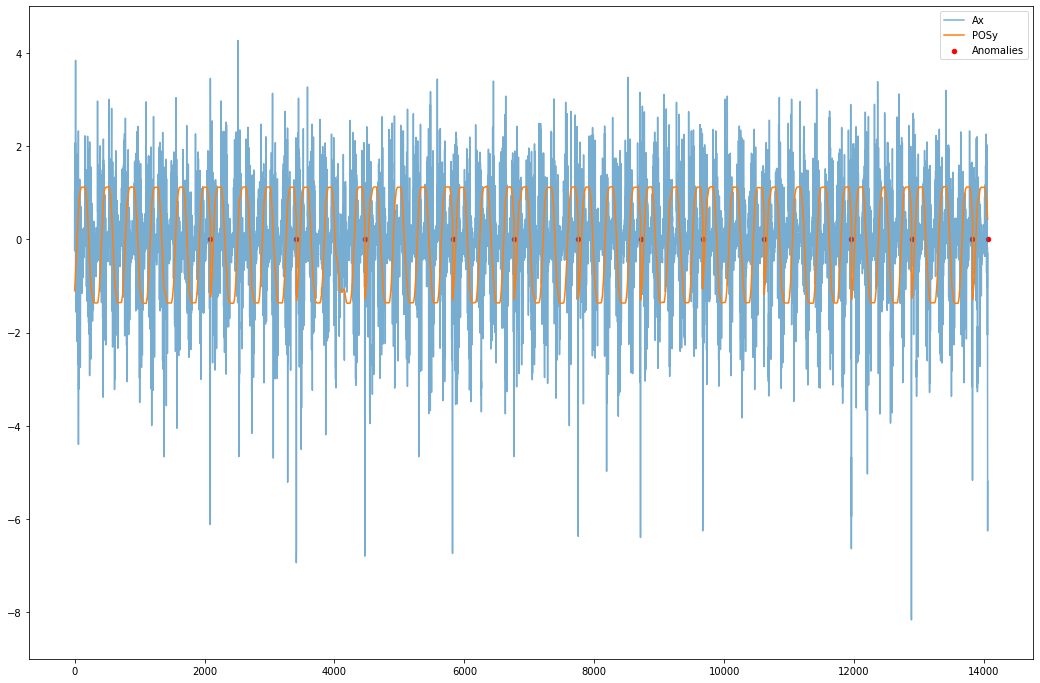

In [34]:
plot_all_signal(df, "Ax")

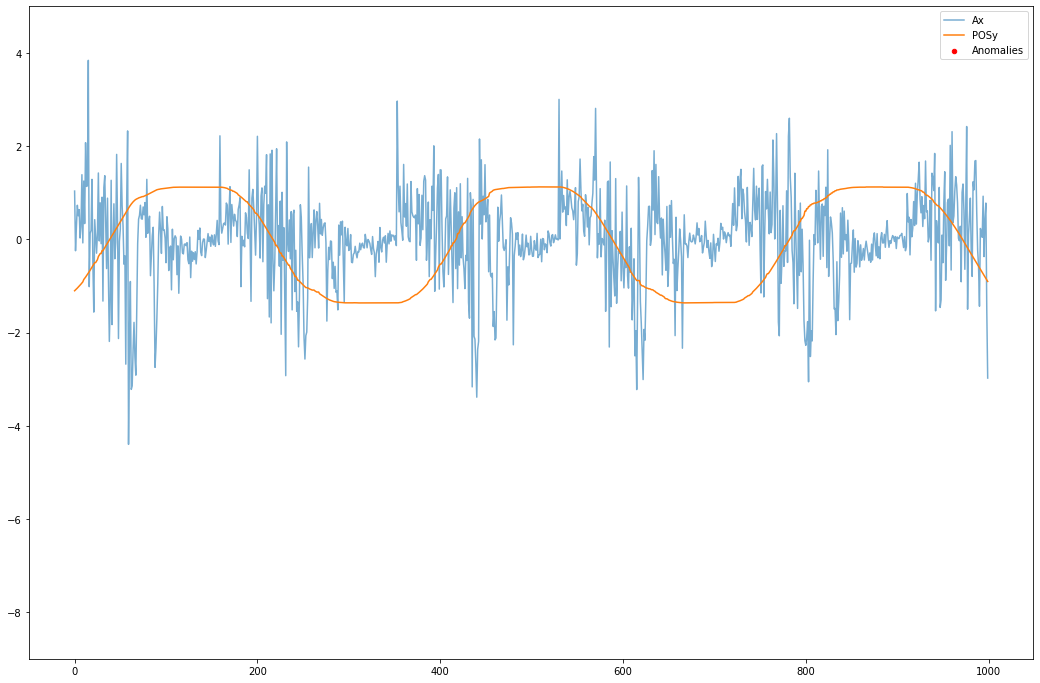

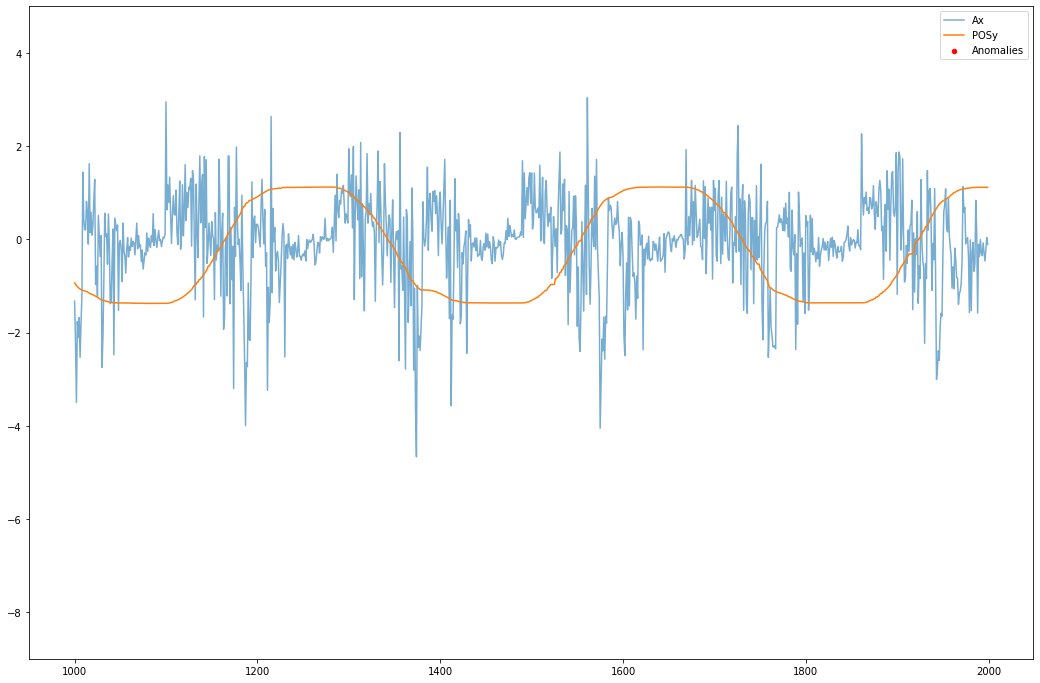

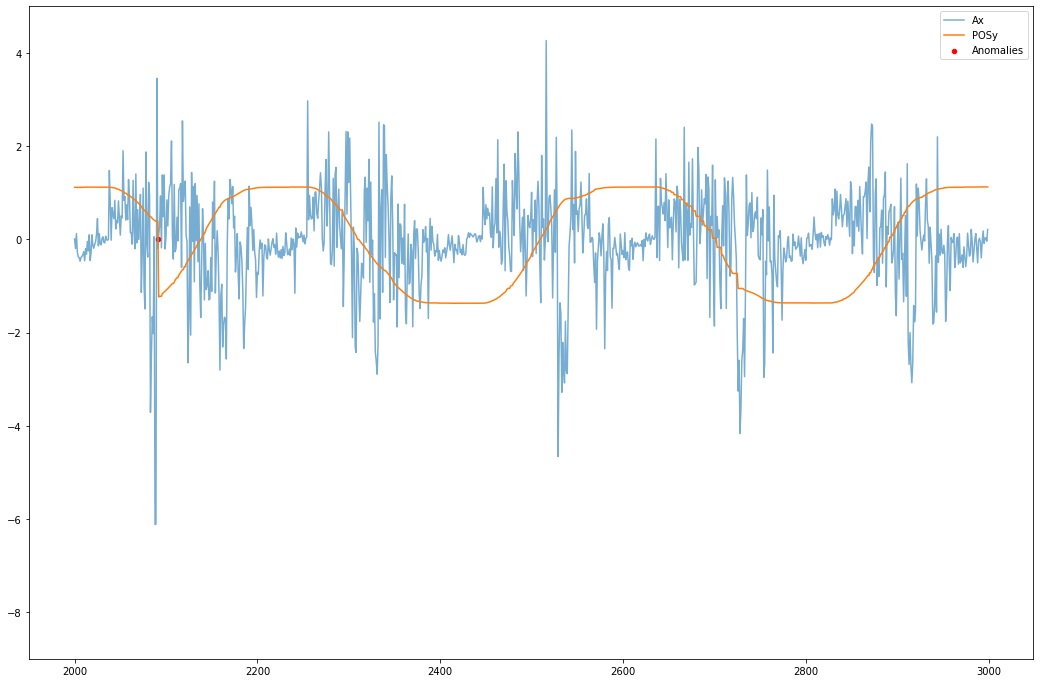

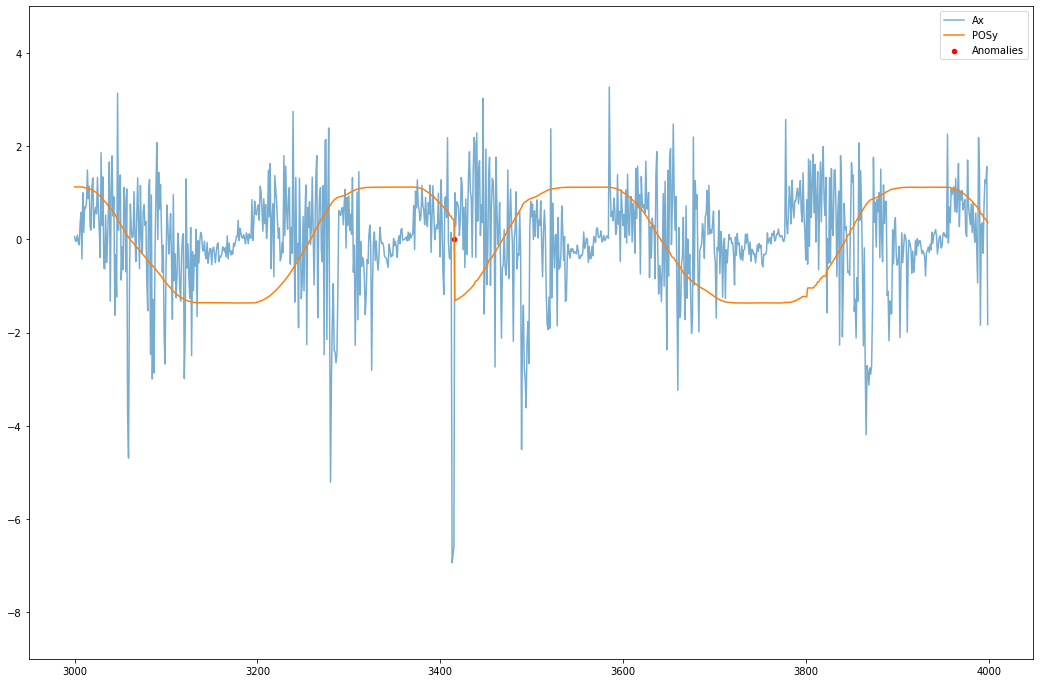

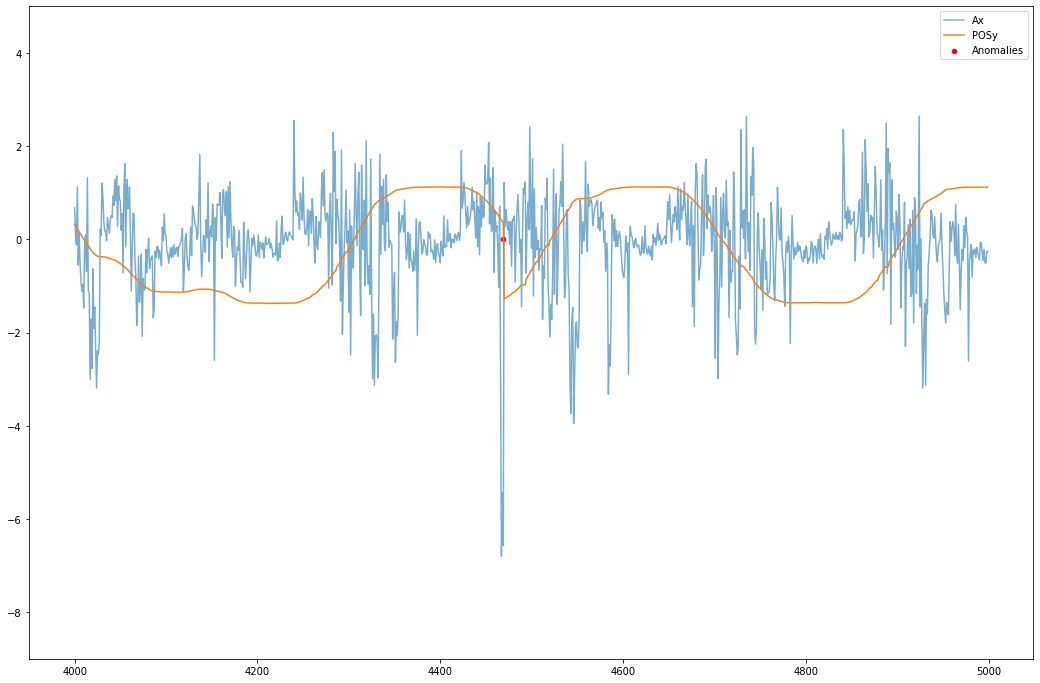

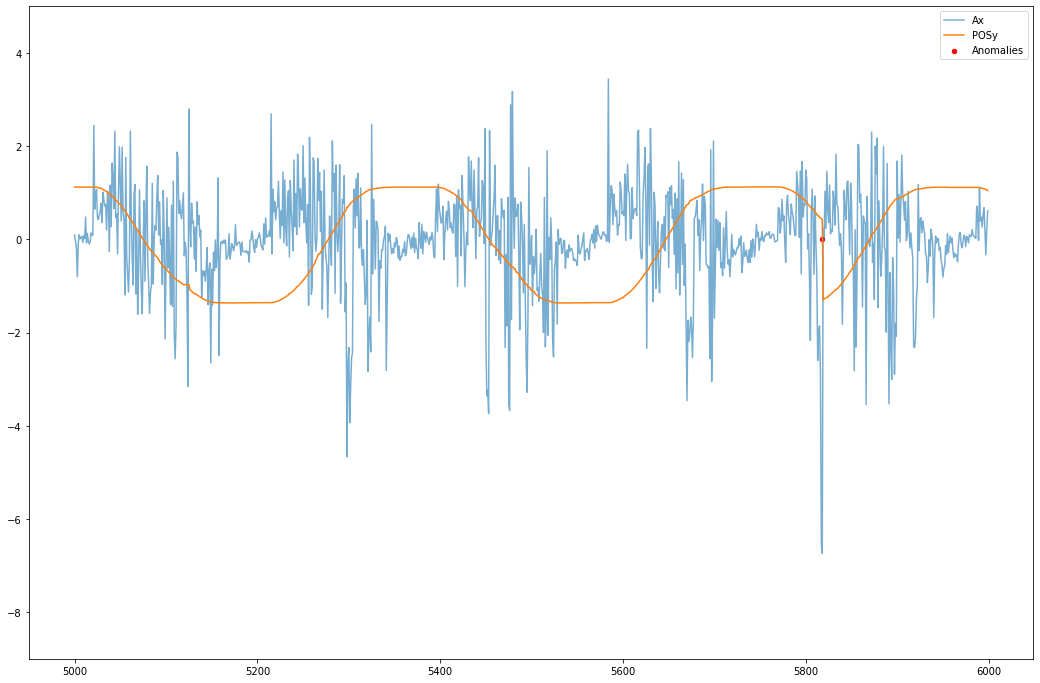

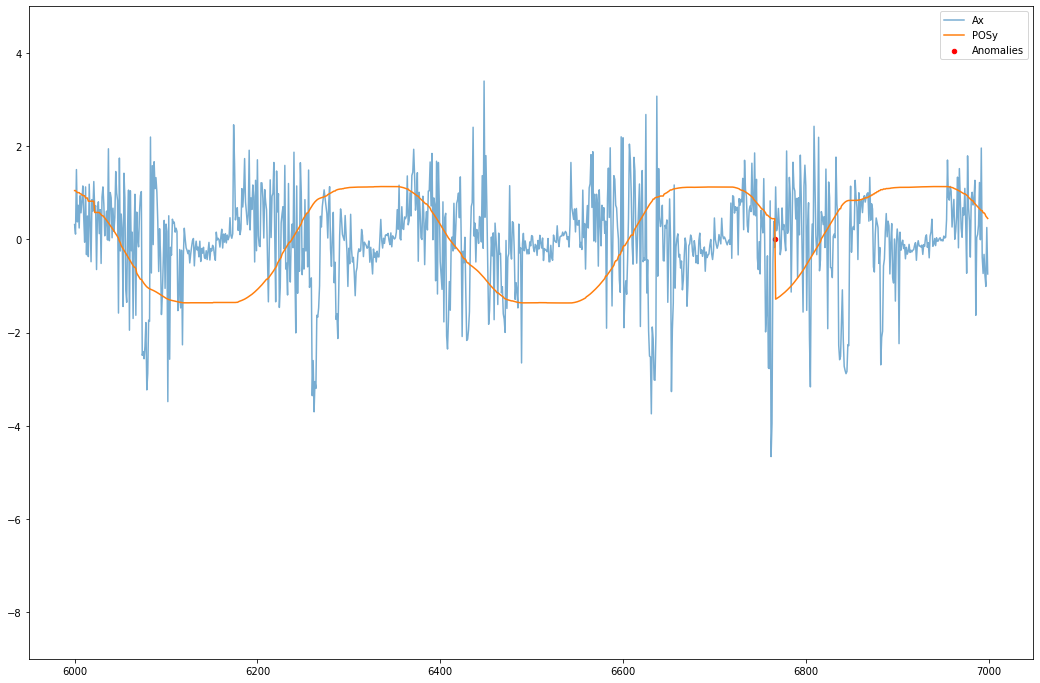

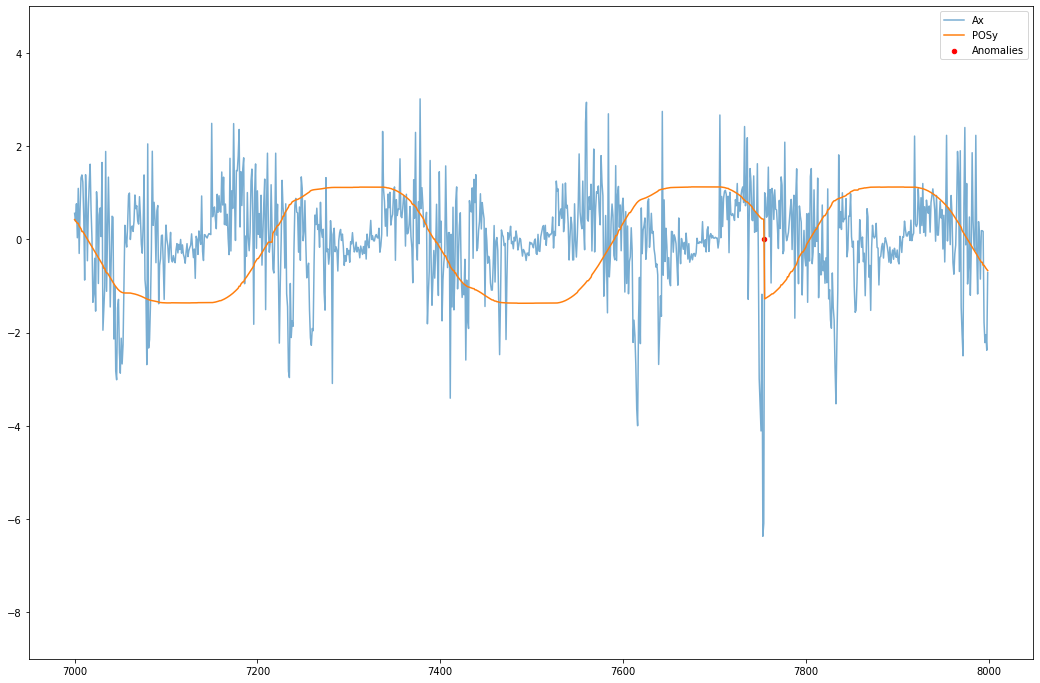

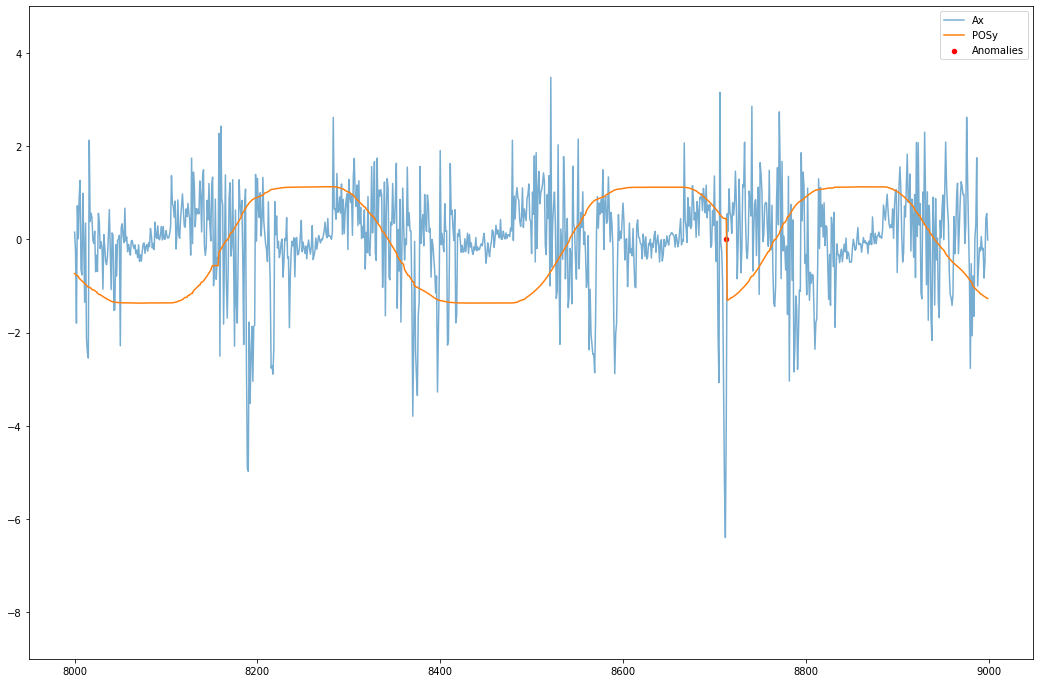

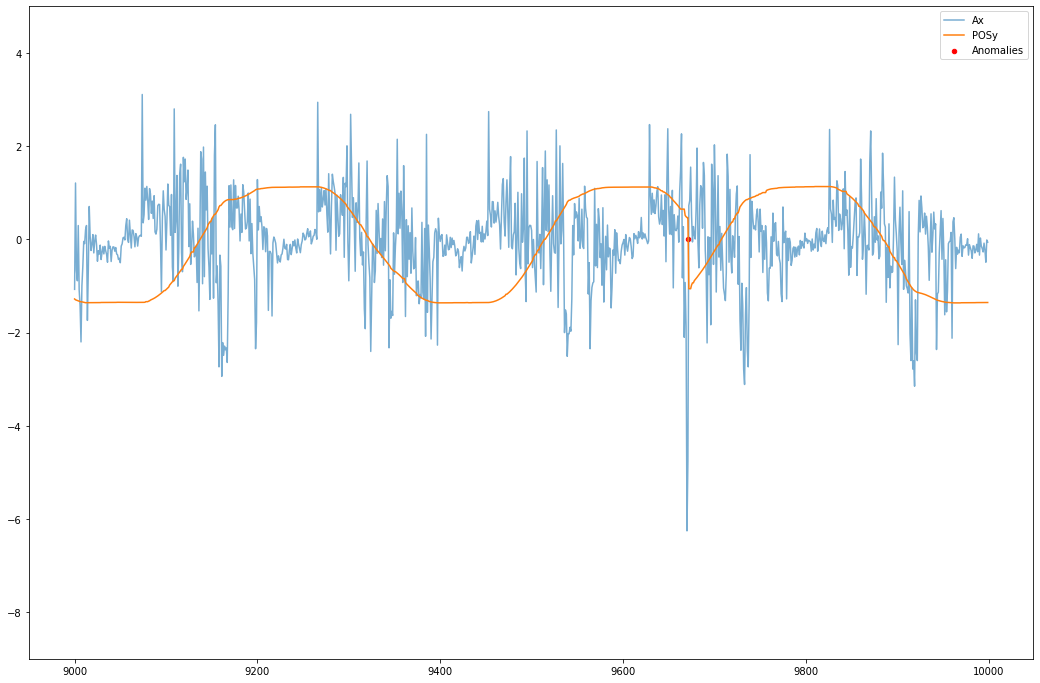

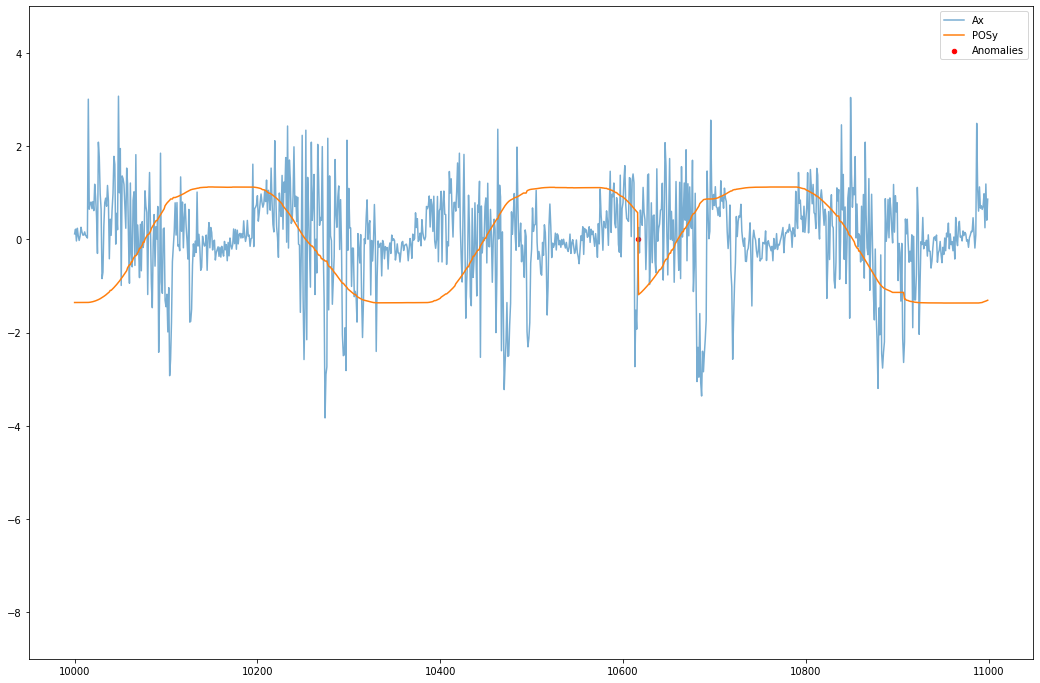

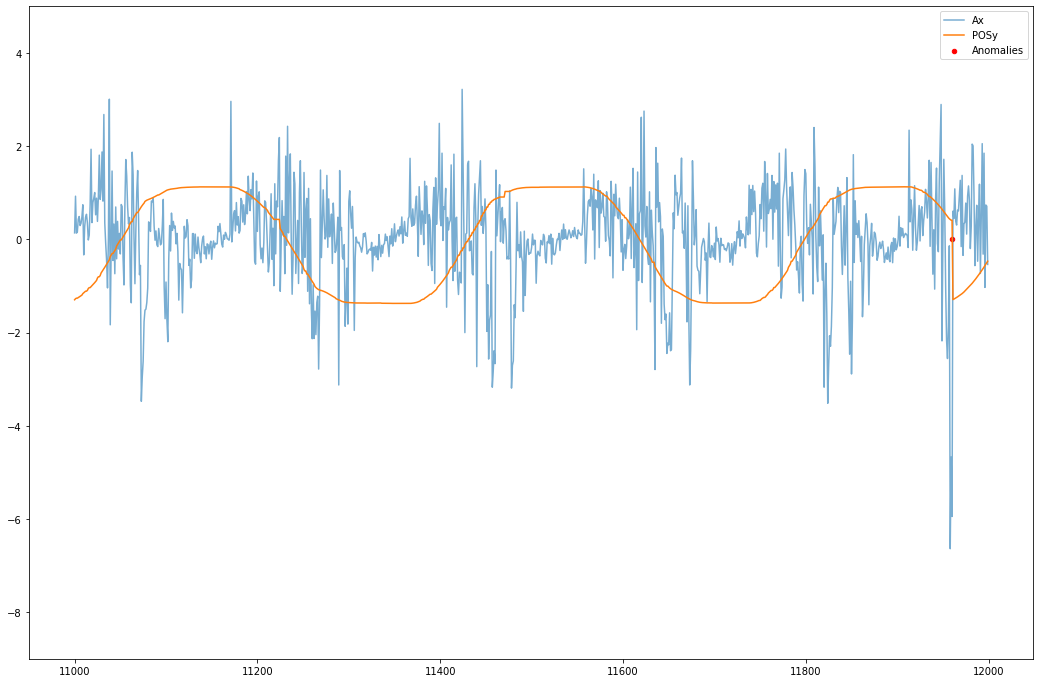

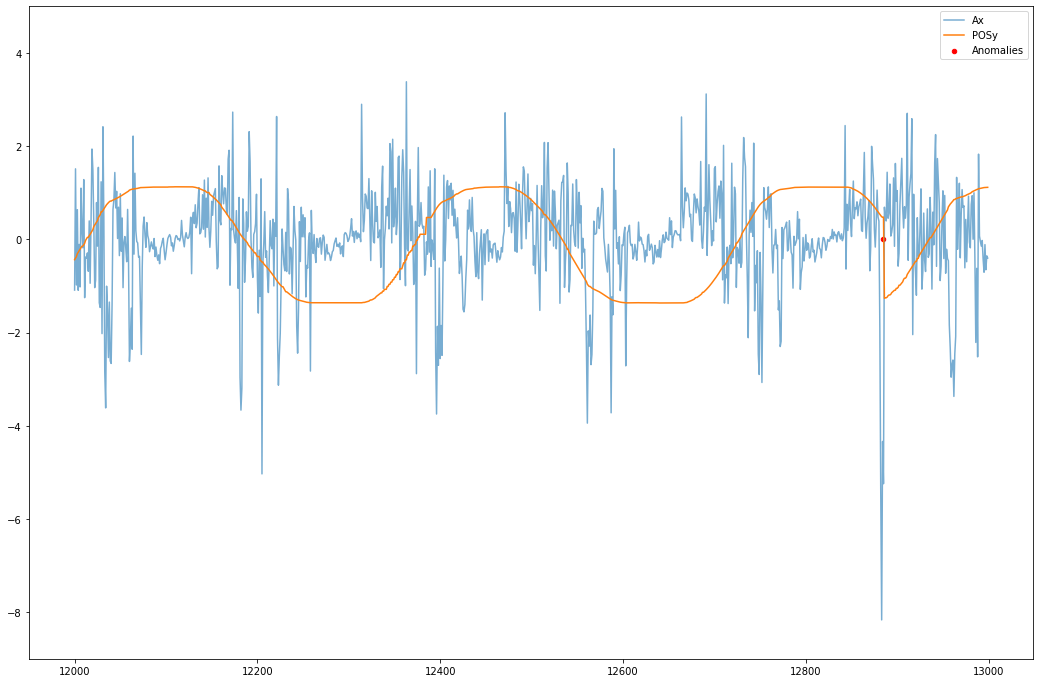

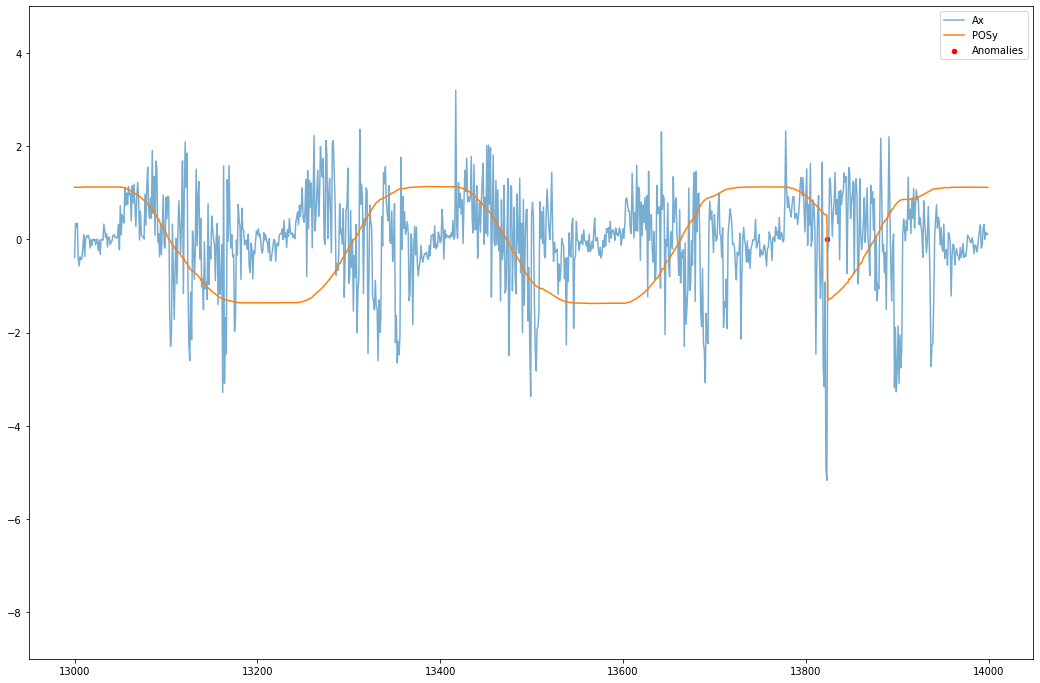

In [35]:
plot_all_signal_zoomed(df, "Ax")

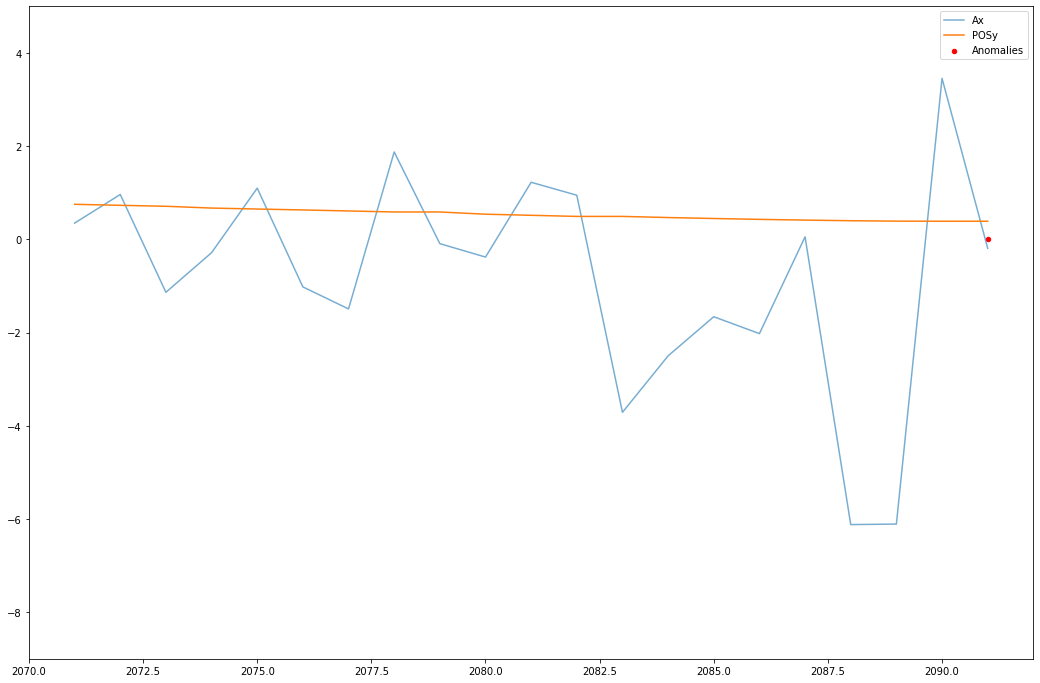

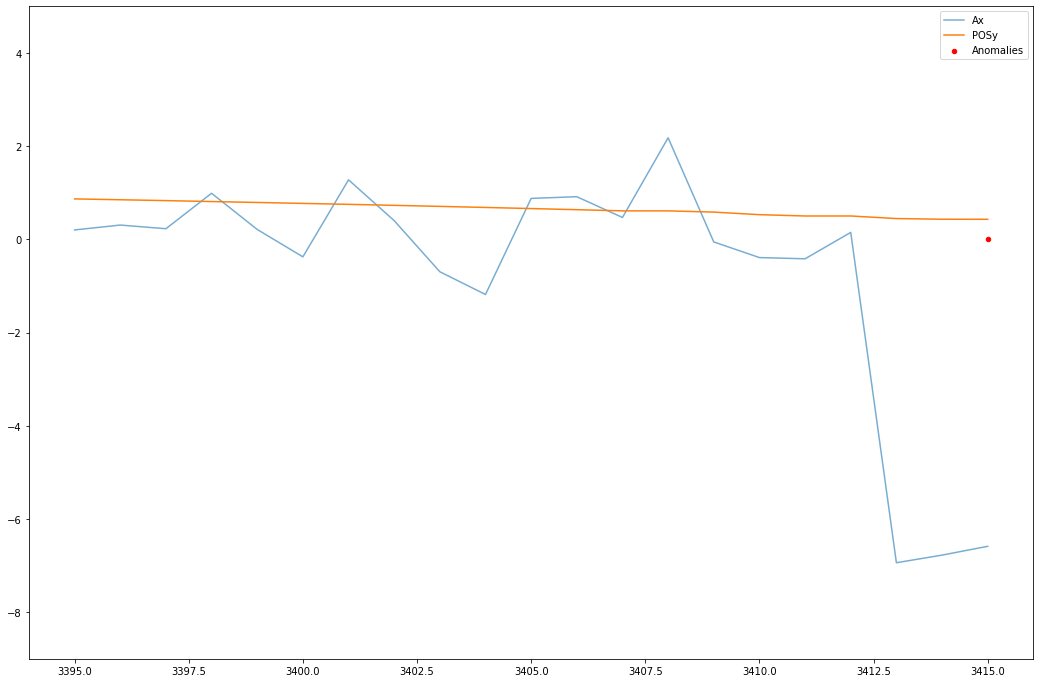

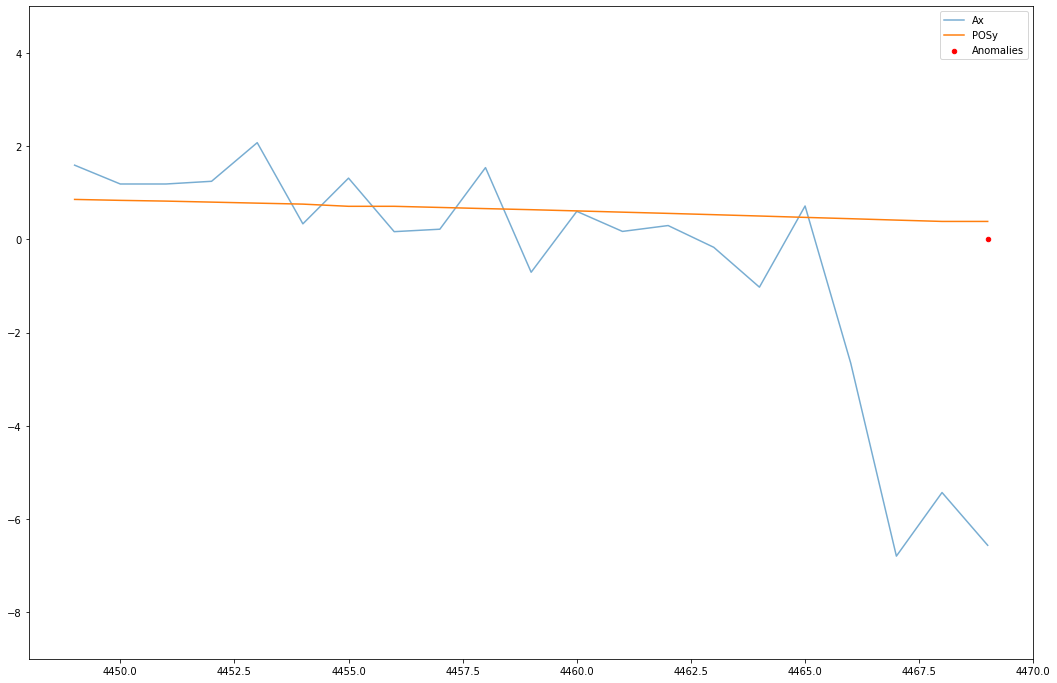

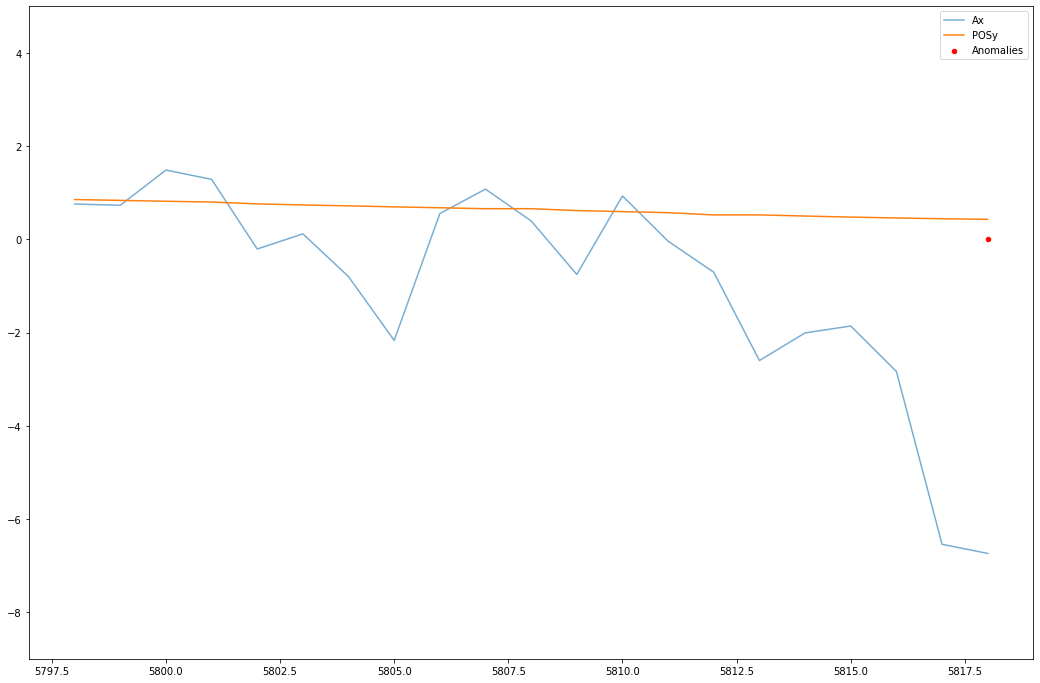

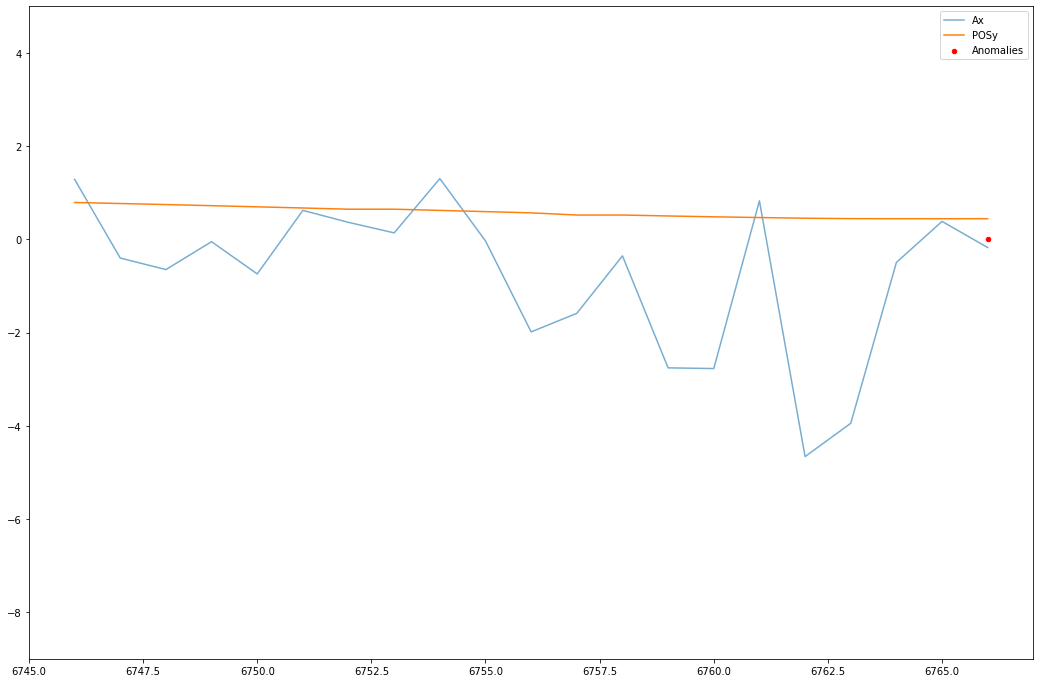

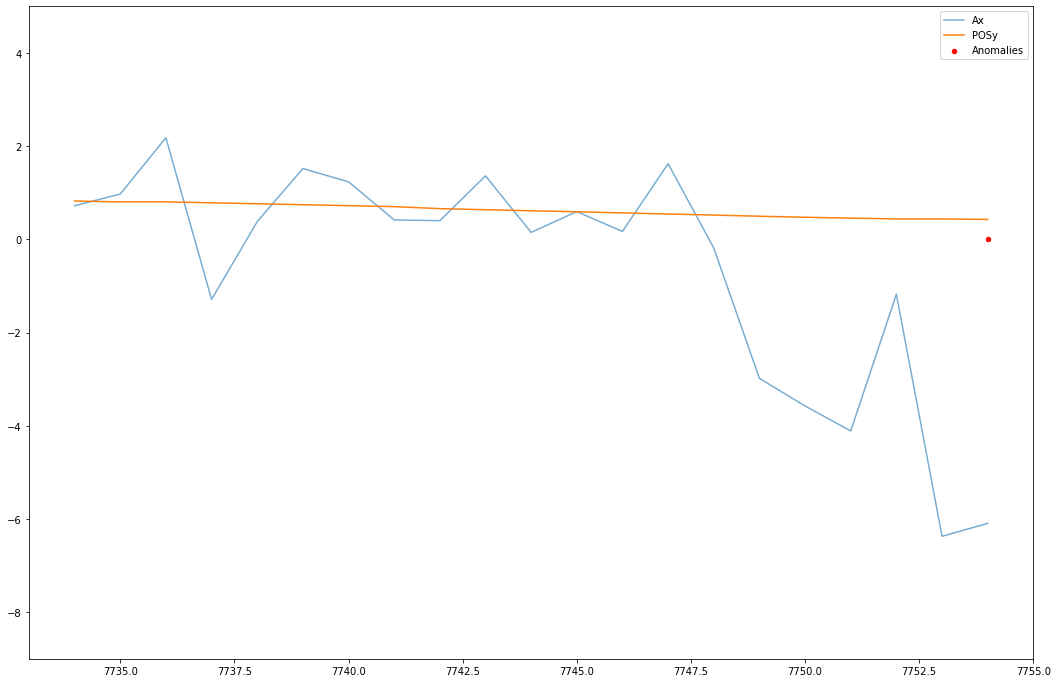

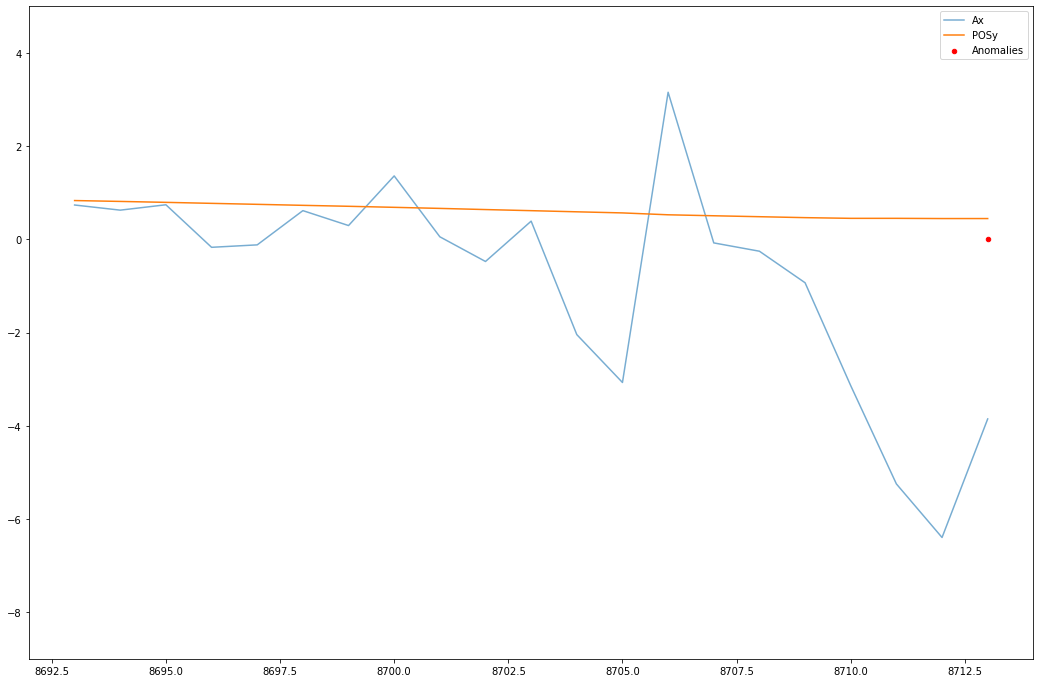

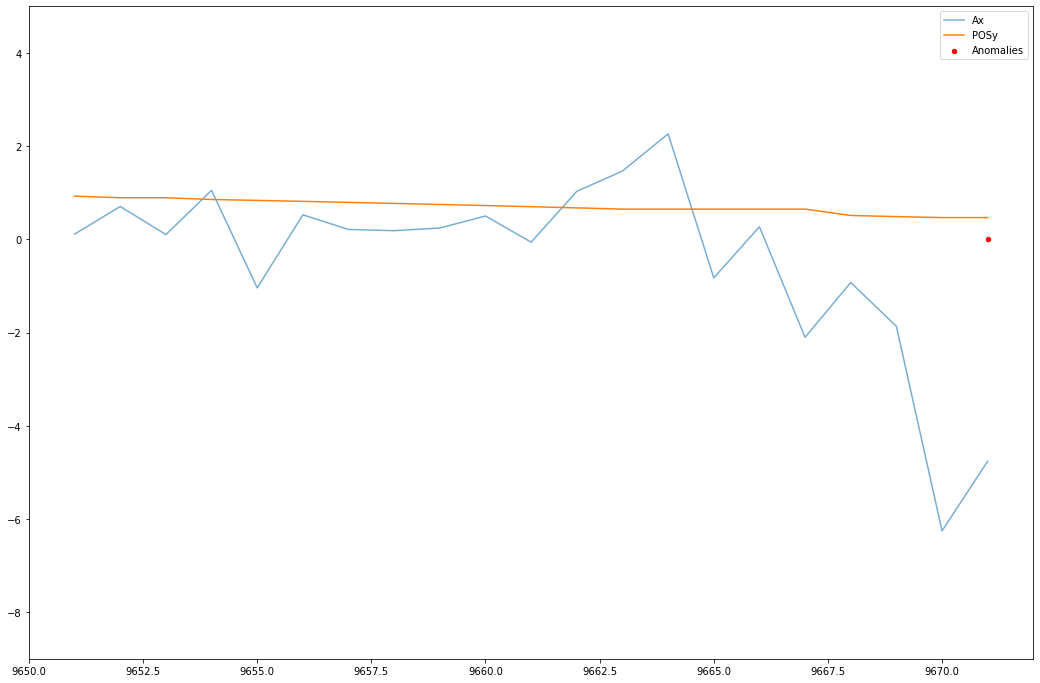

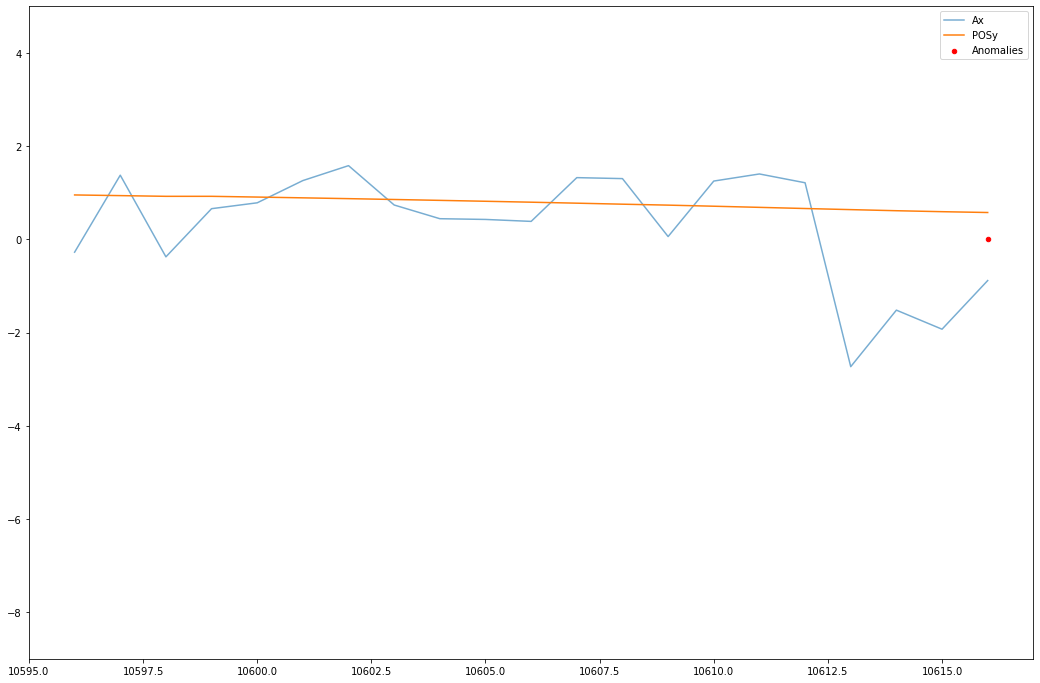

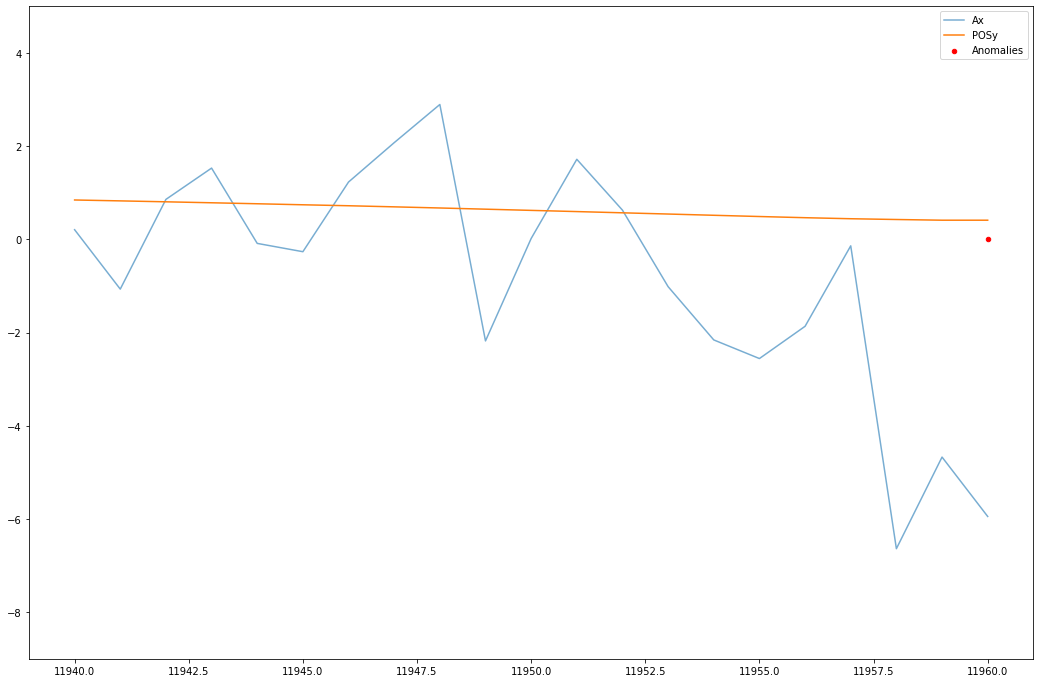

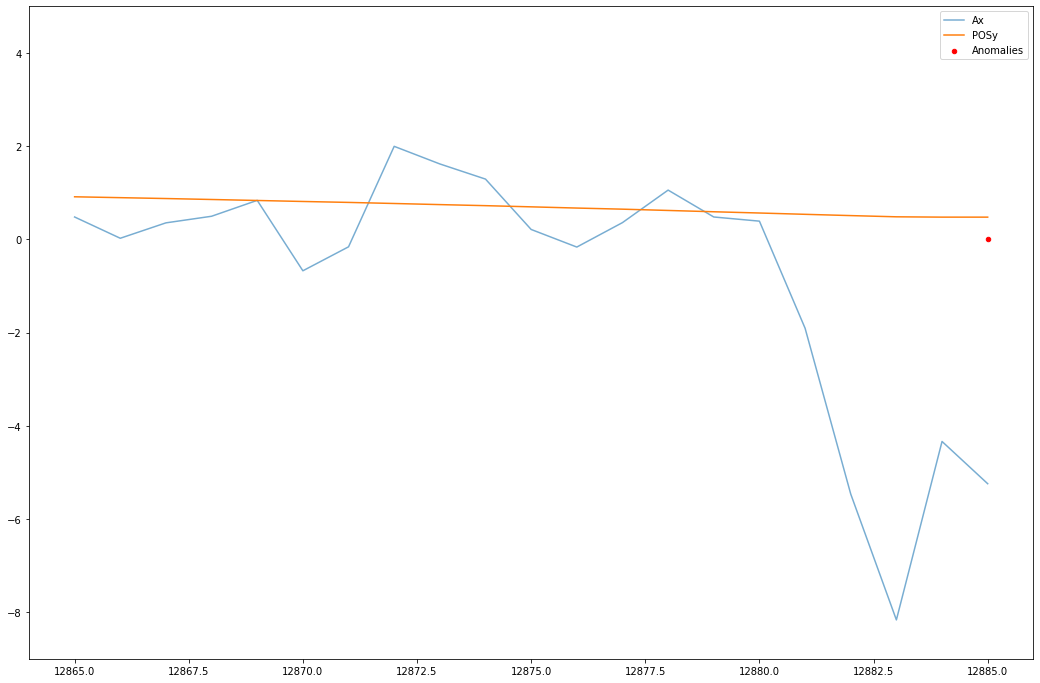

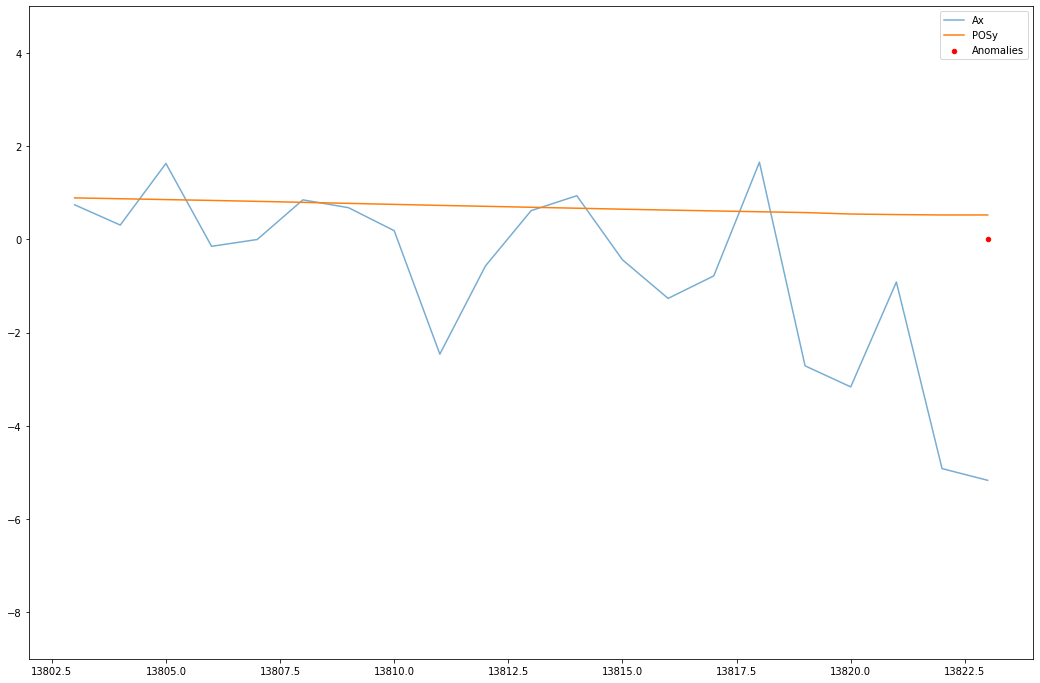

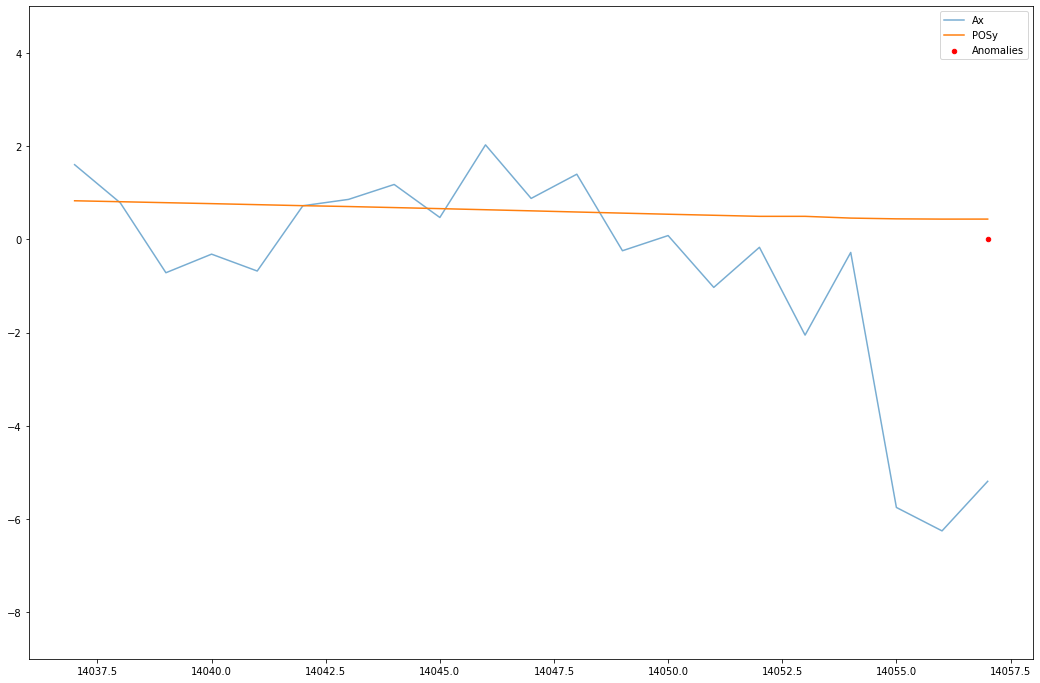

In [36]:
plot_only_faults(df, "Ax")

#### Ax: mean values

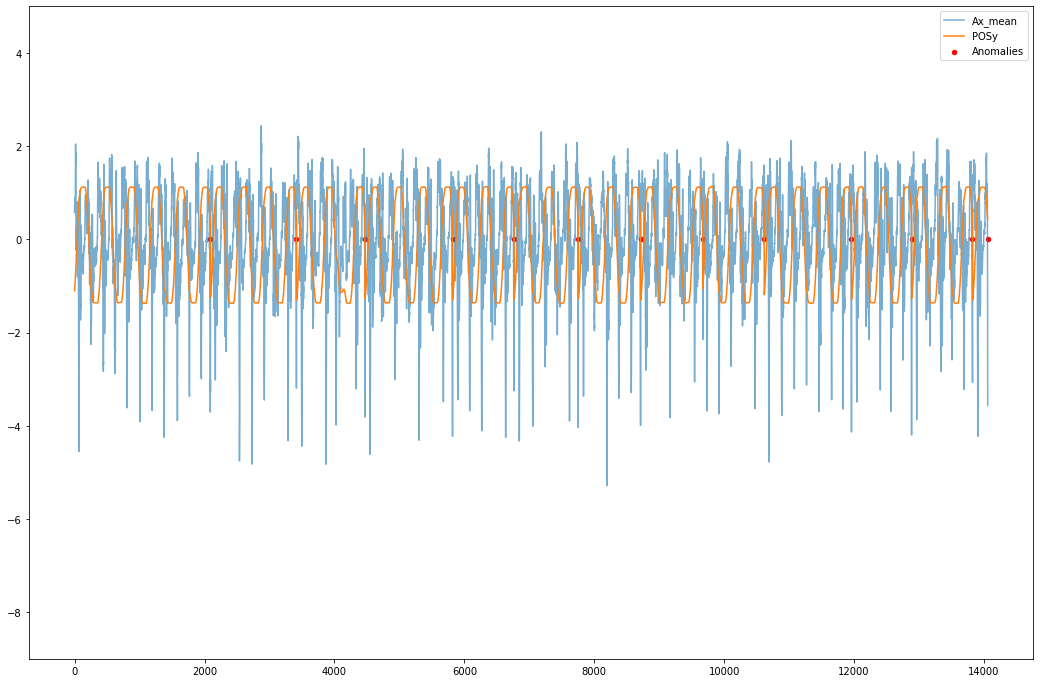

In [37]:
plot_all_signal(df, "Ax_mean")

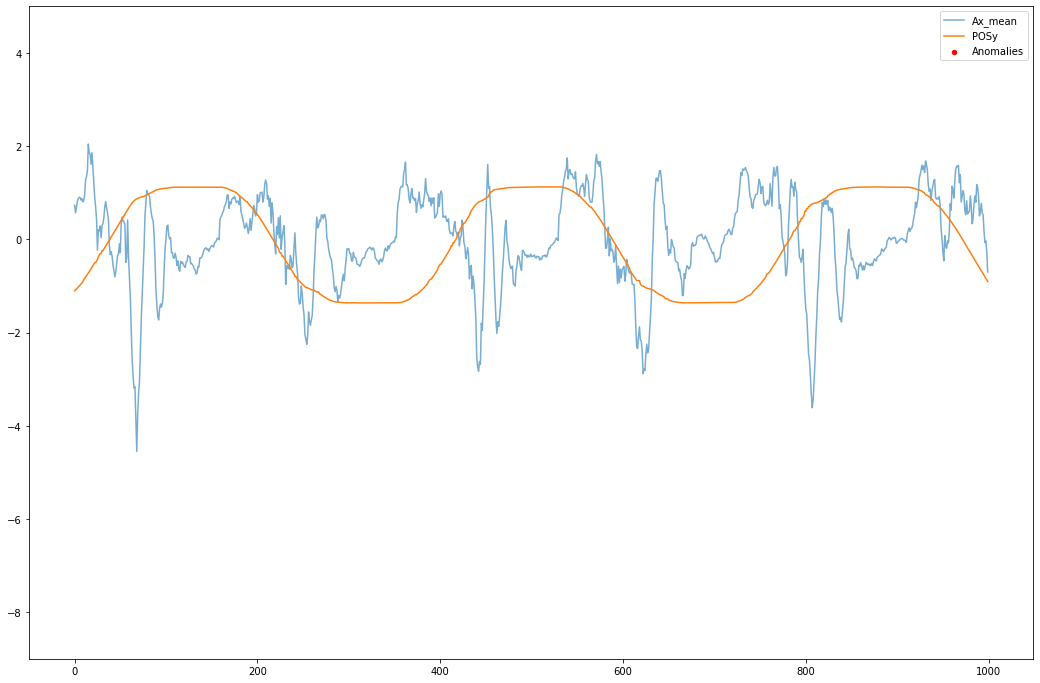

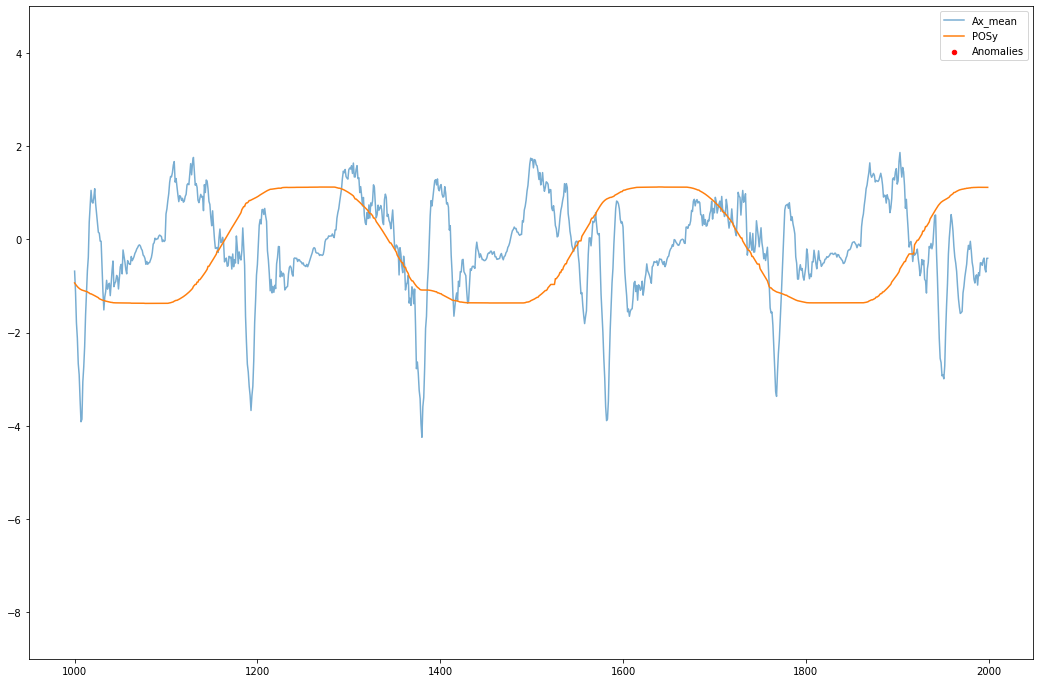

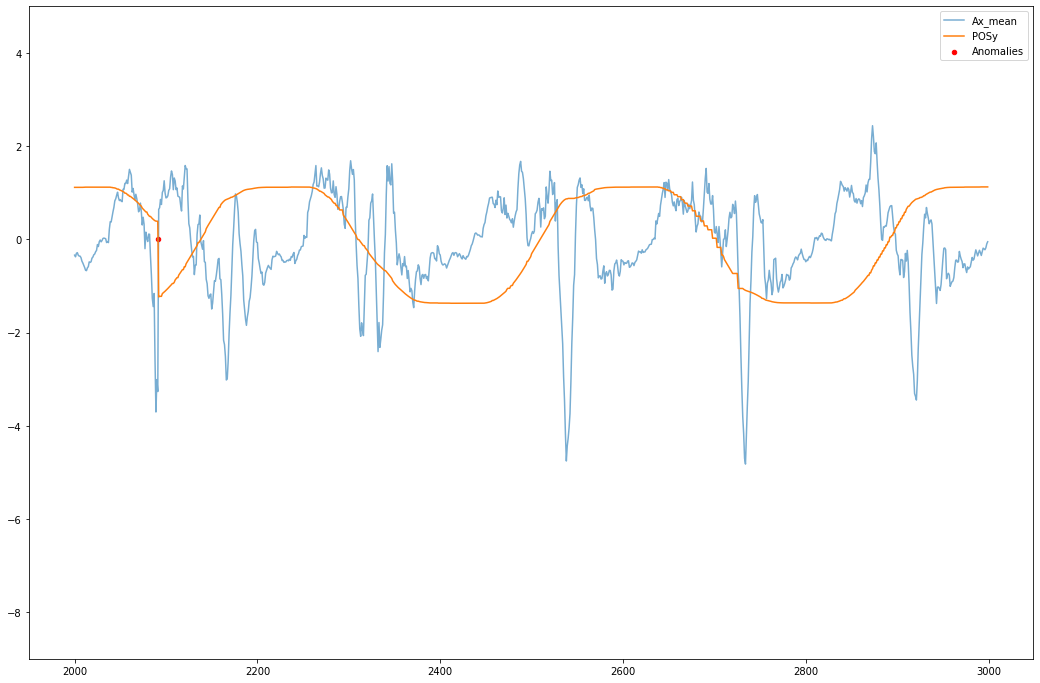

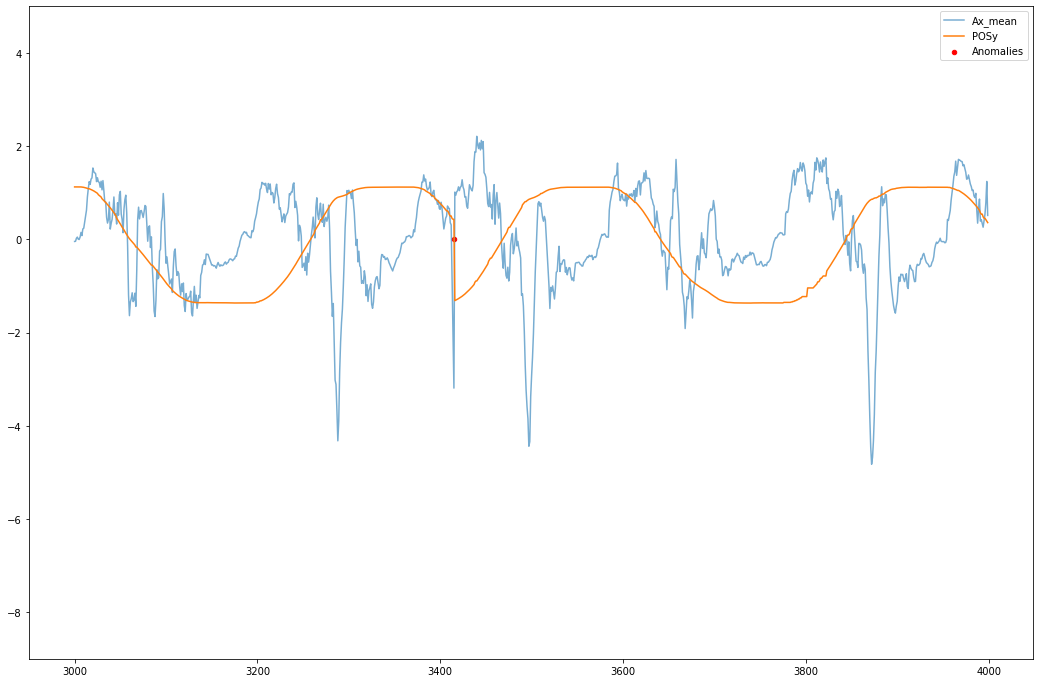

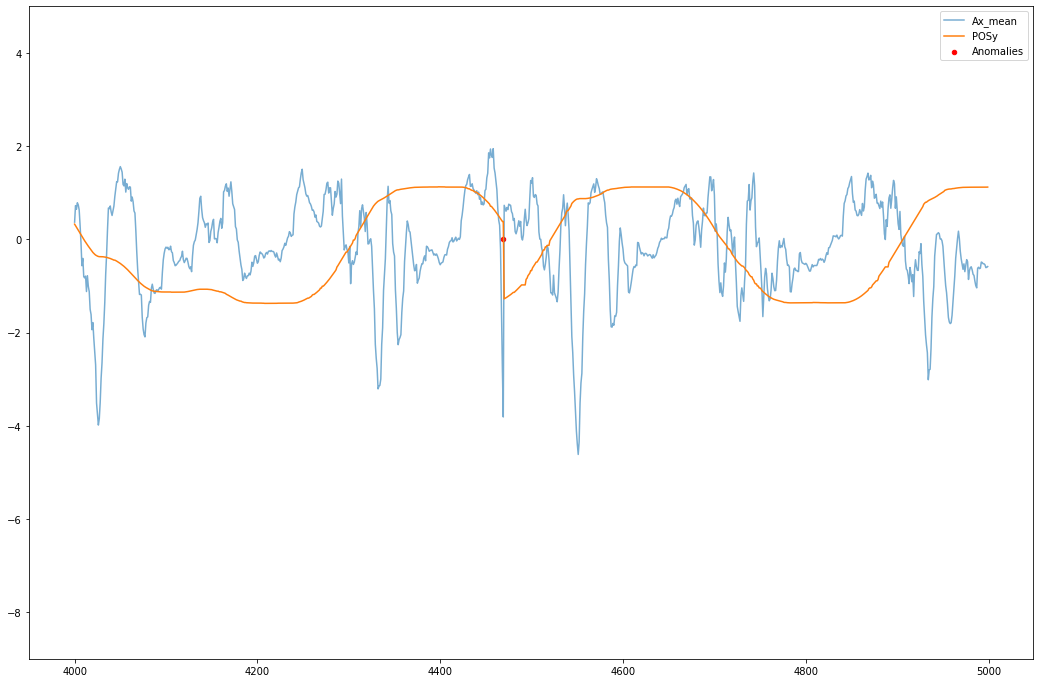

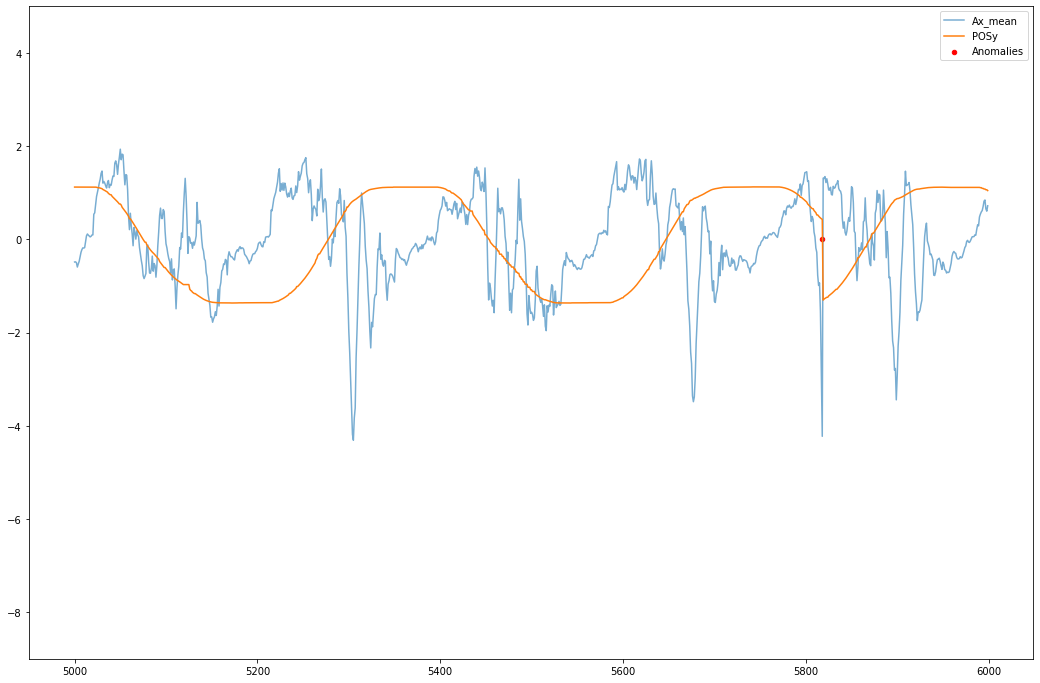

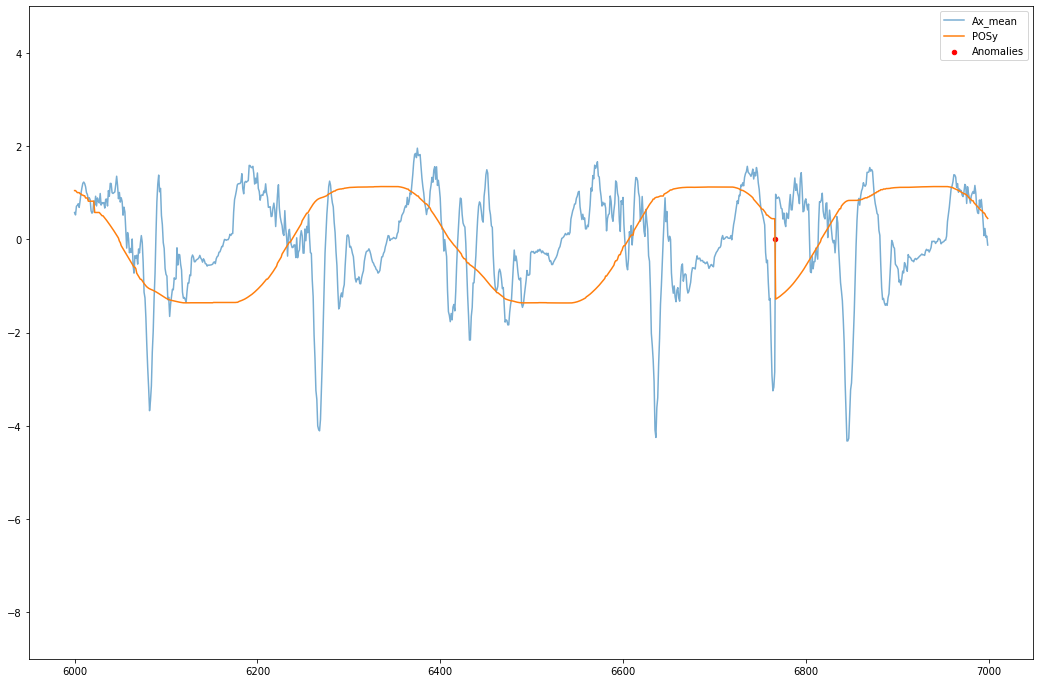

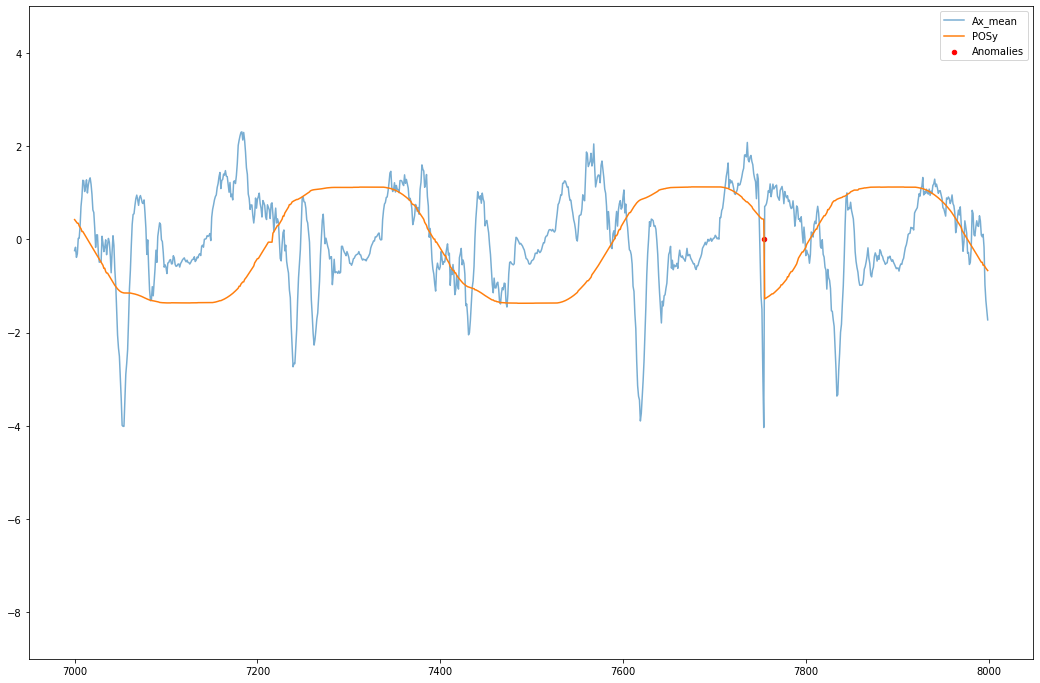

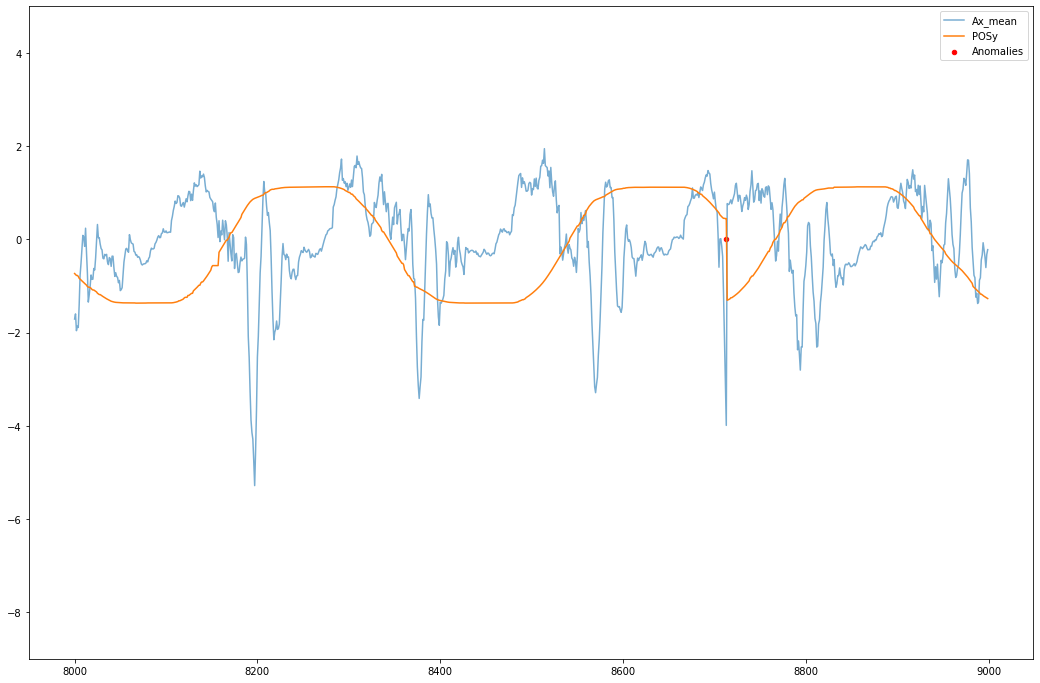

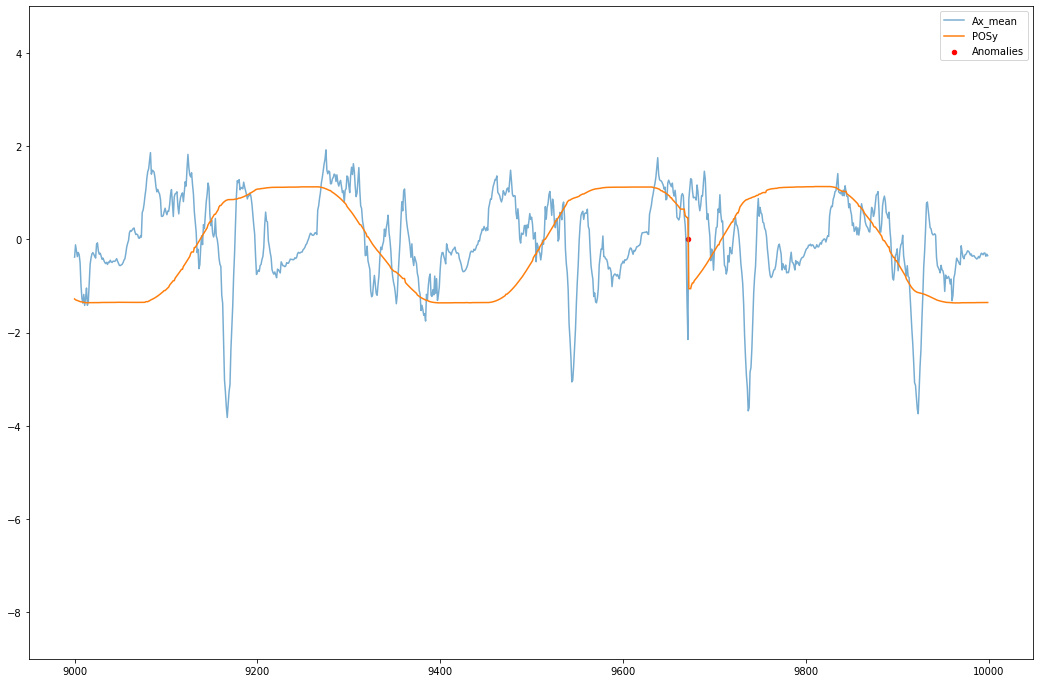

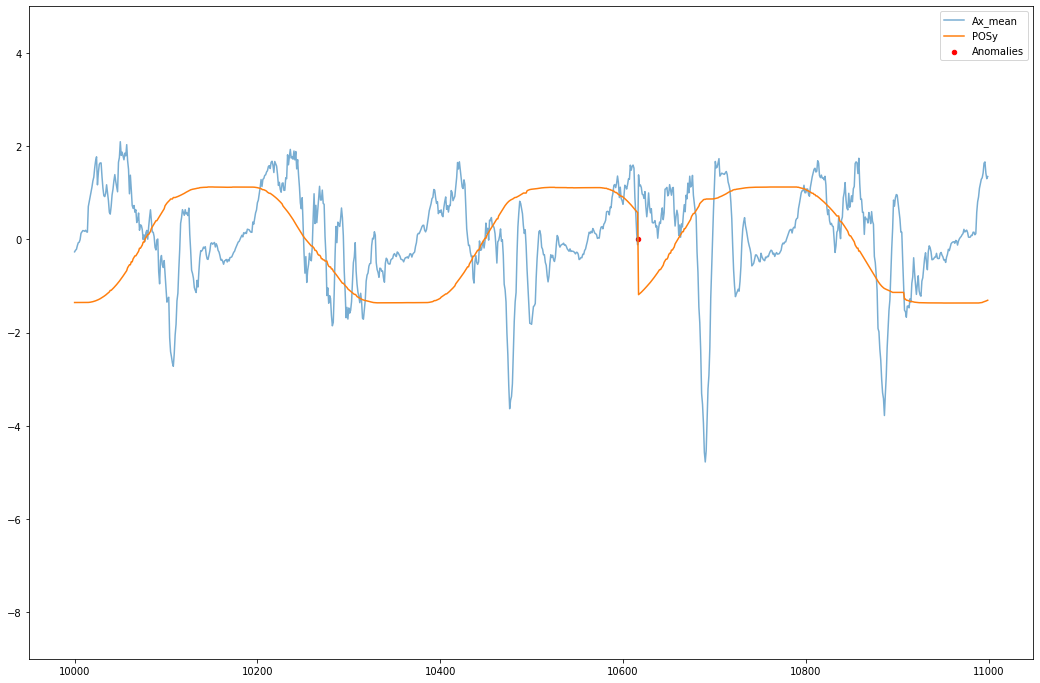

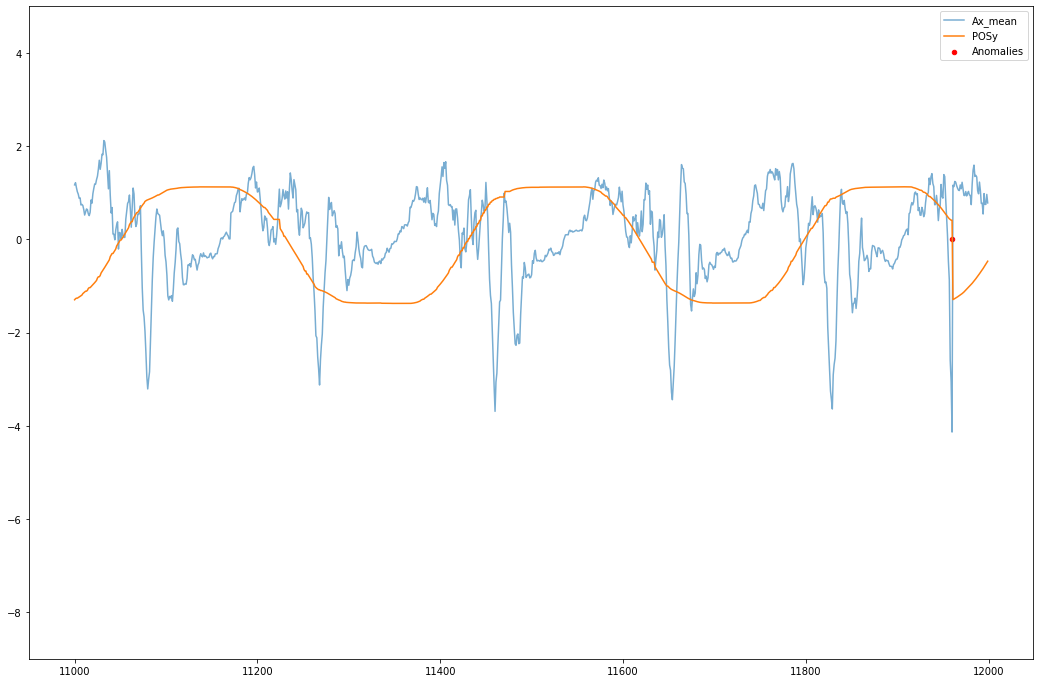

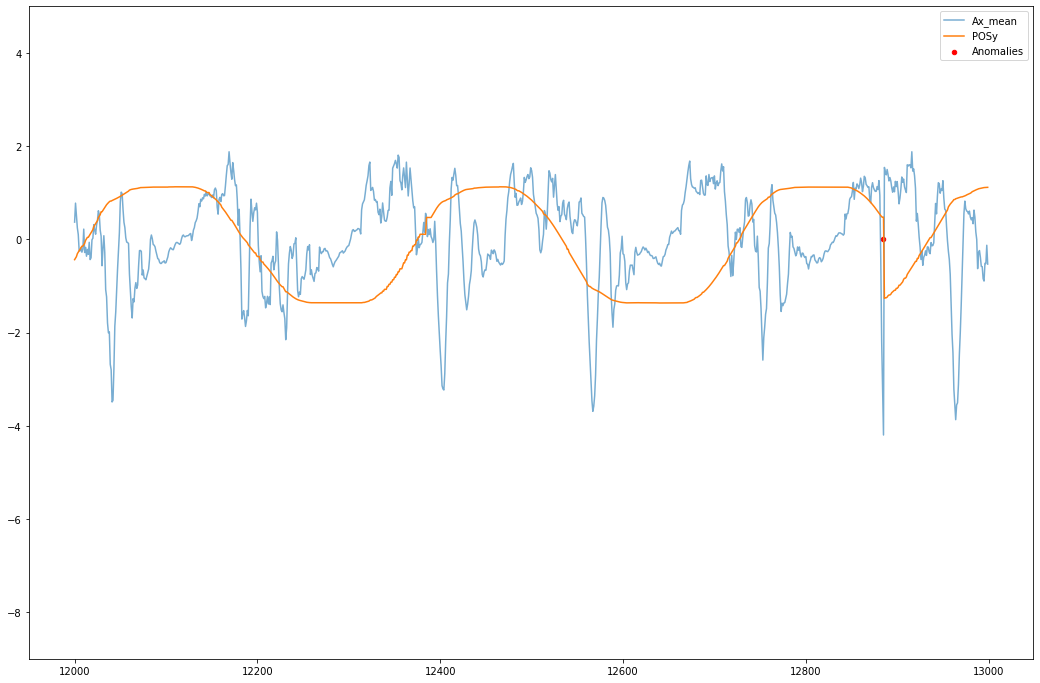

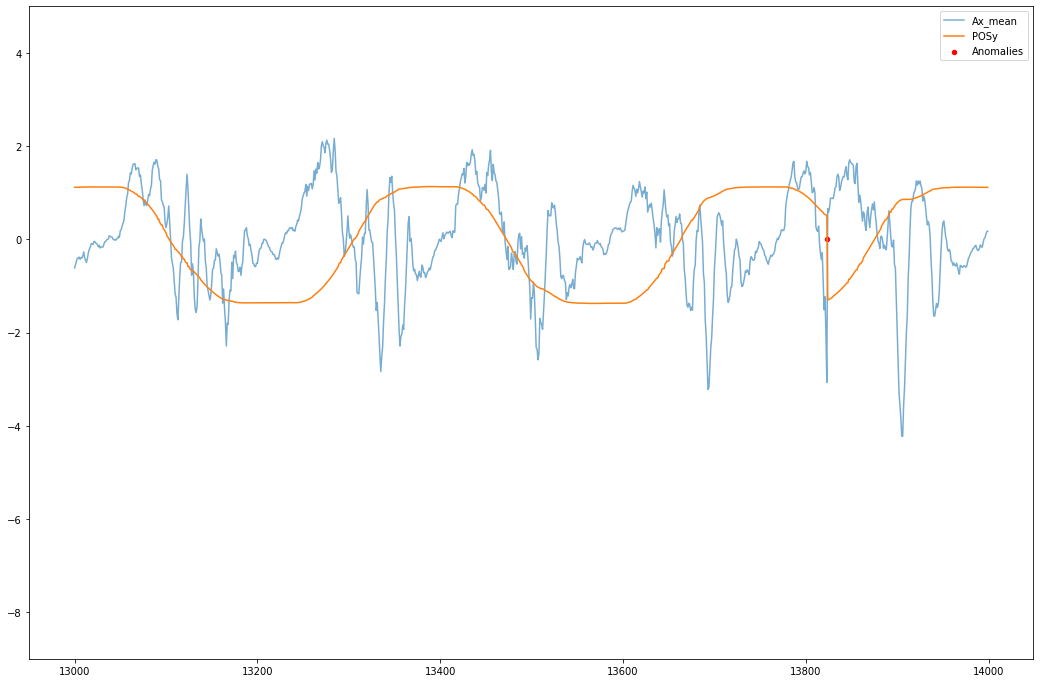

In [38]:
plot_all_signal_zoomed(df, "Ax_mean")

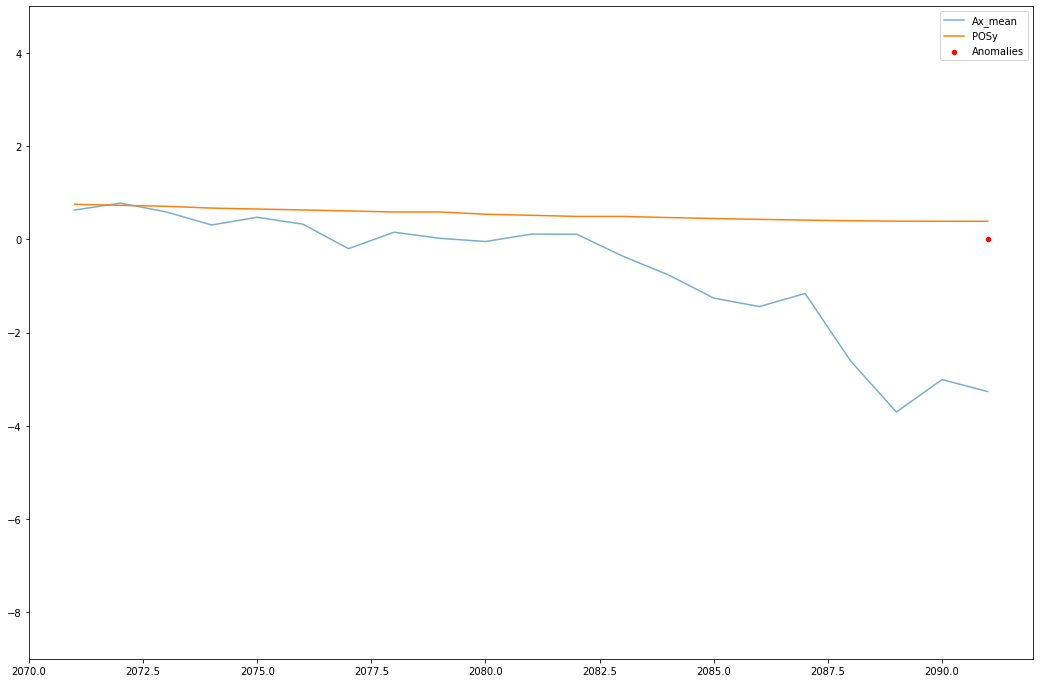

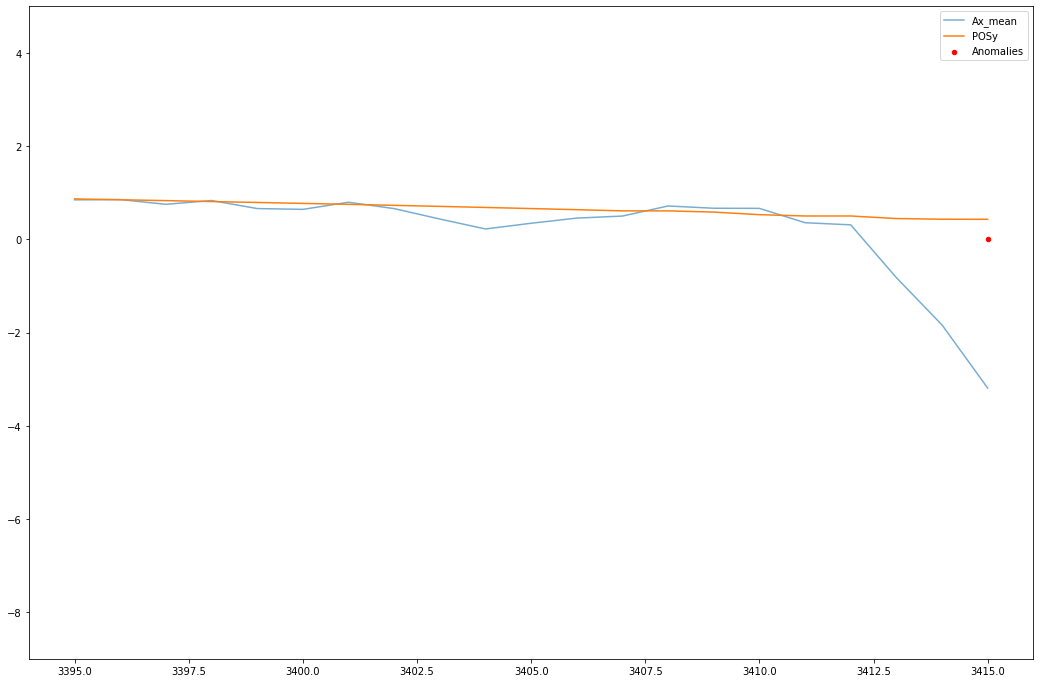

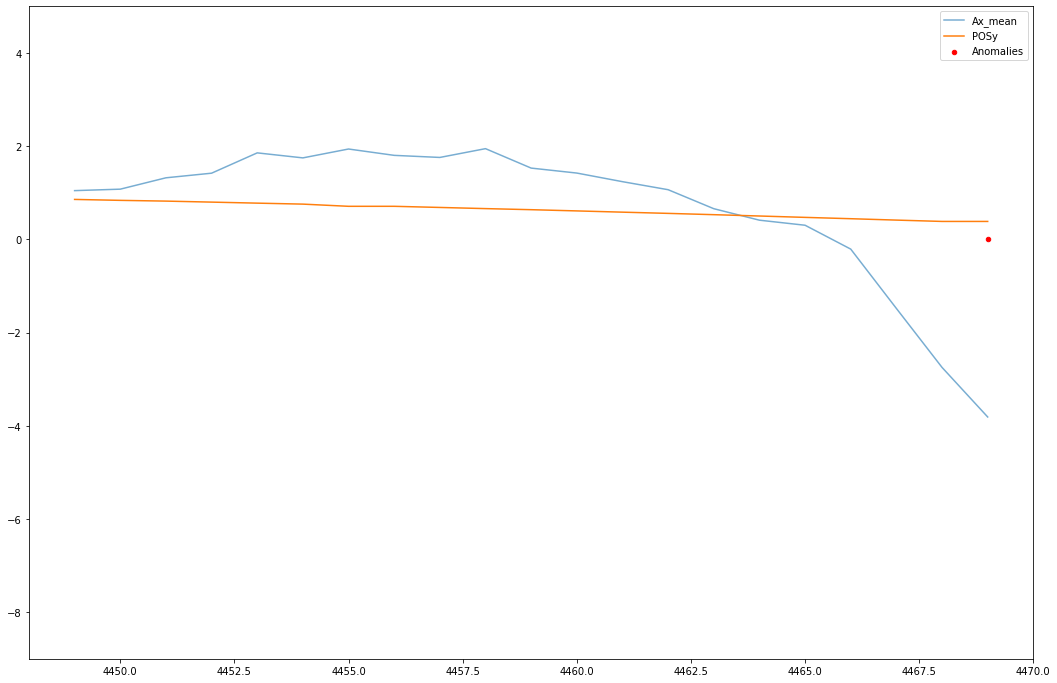

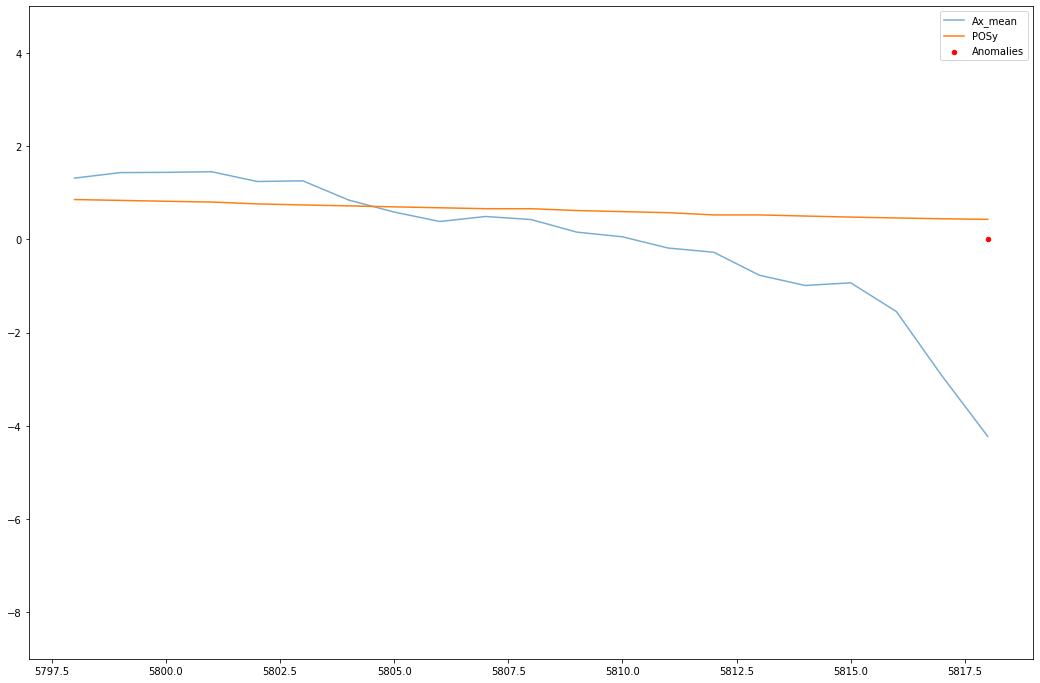

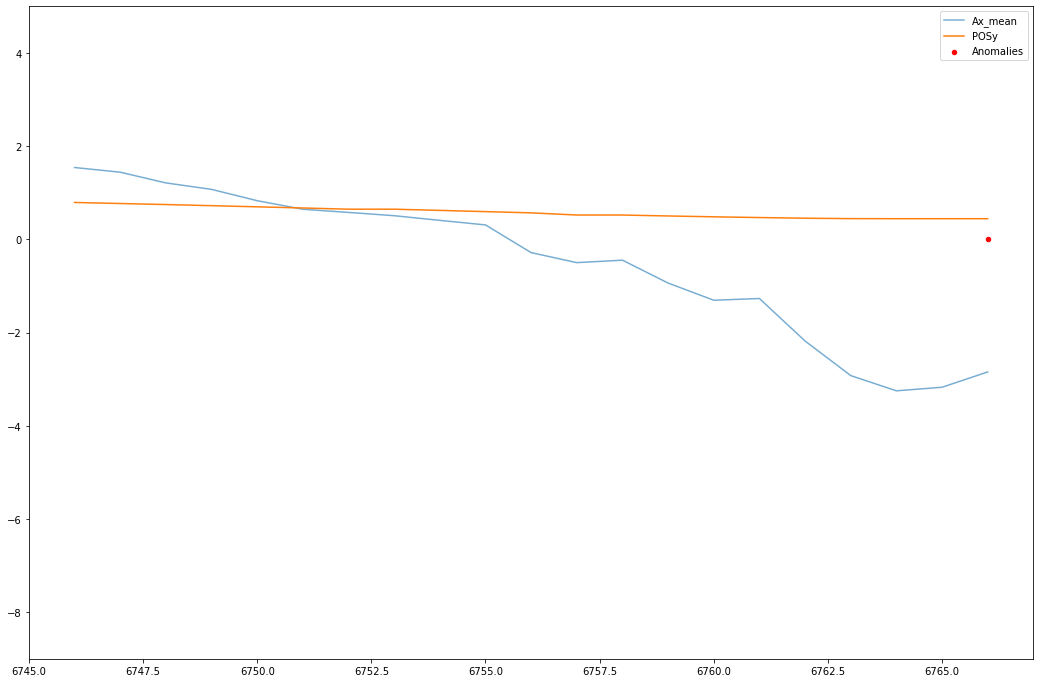

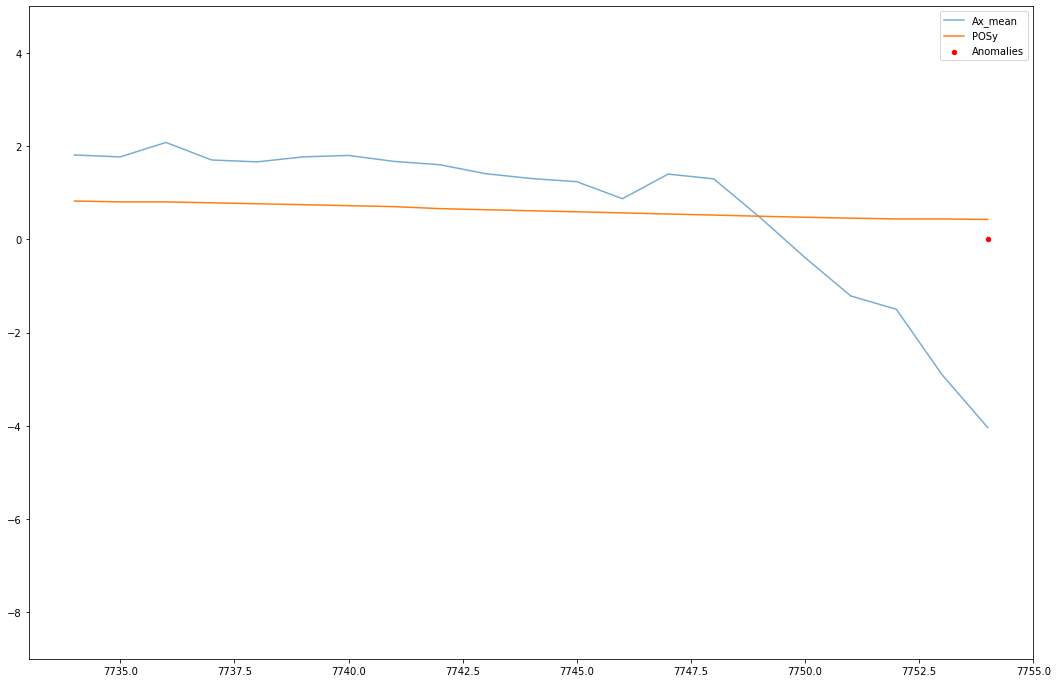

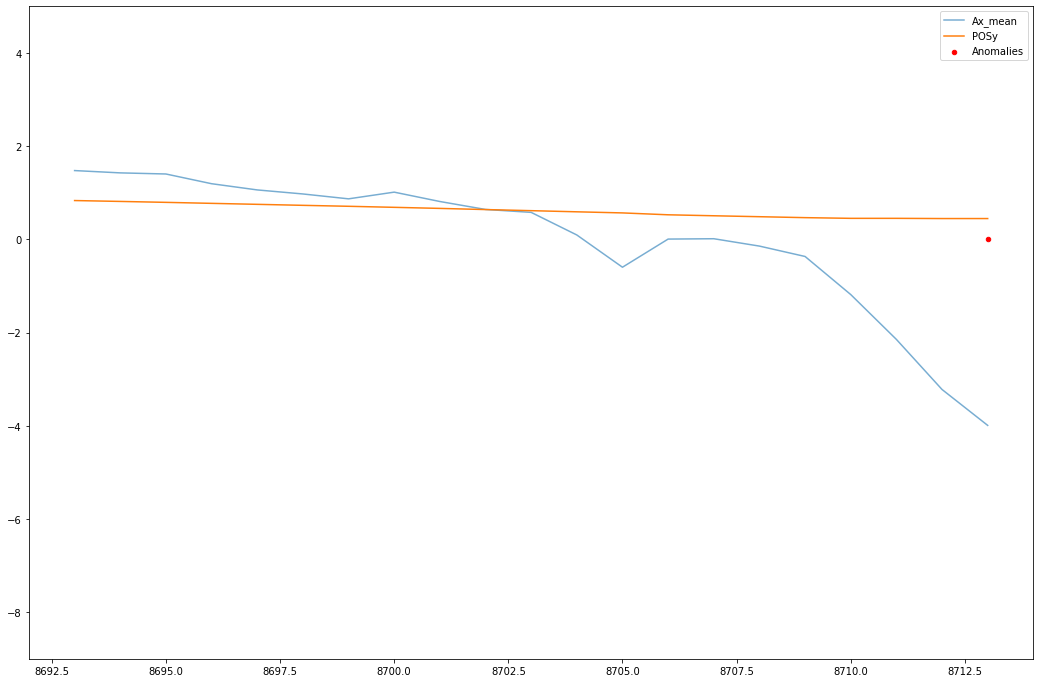

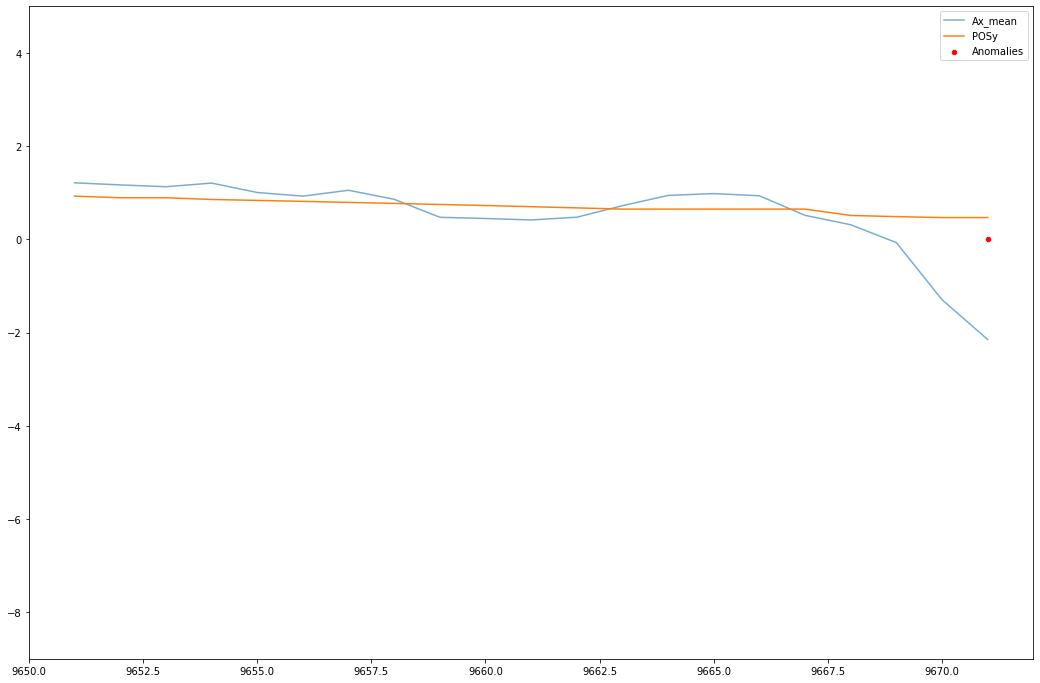

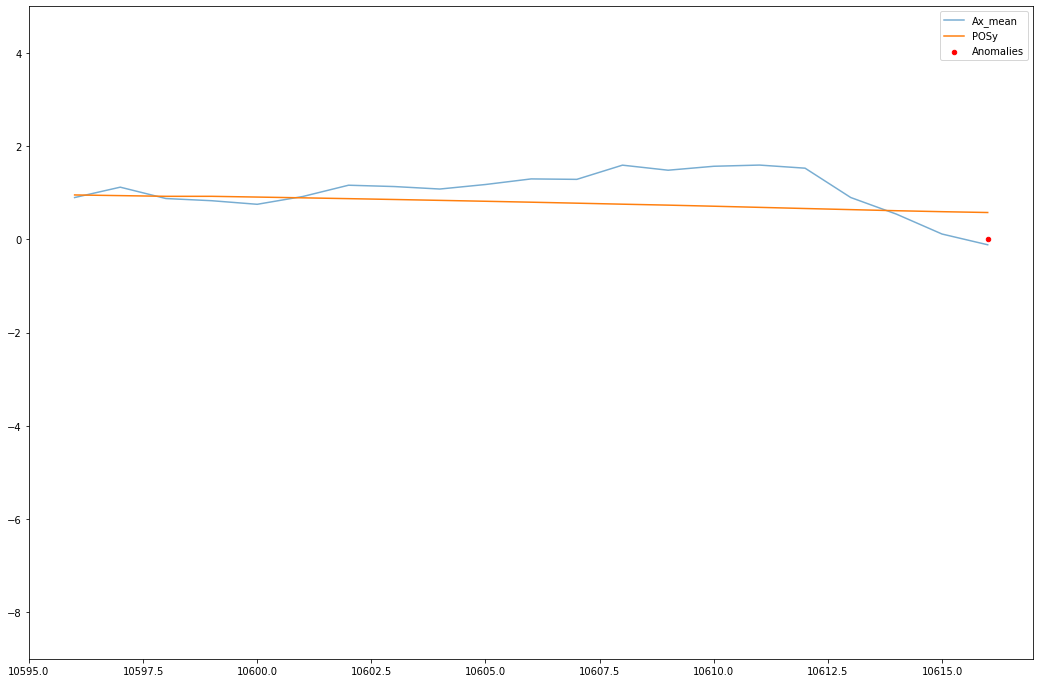

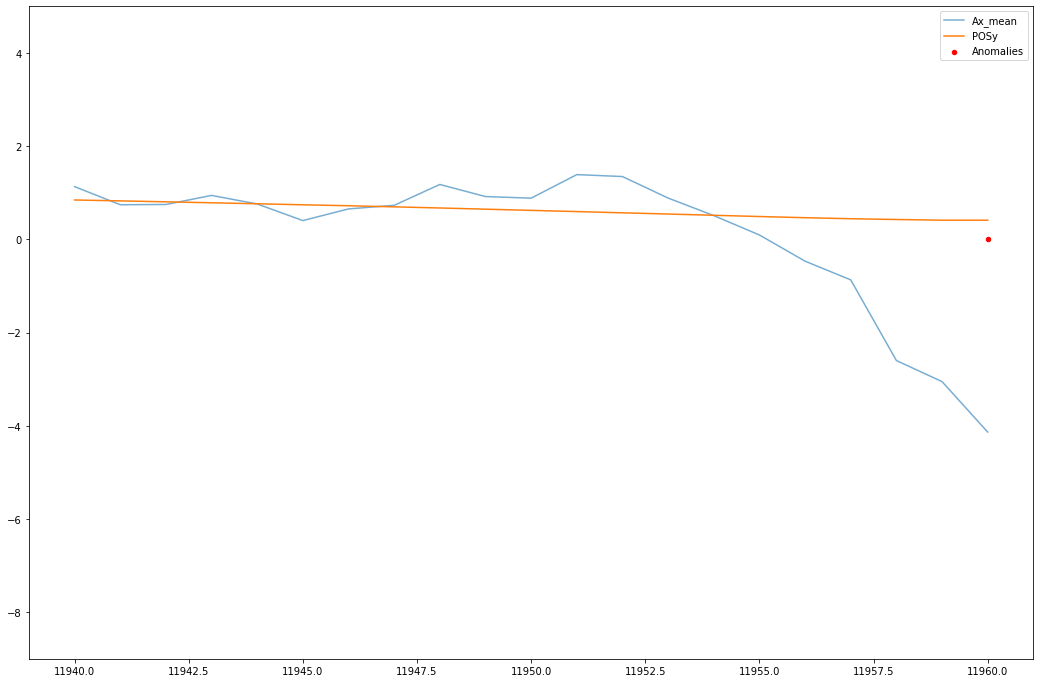

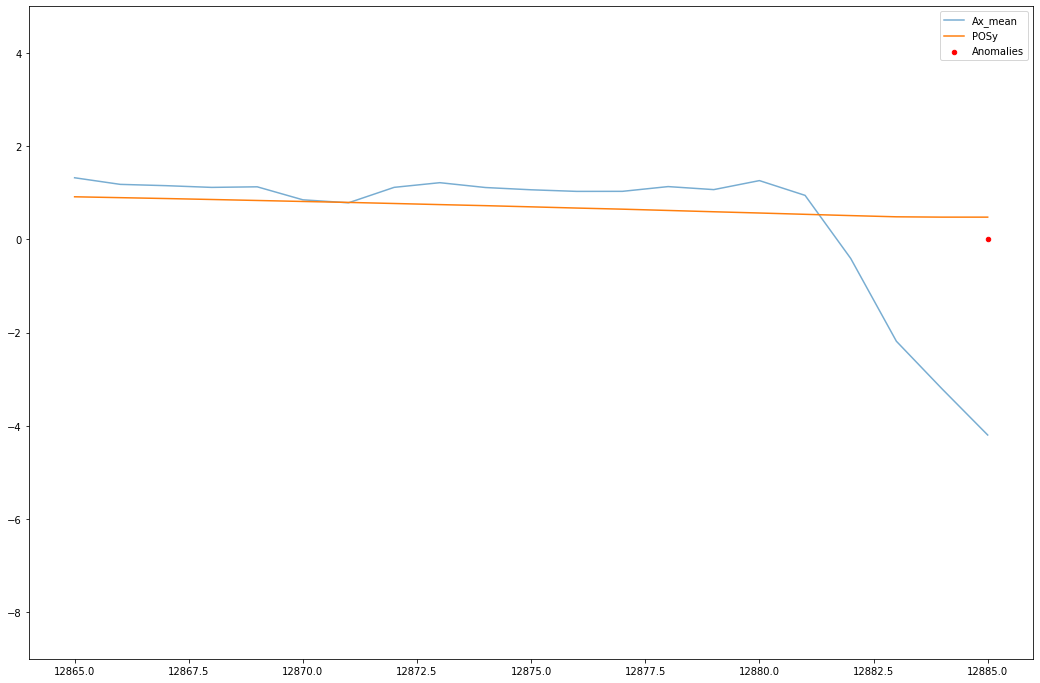

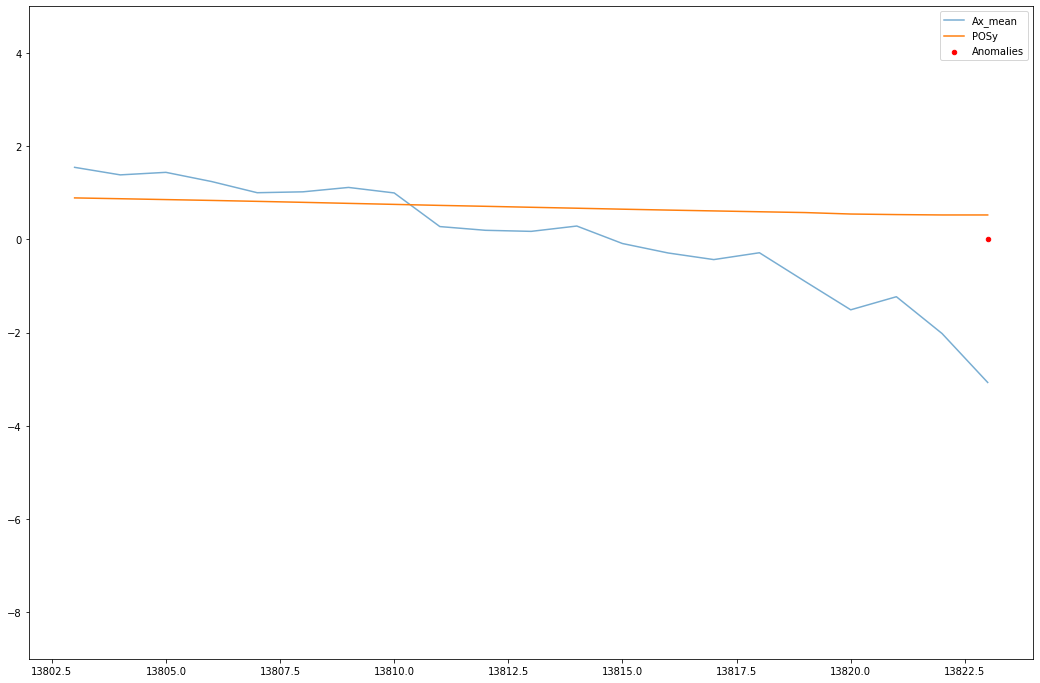

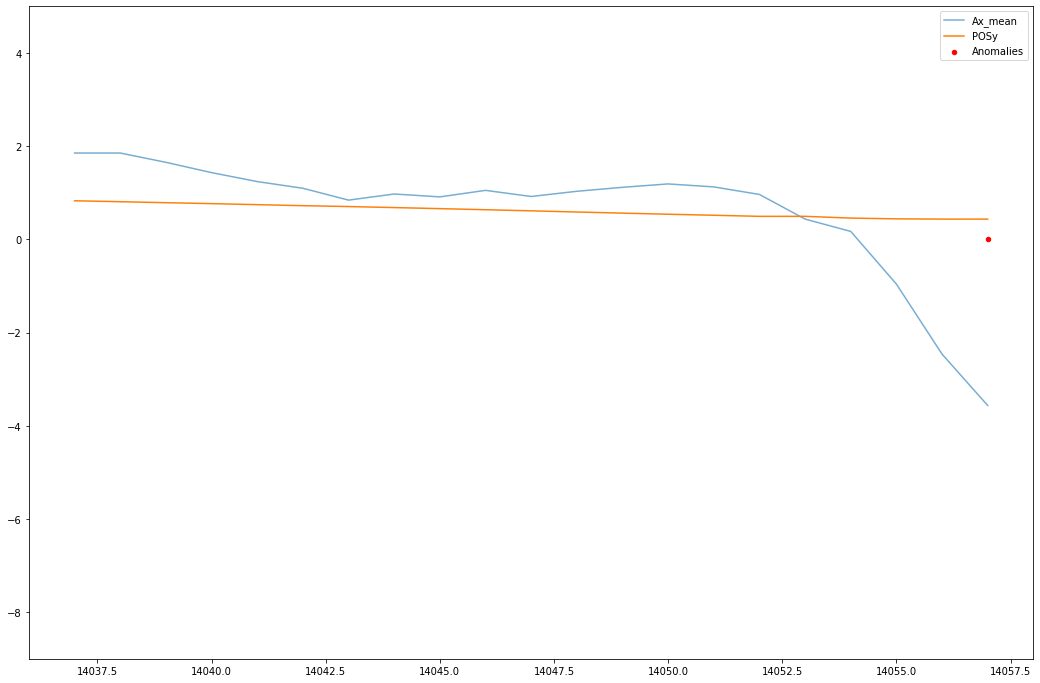

In [39]:
plot_only_faults(df, "Ax_mean")

#### Ax: mean values with differencing

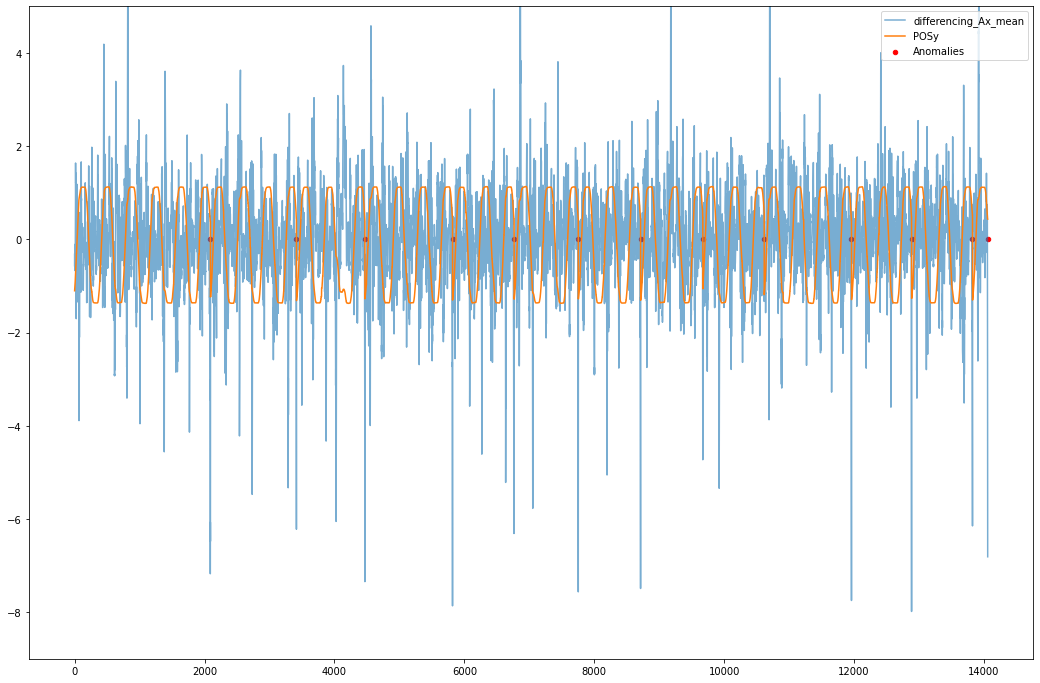

In [40]:
plot_all_signal(df, "differencing_Ax_mean")

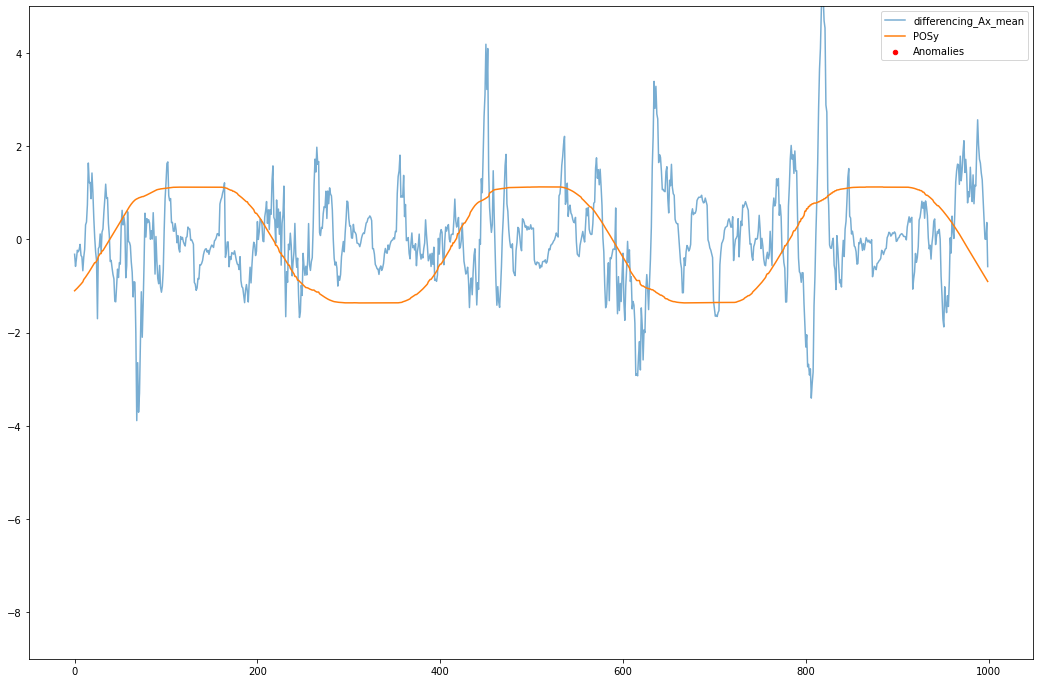

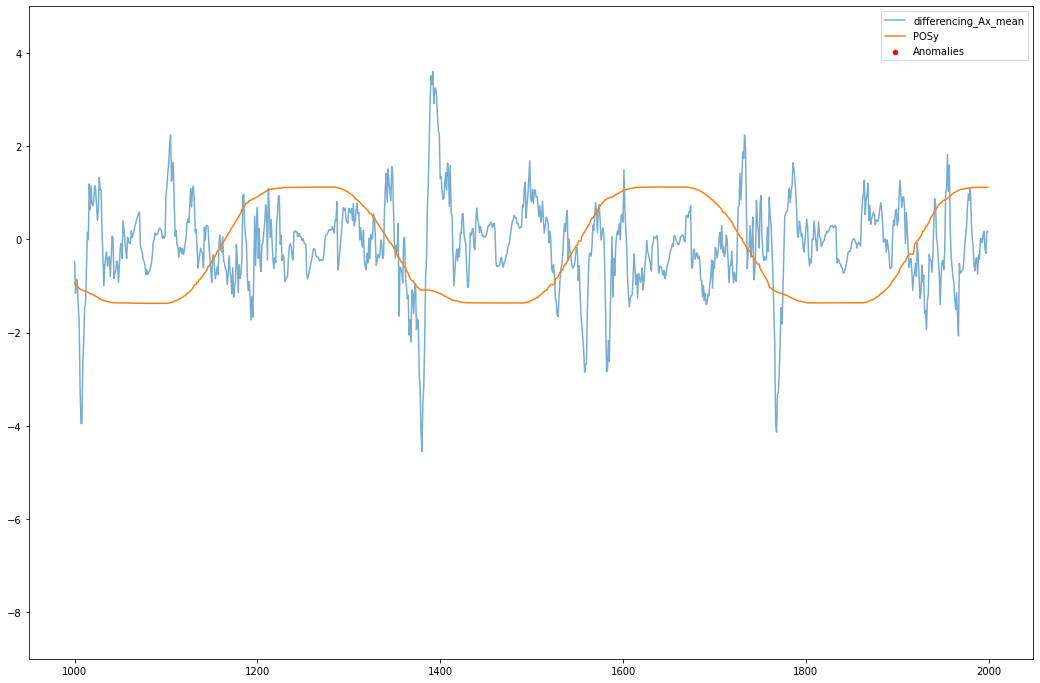

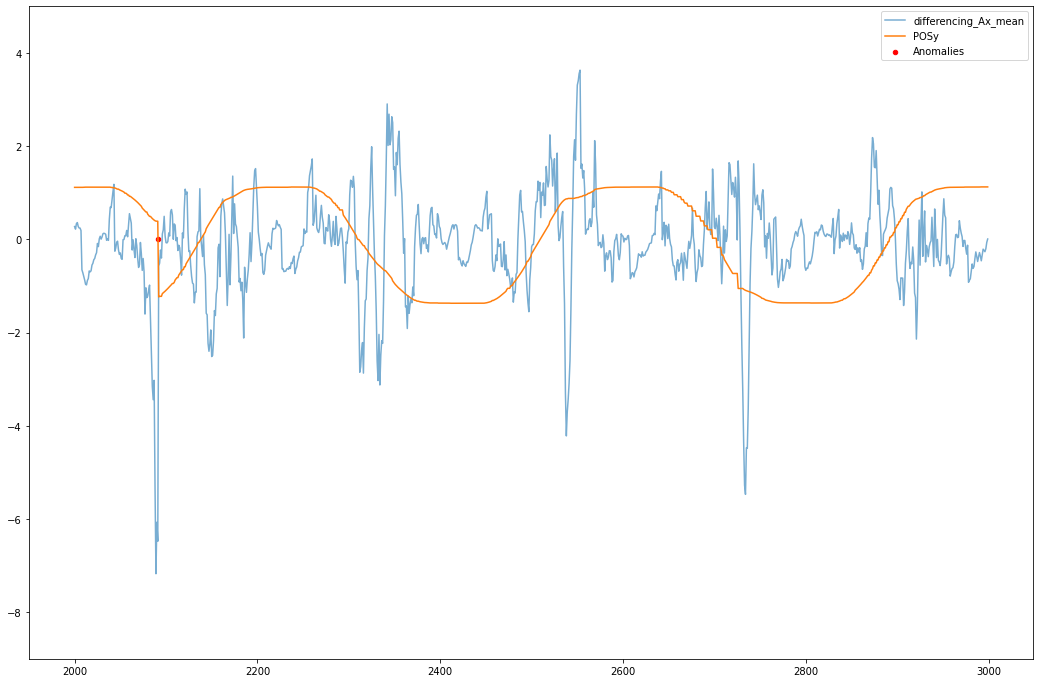

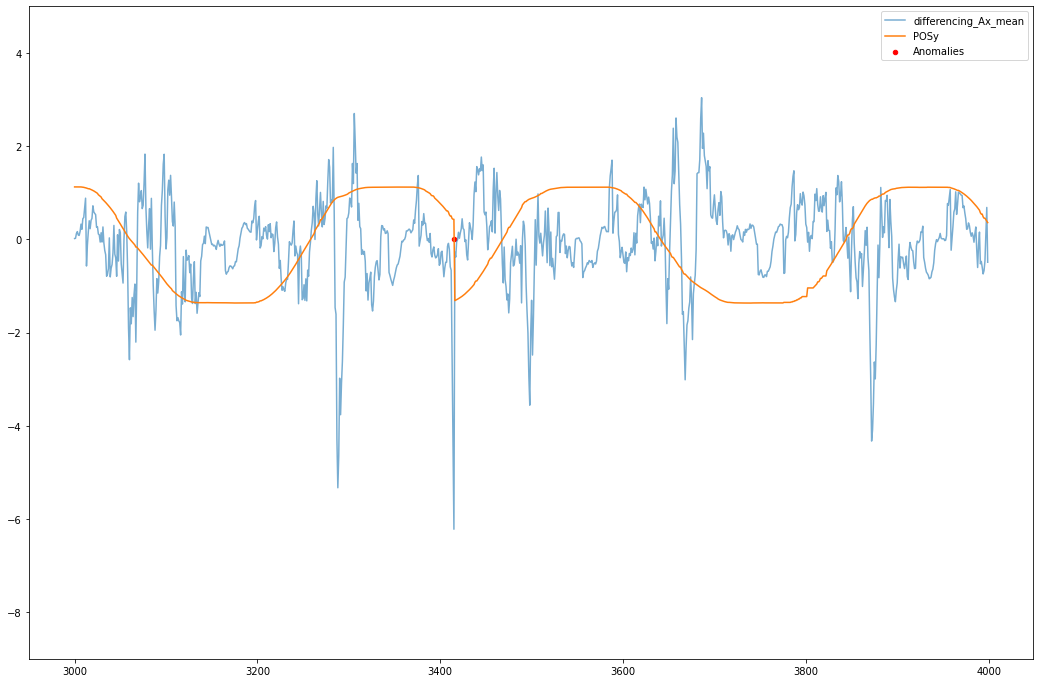

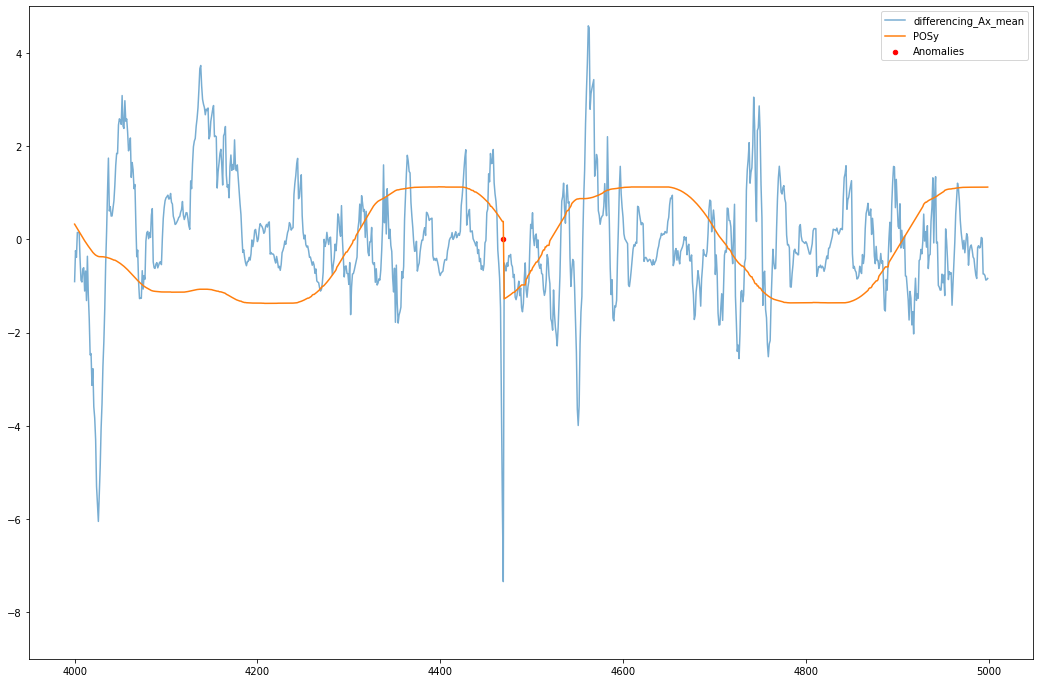

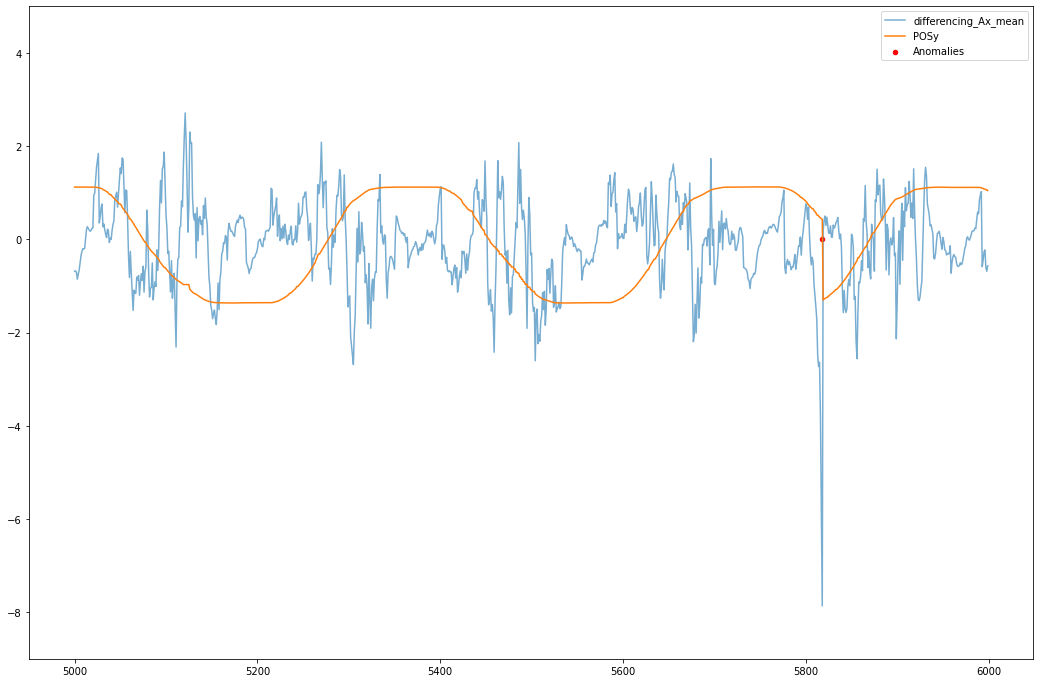

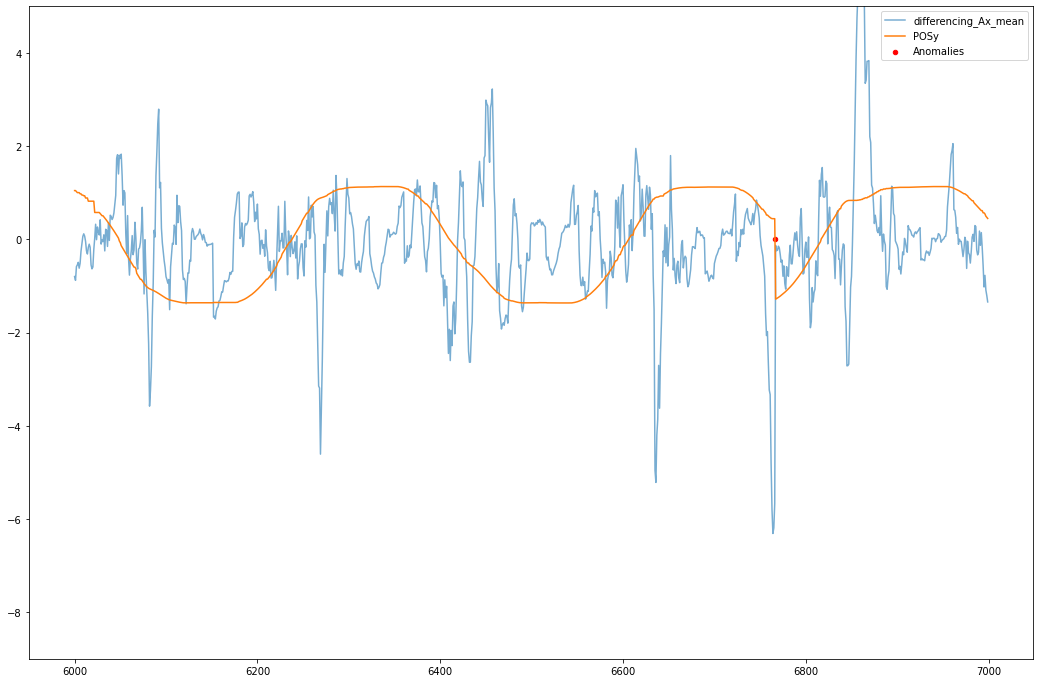

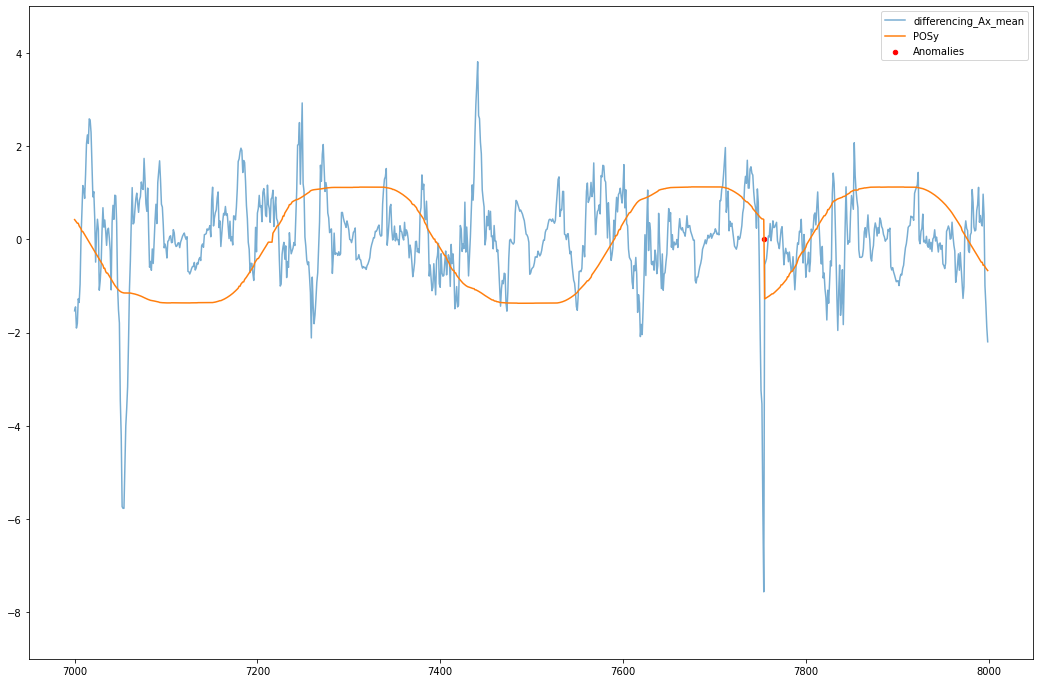

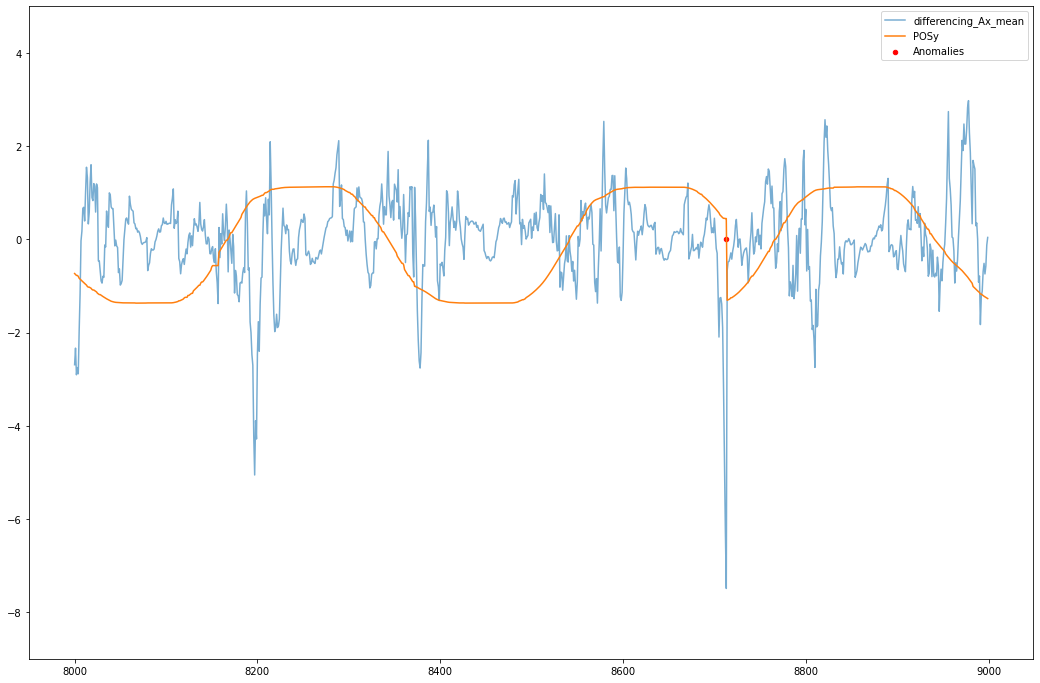

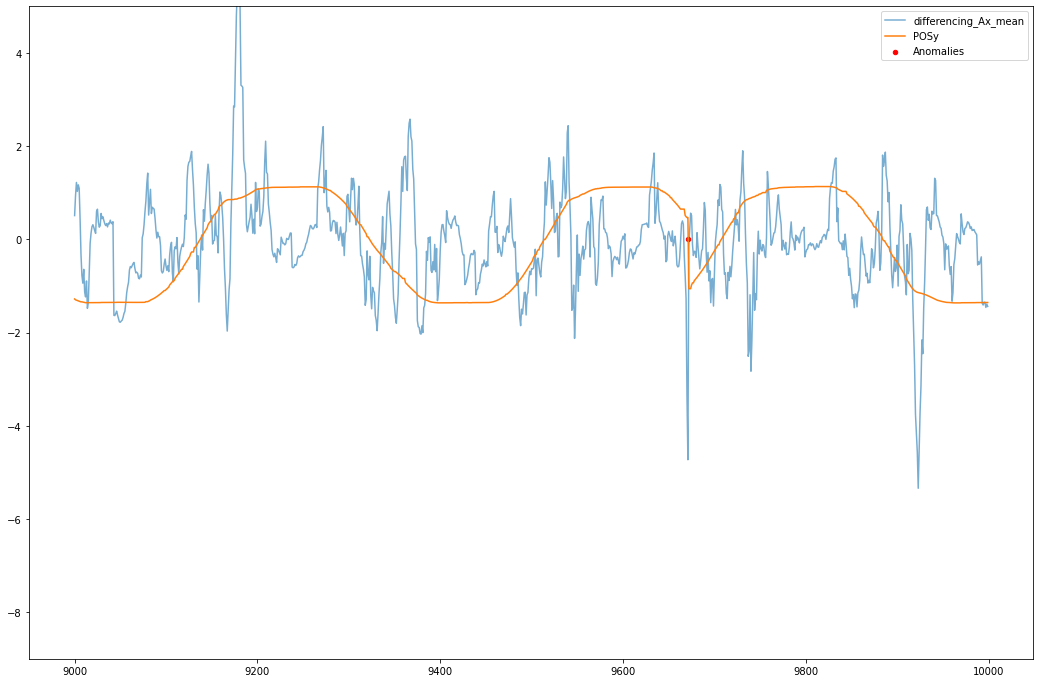

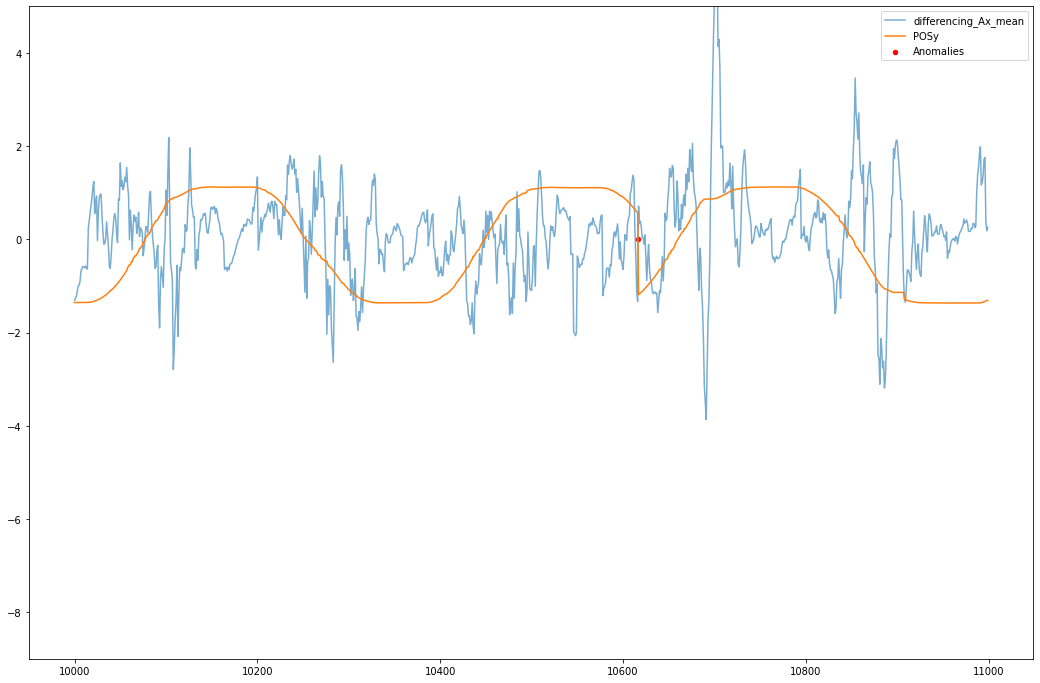

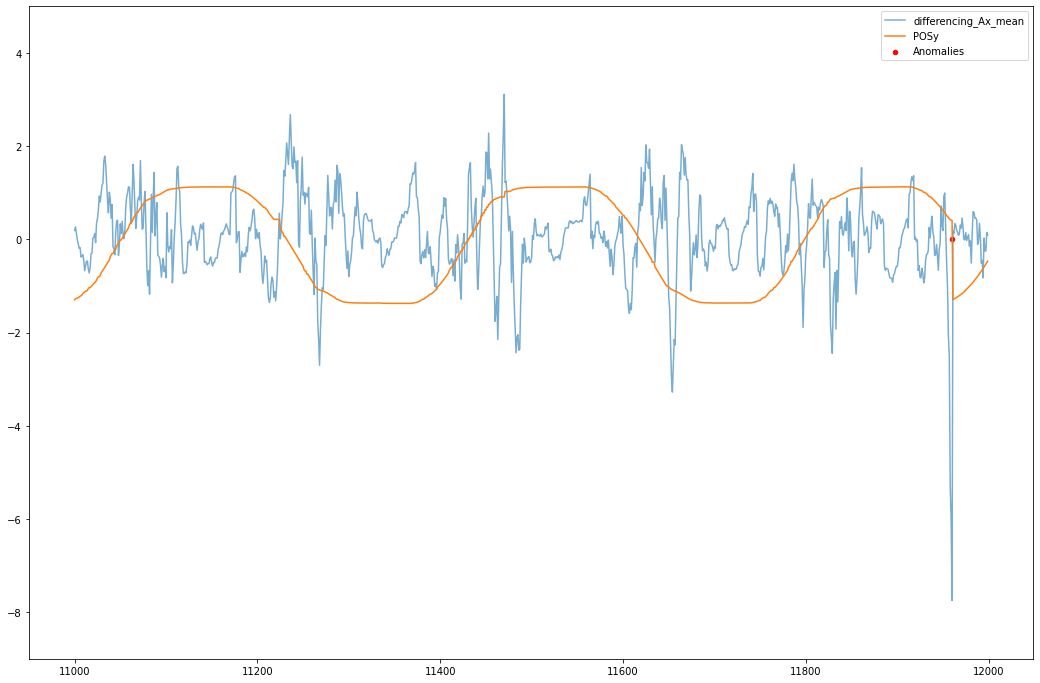

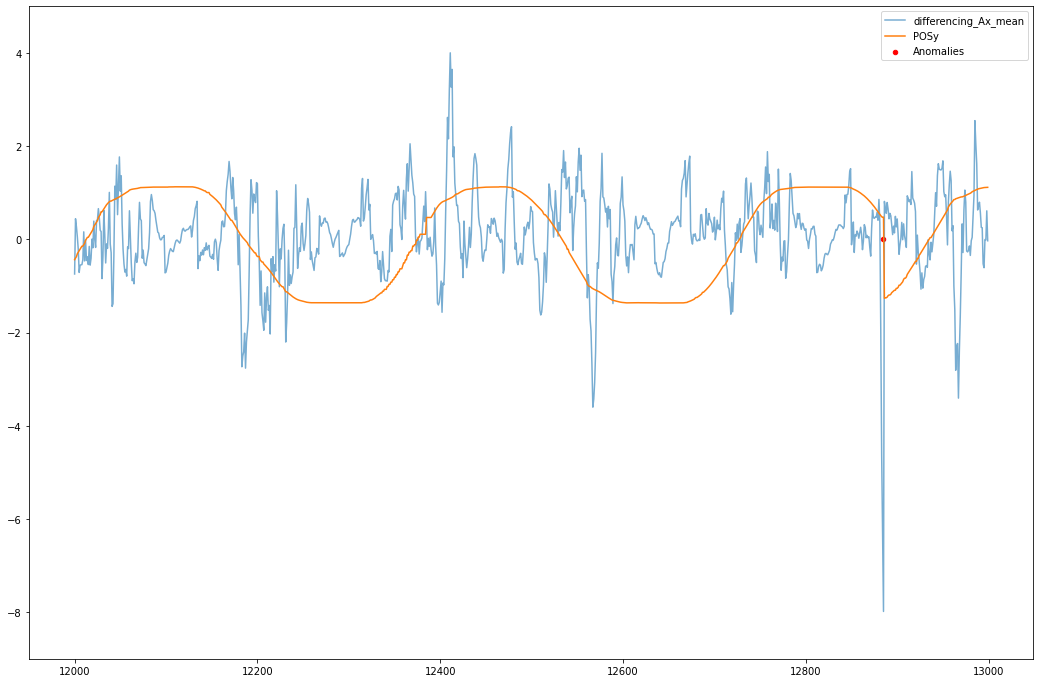

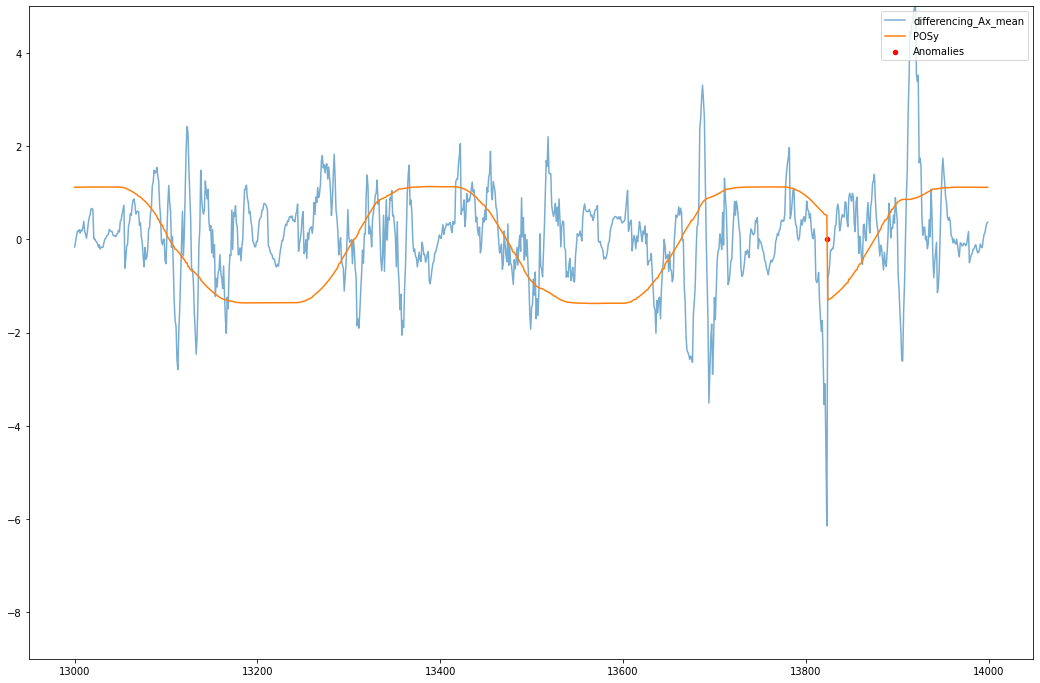

In [41]:
plot_all_signal_zoomed(df, "differencing_Ax_mean")

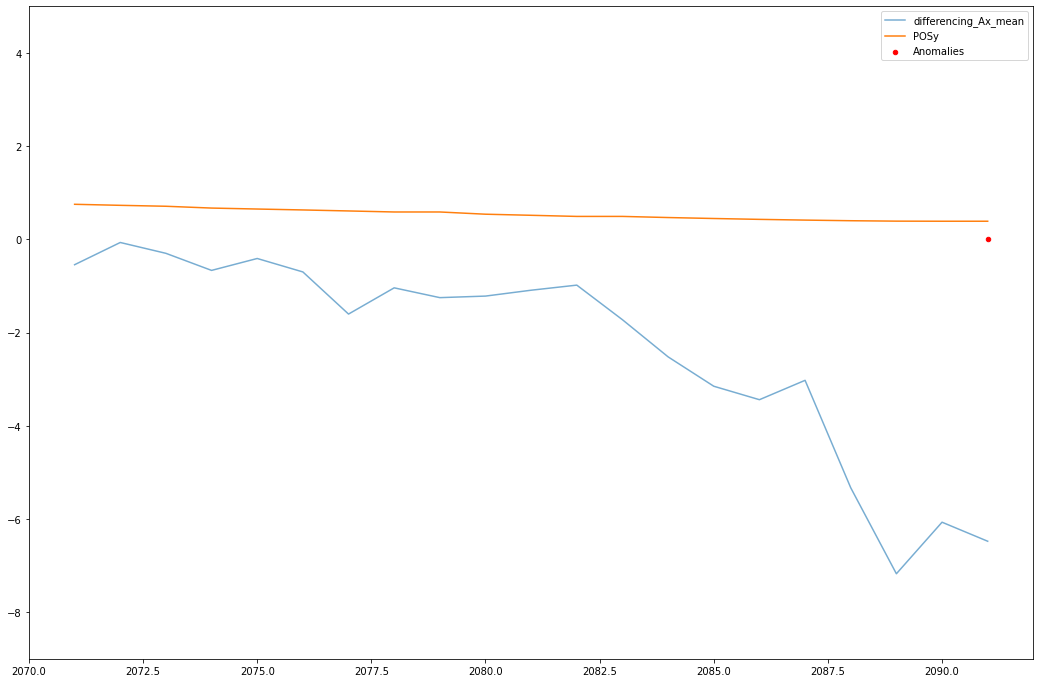

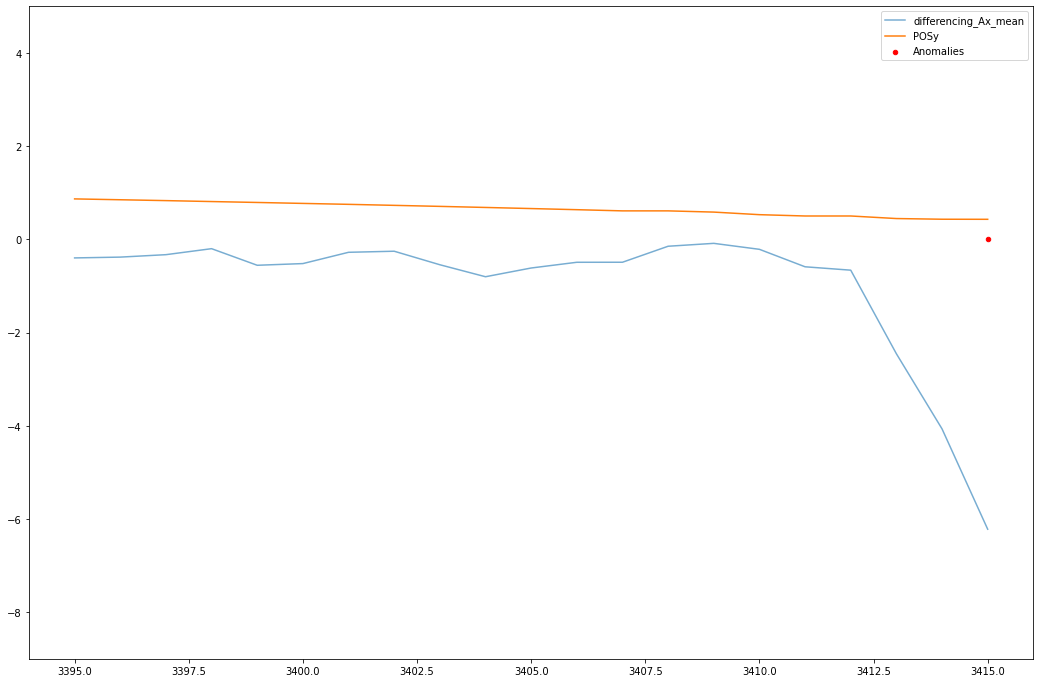

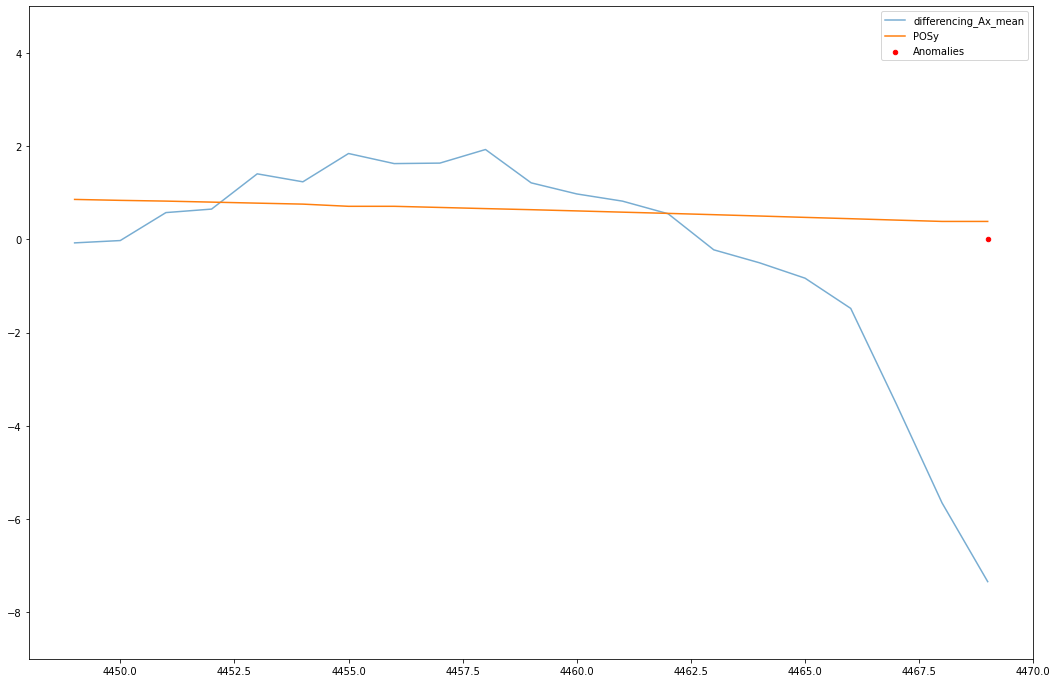

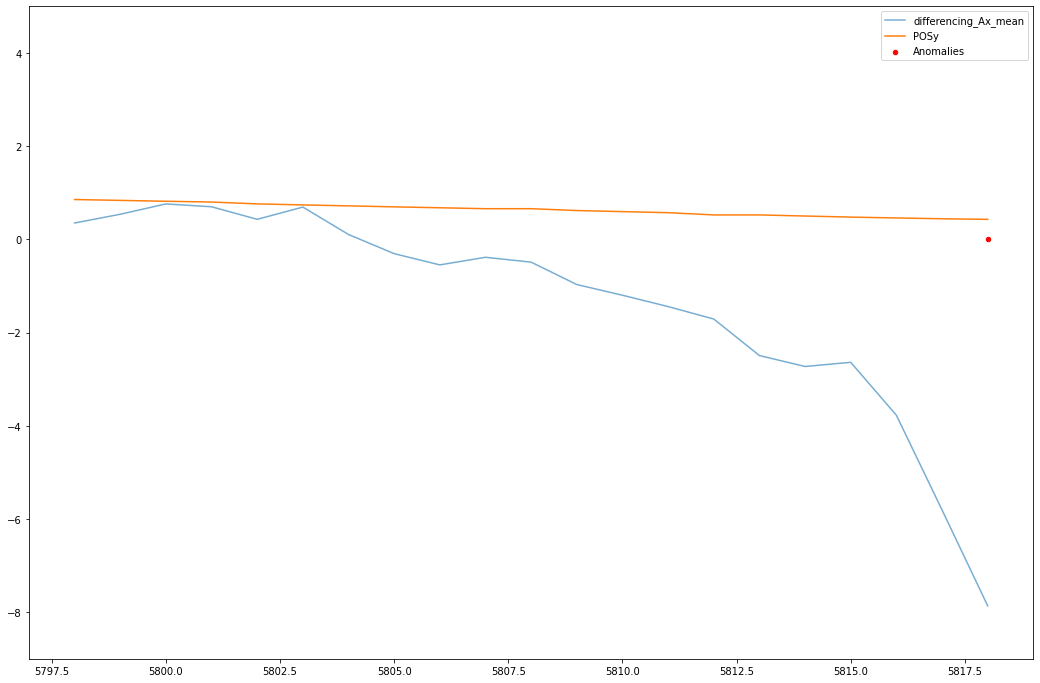

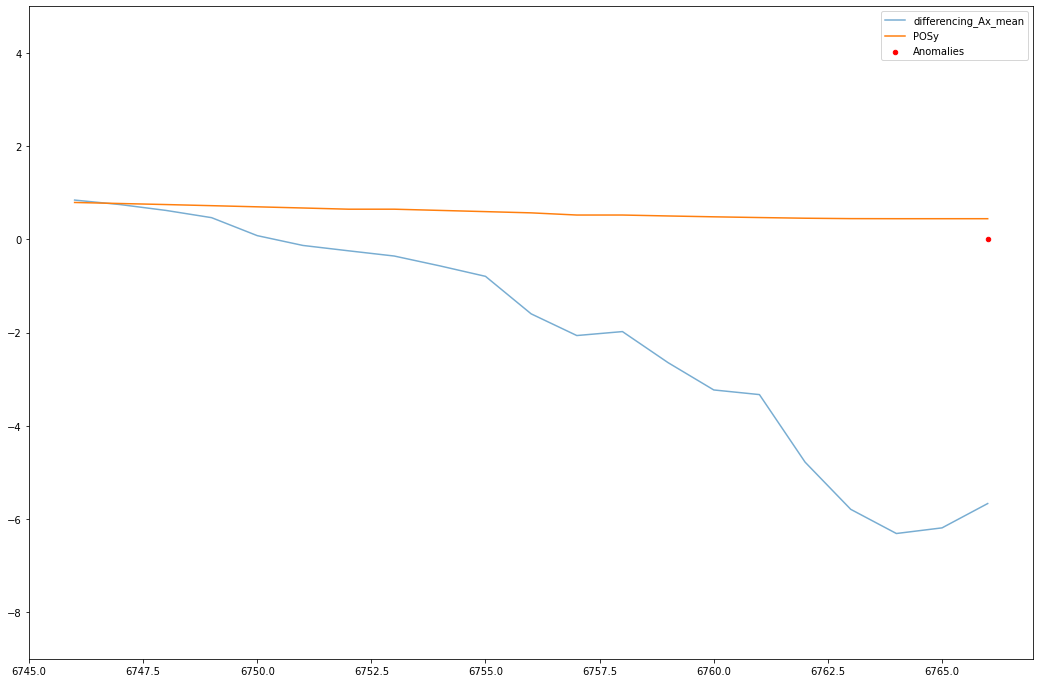

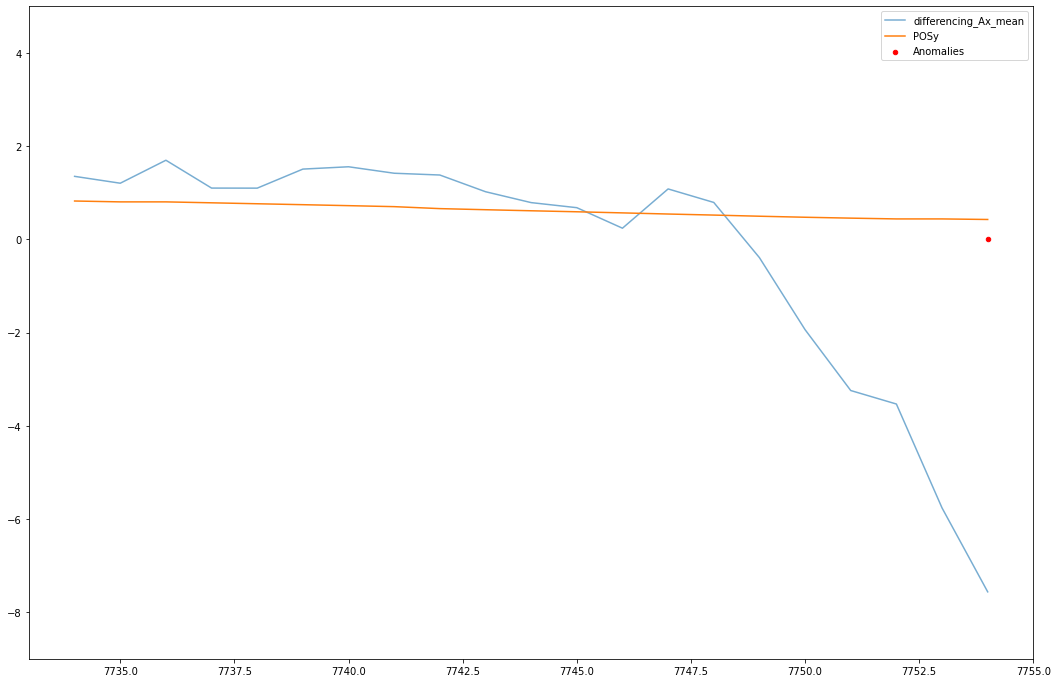

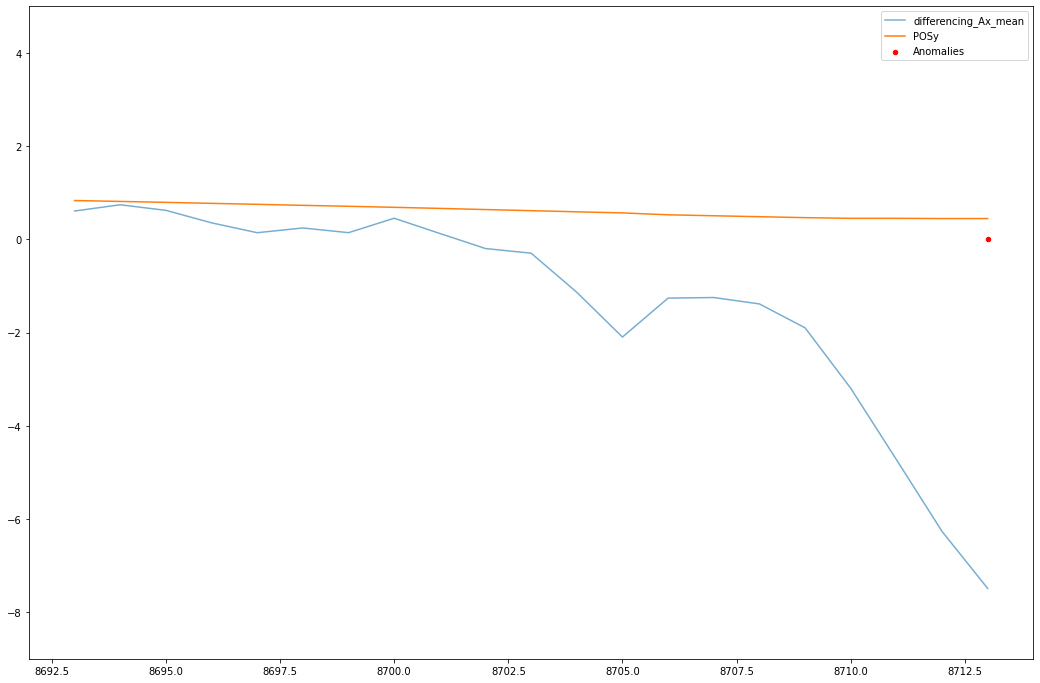

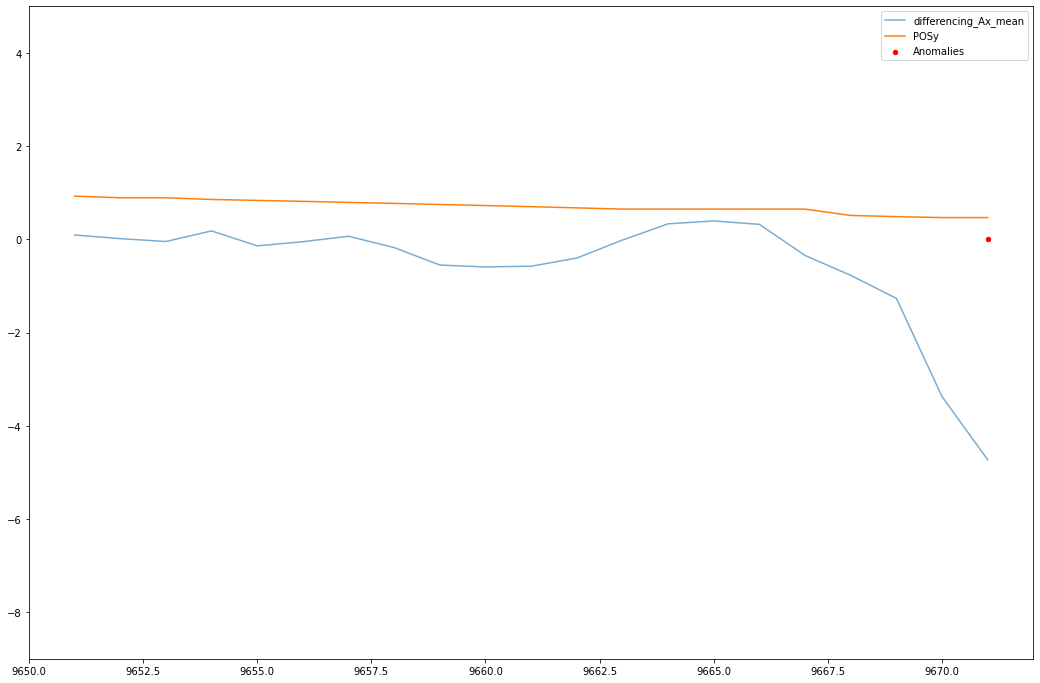

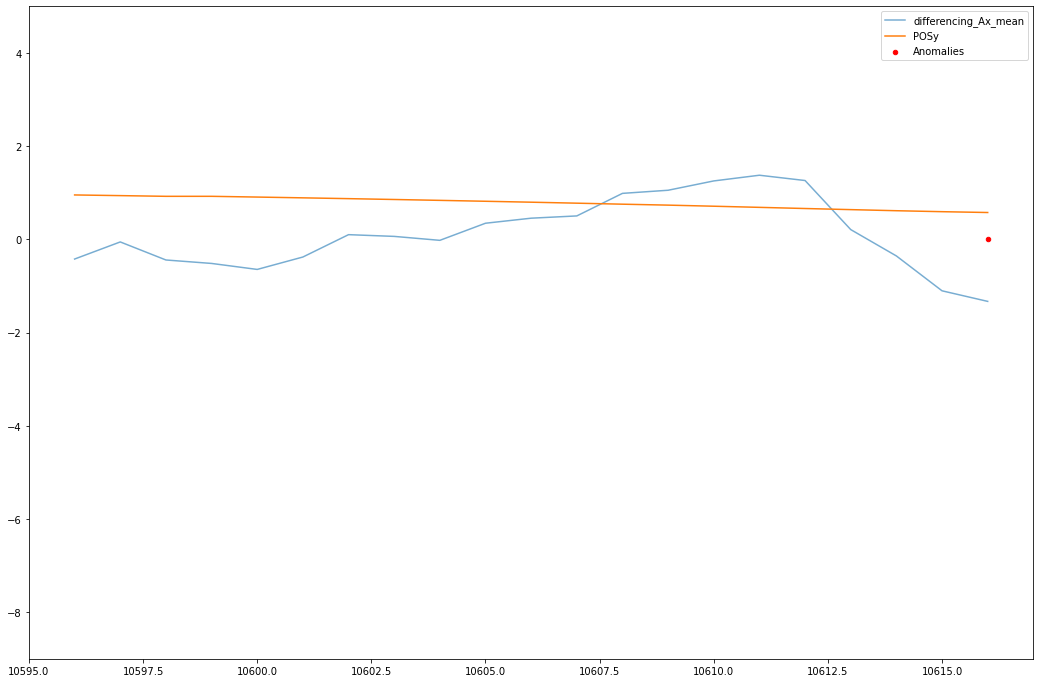

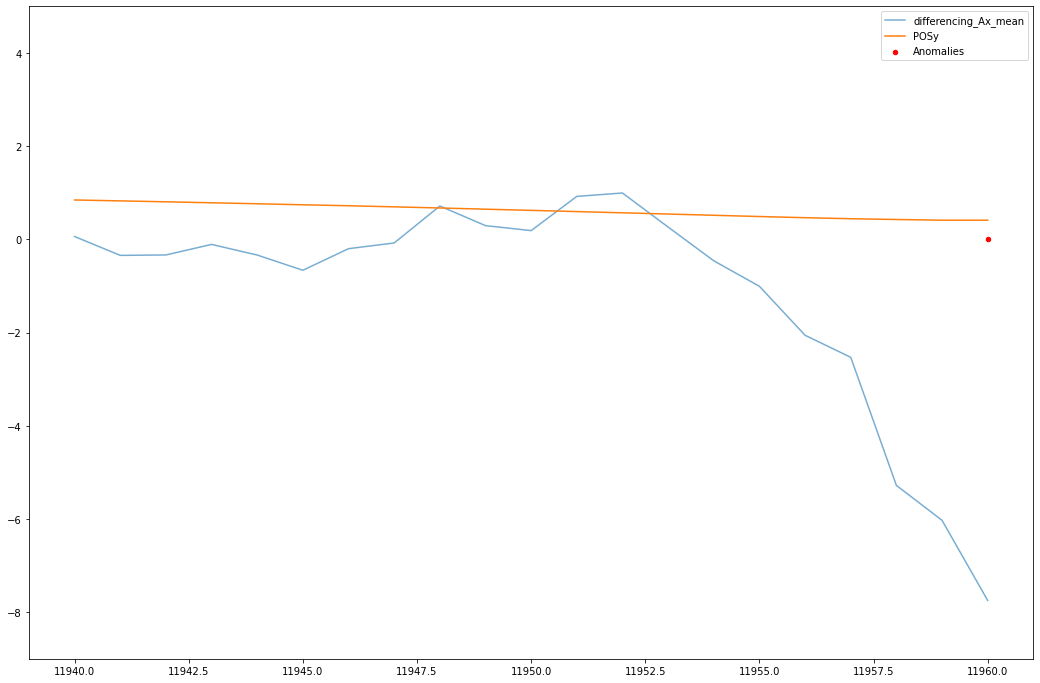

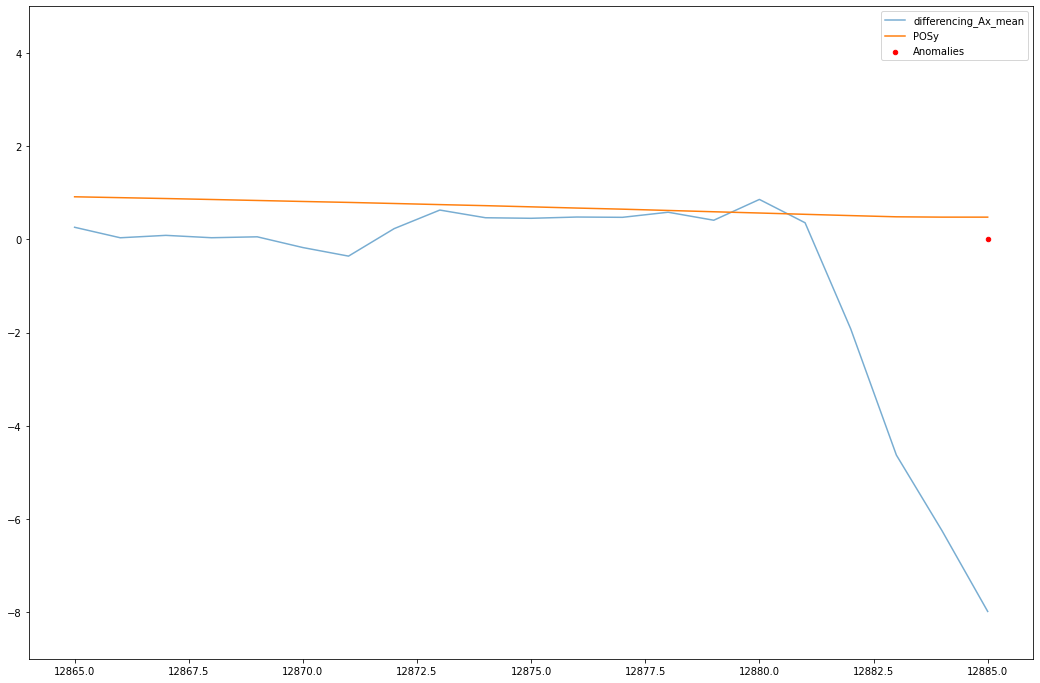

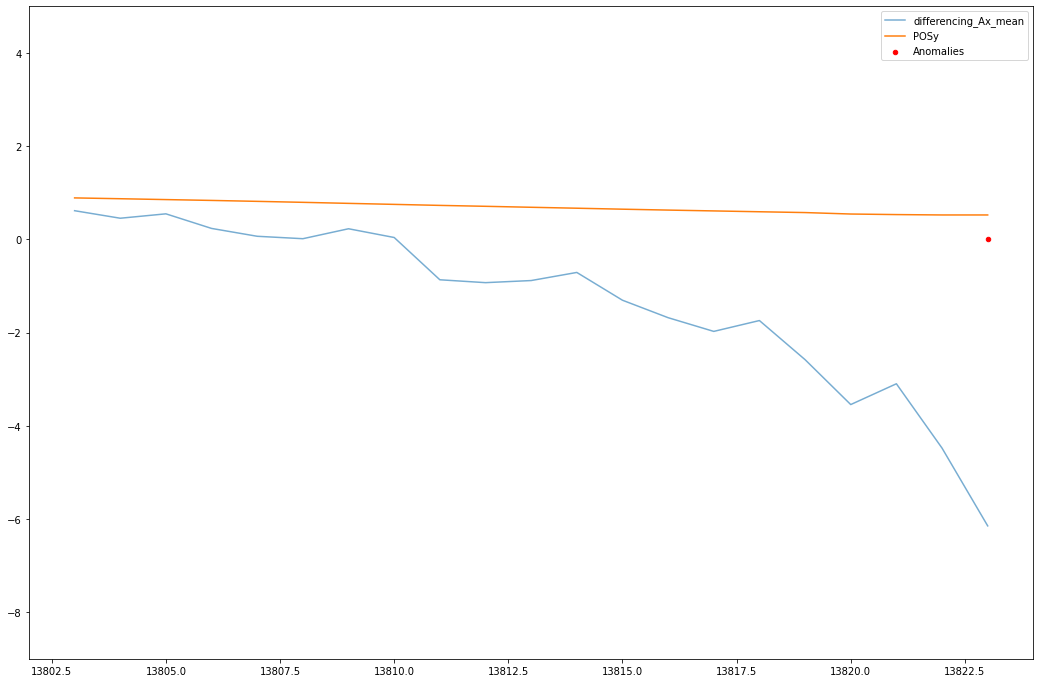

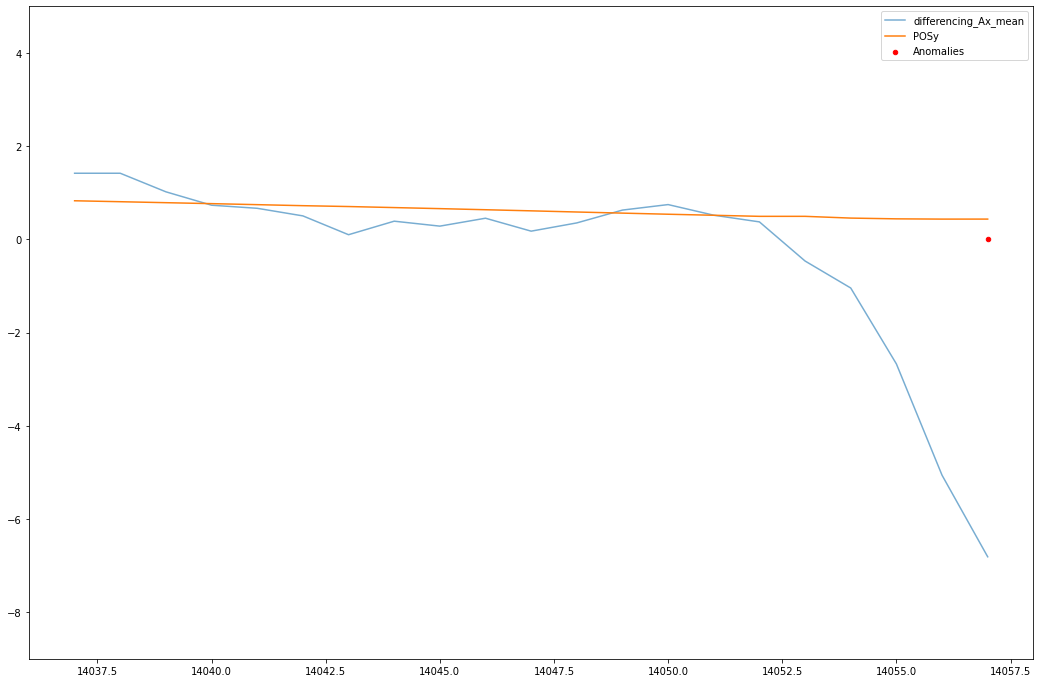

In [42]:
plot_only_faults(df, "differencing_Ax_mean")

#### Ay & Gz: mean values with differencing zooming on all signal

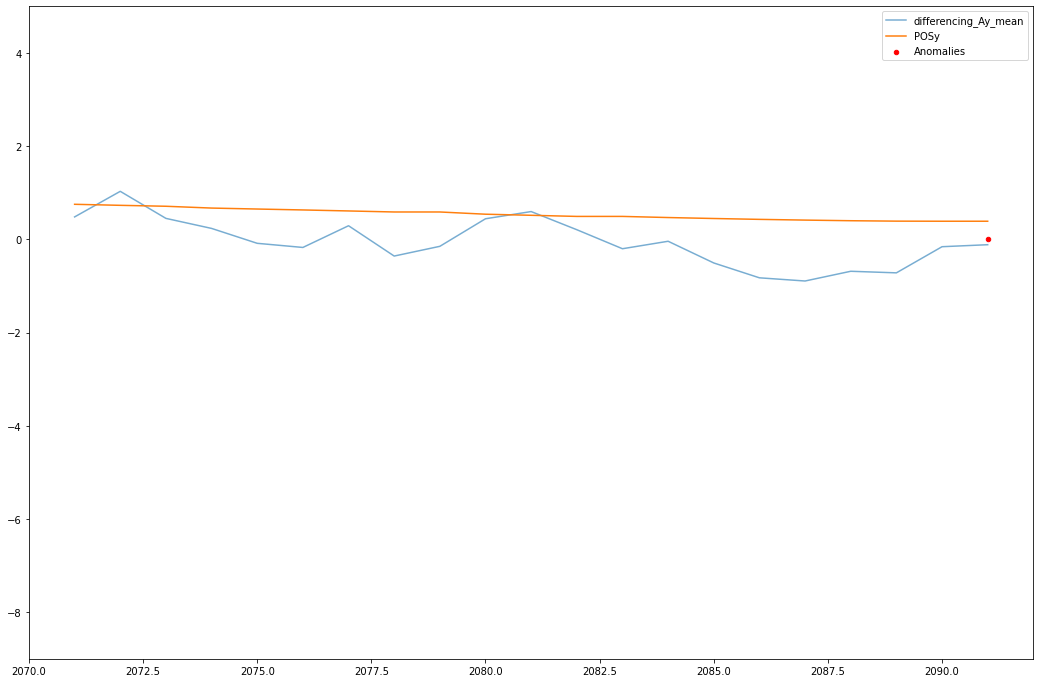

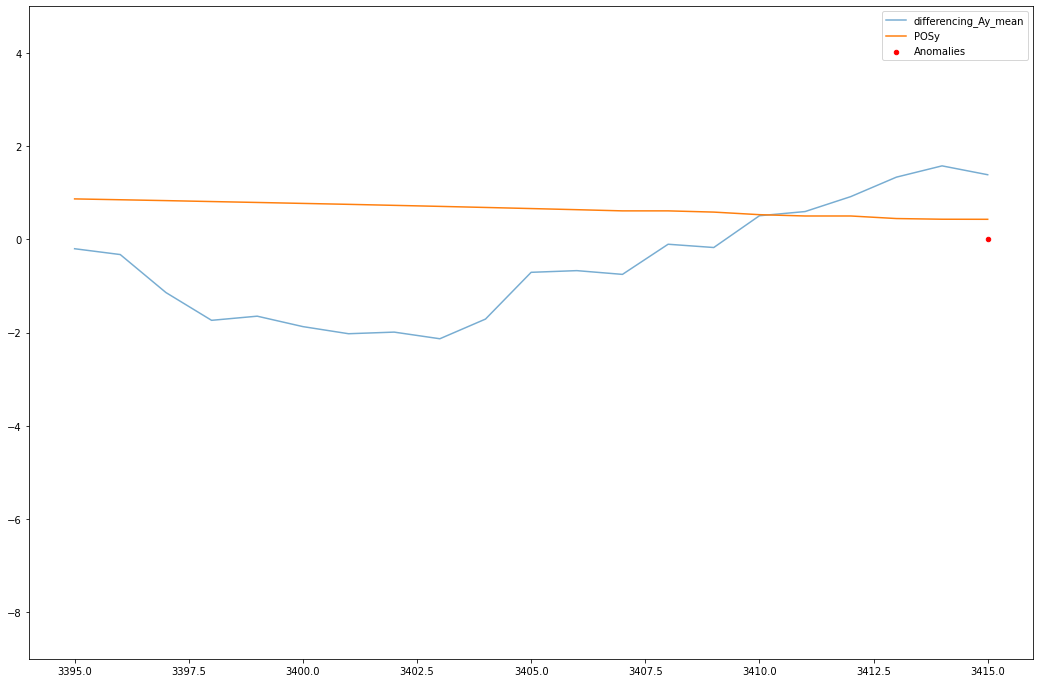

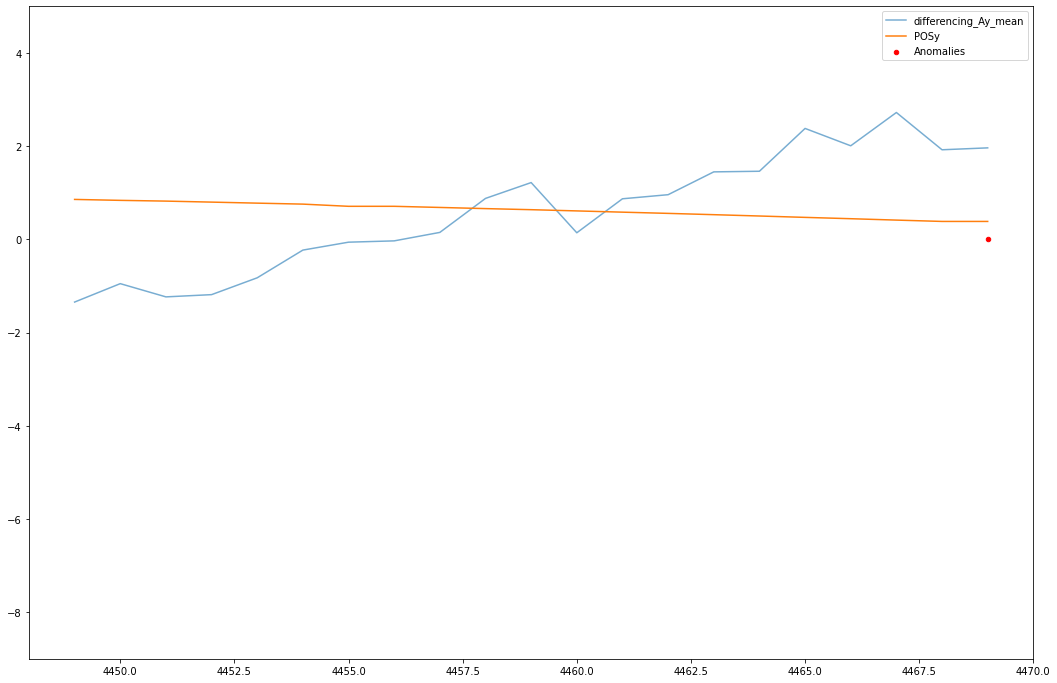

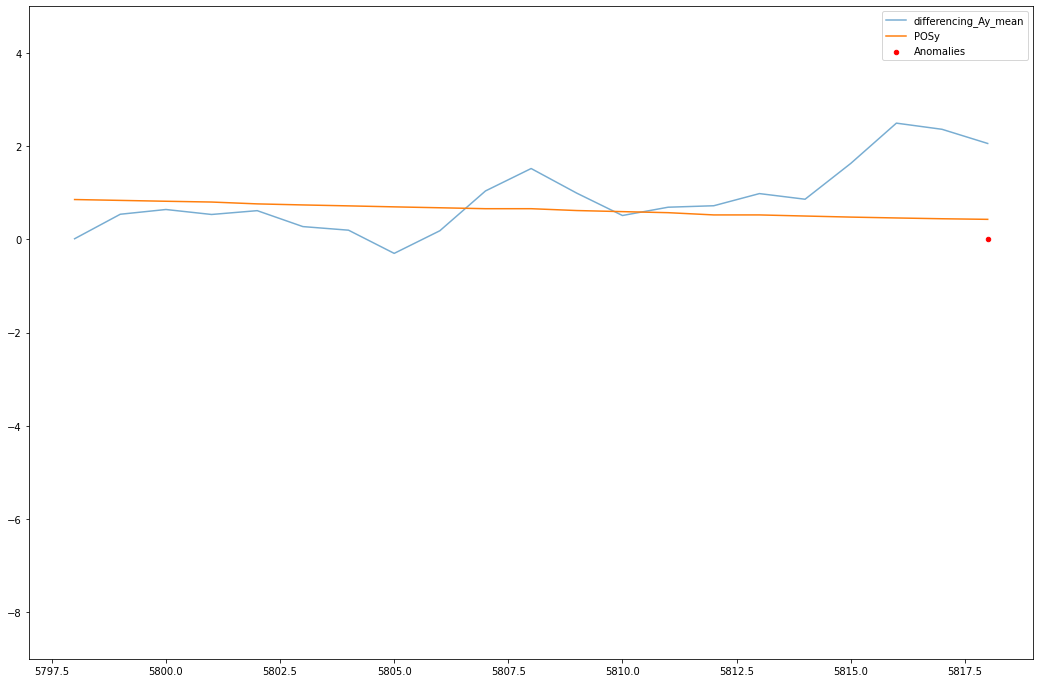

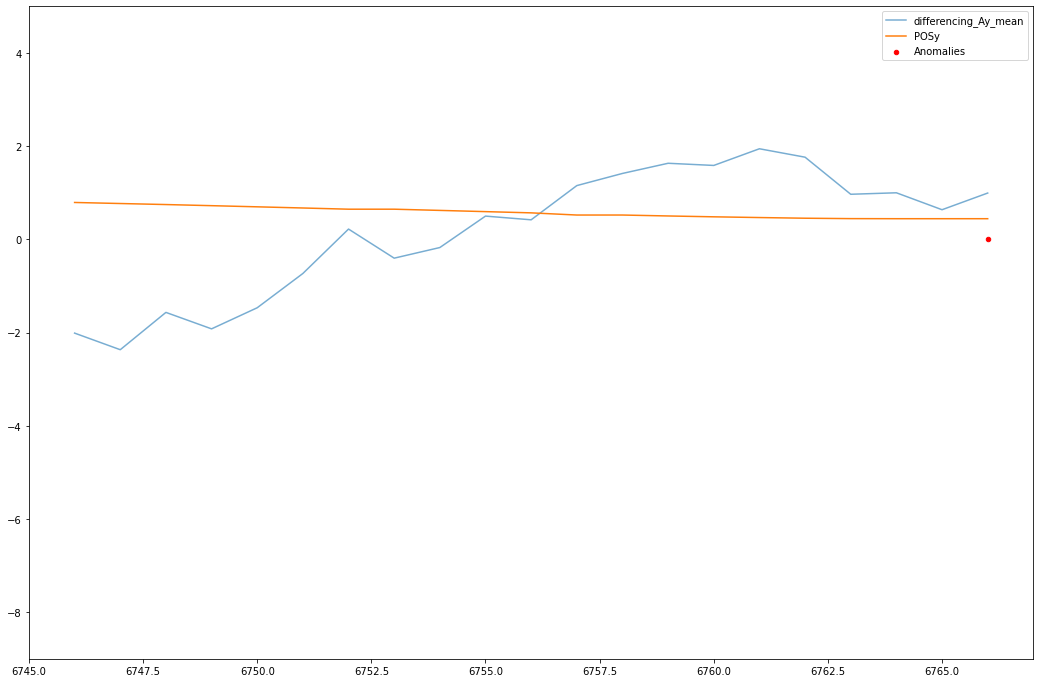

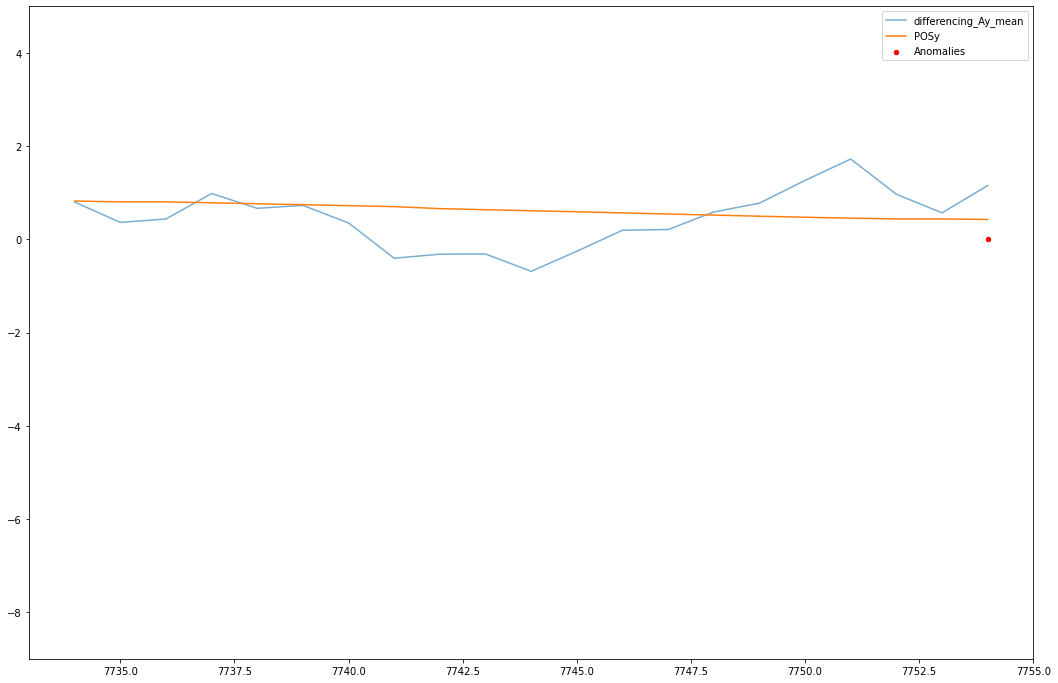

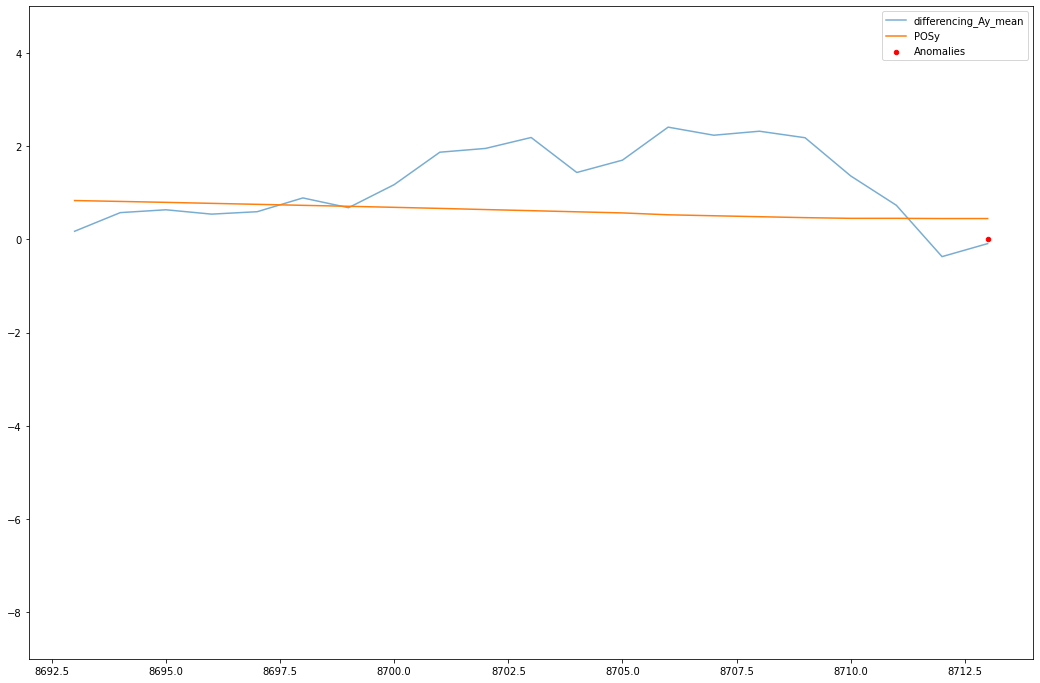

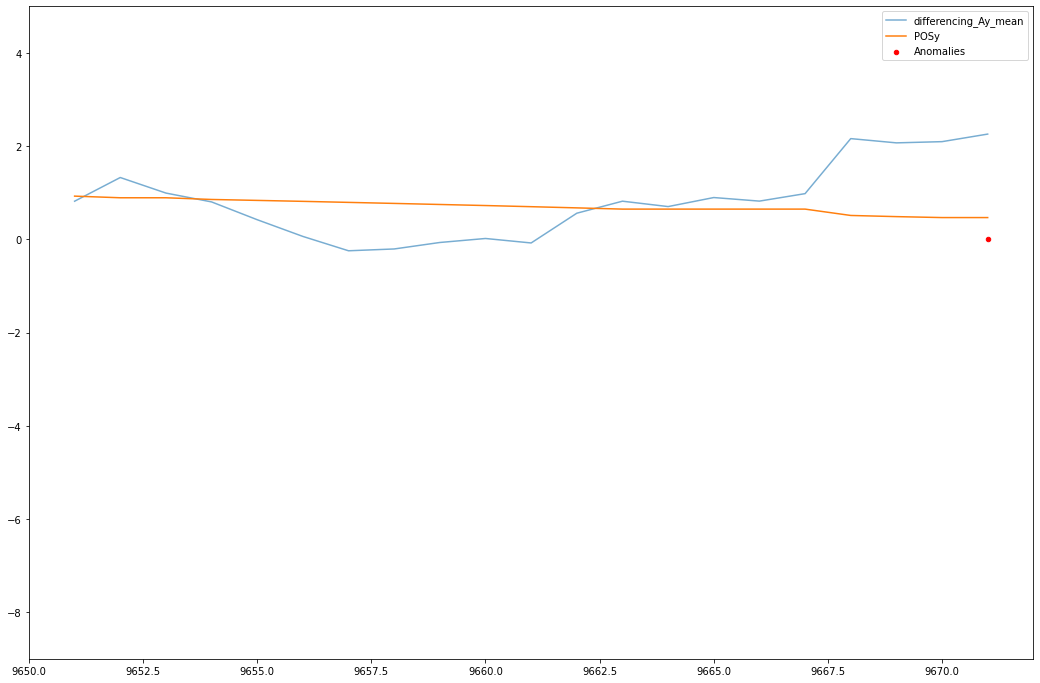

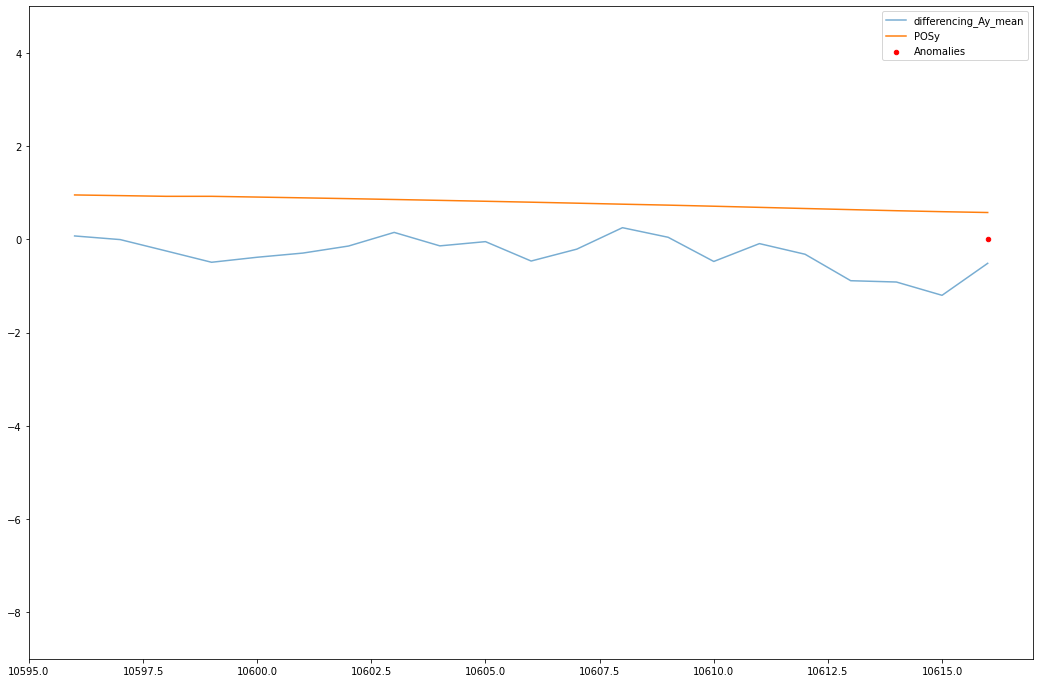

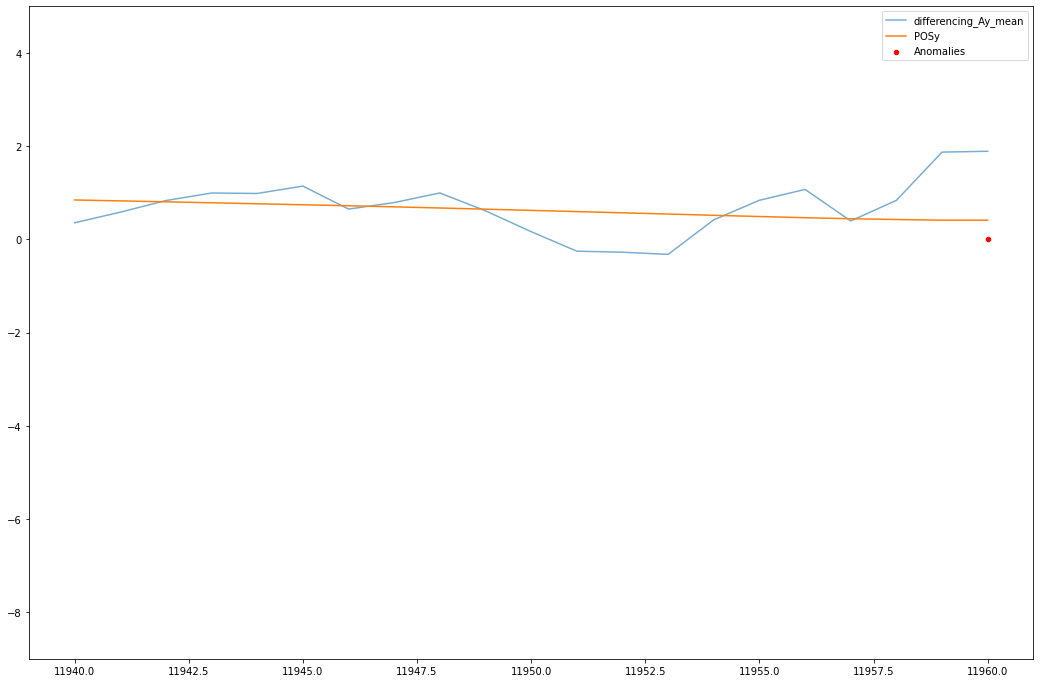

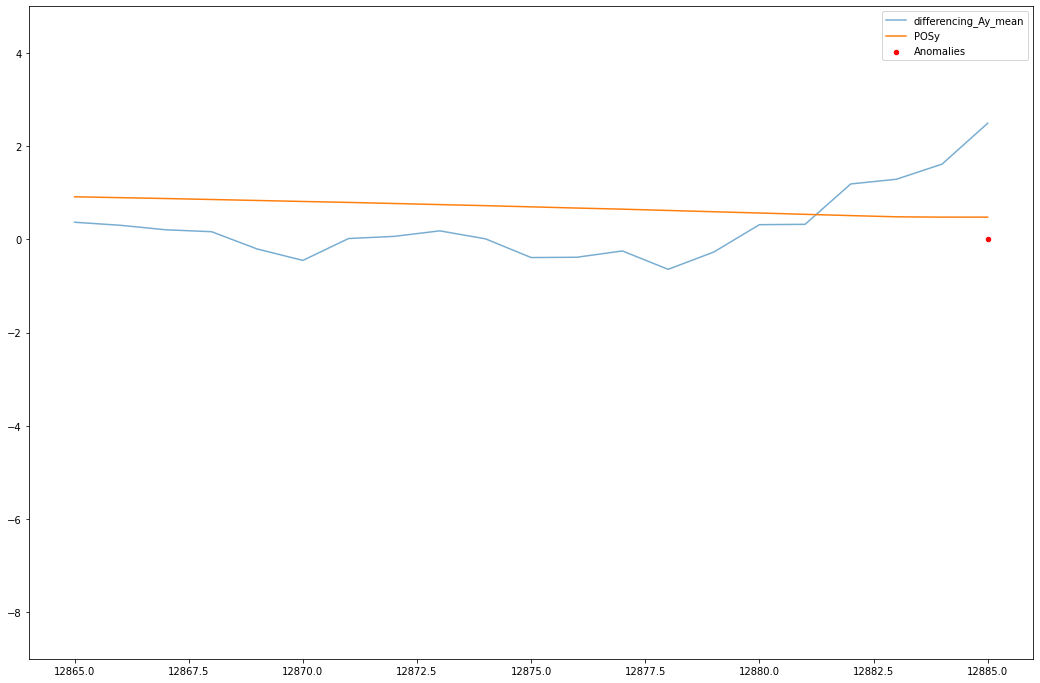

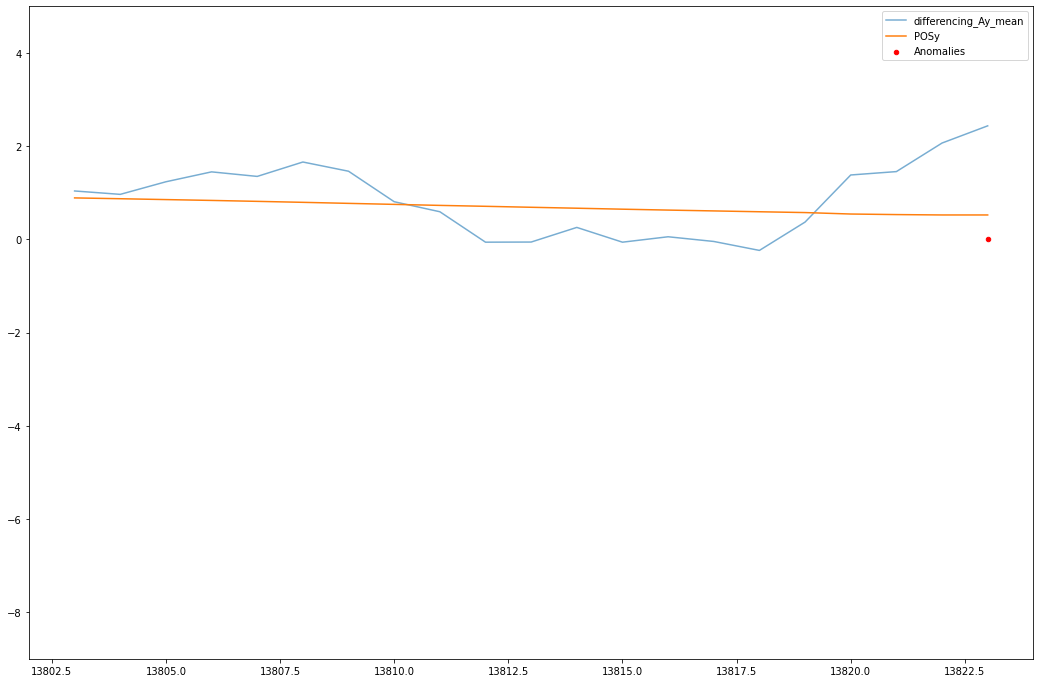

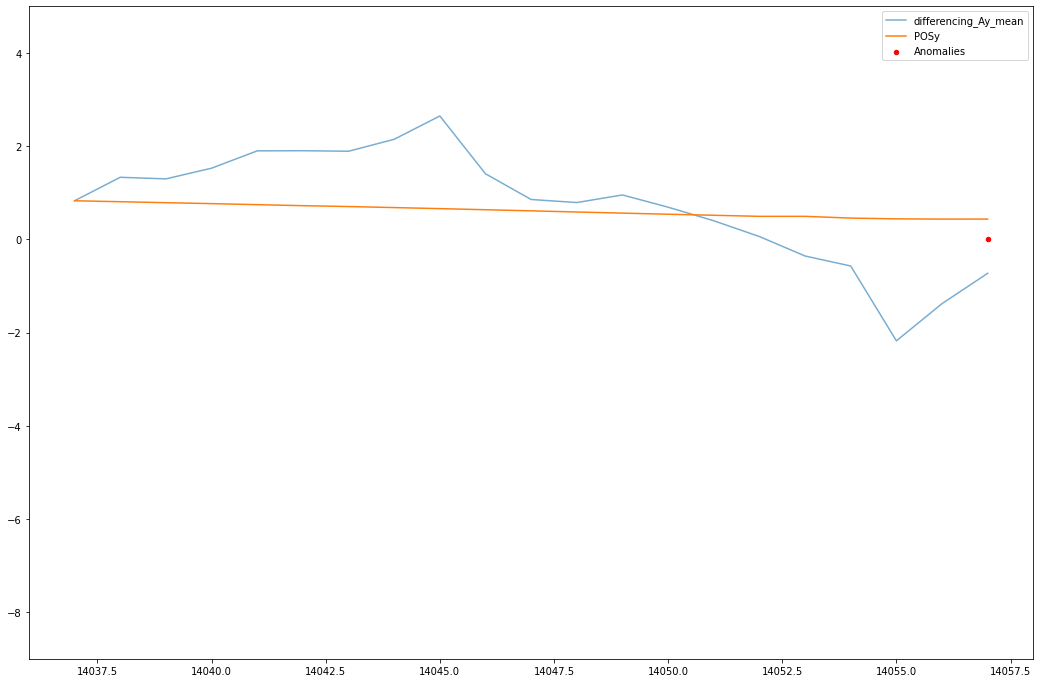

In [43]:
plot_only_faults(df, "differencing_Ay_mean")

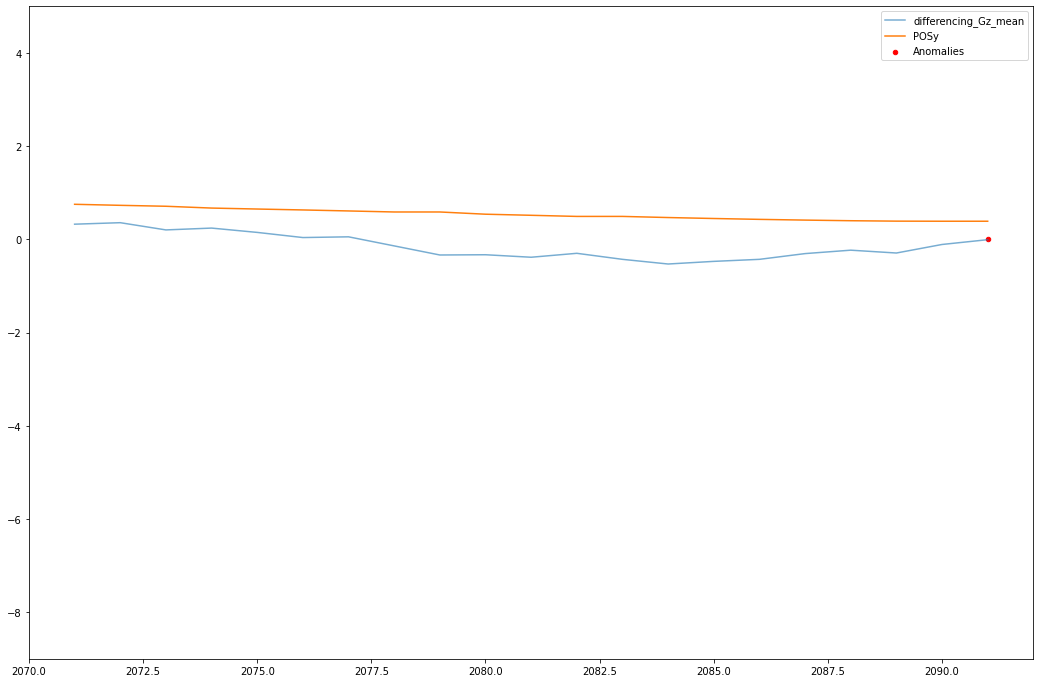

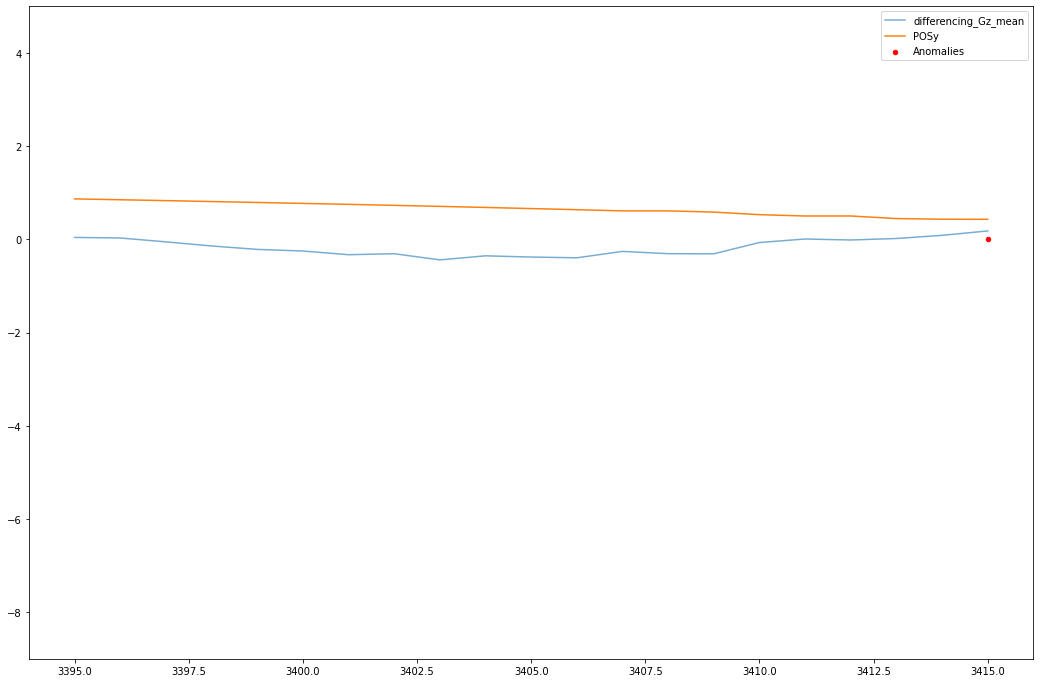

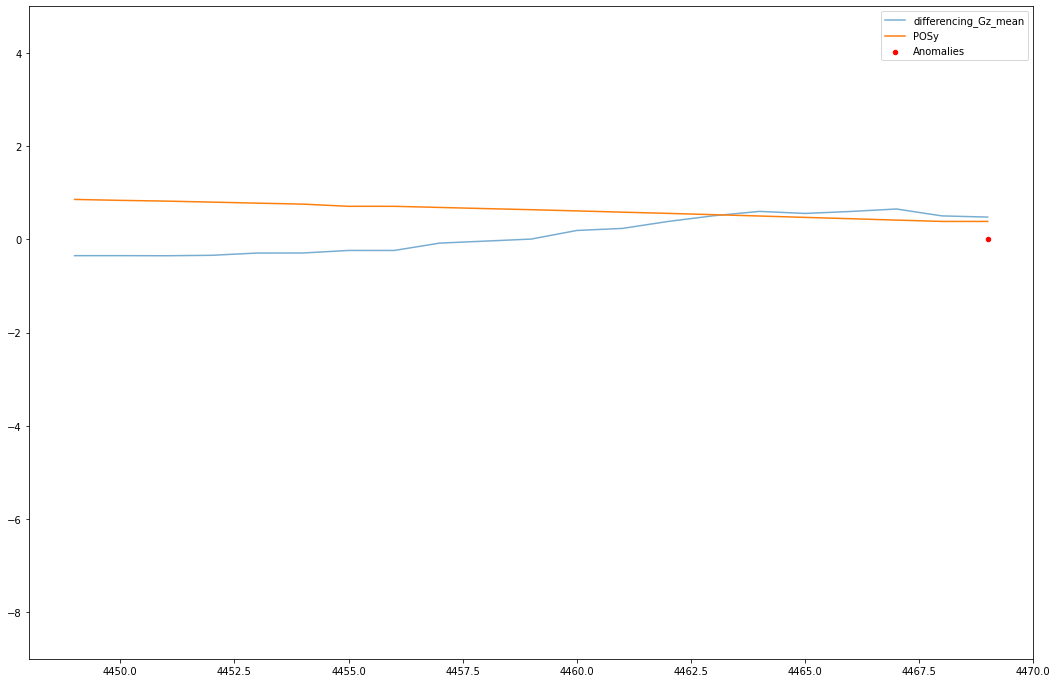

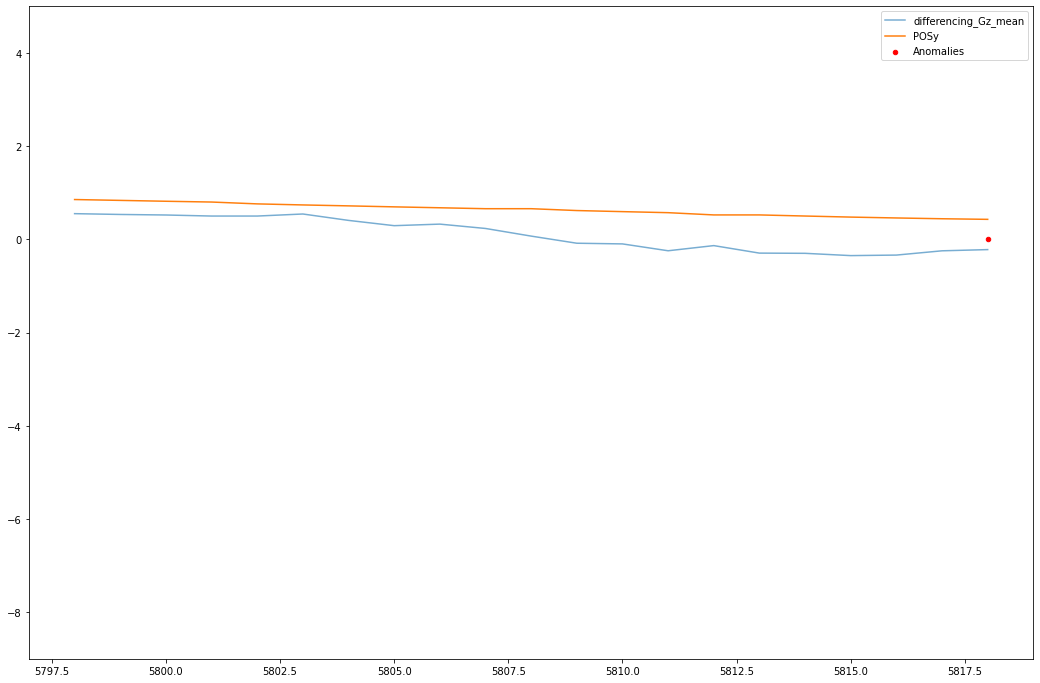

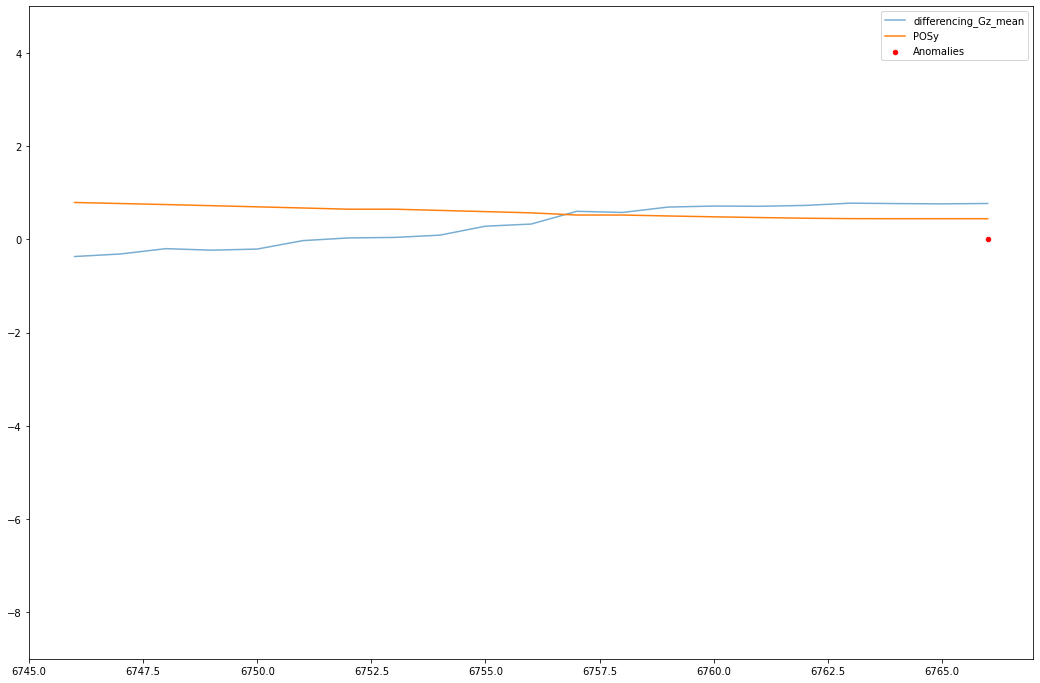

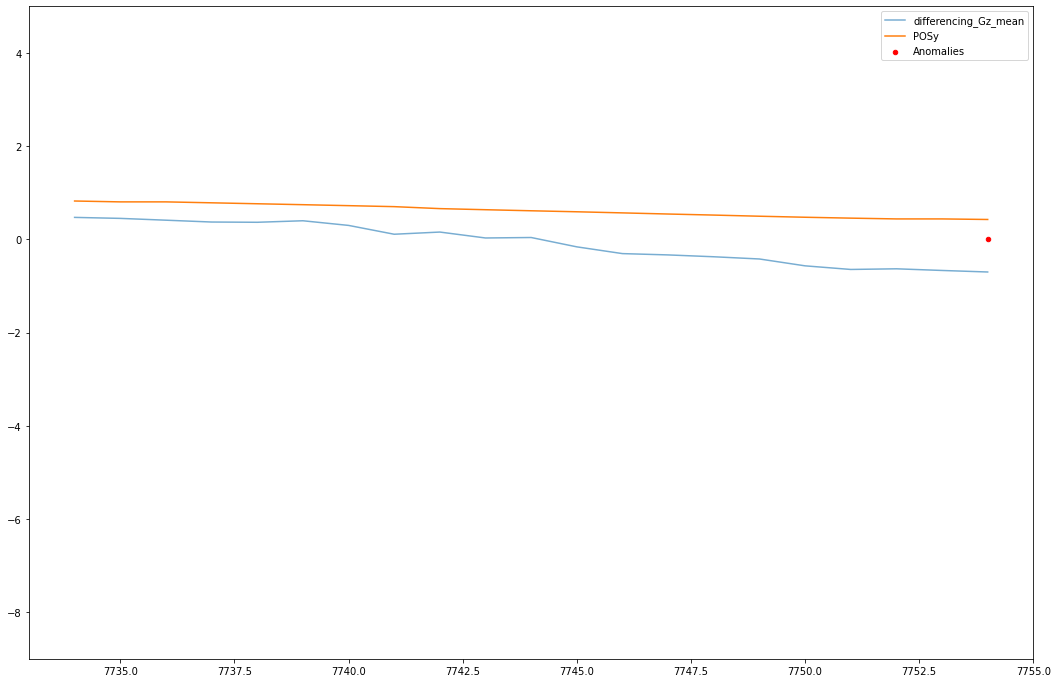

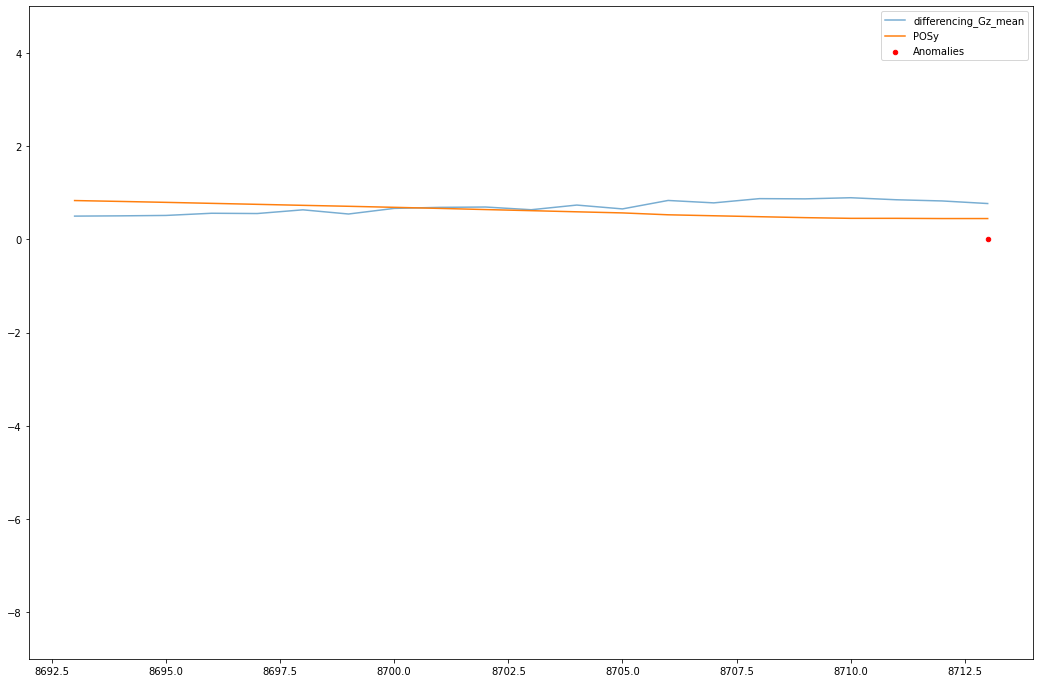

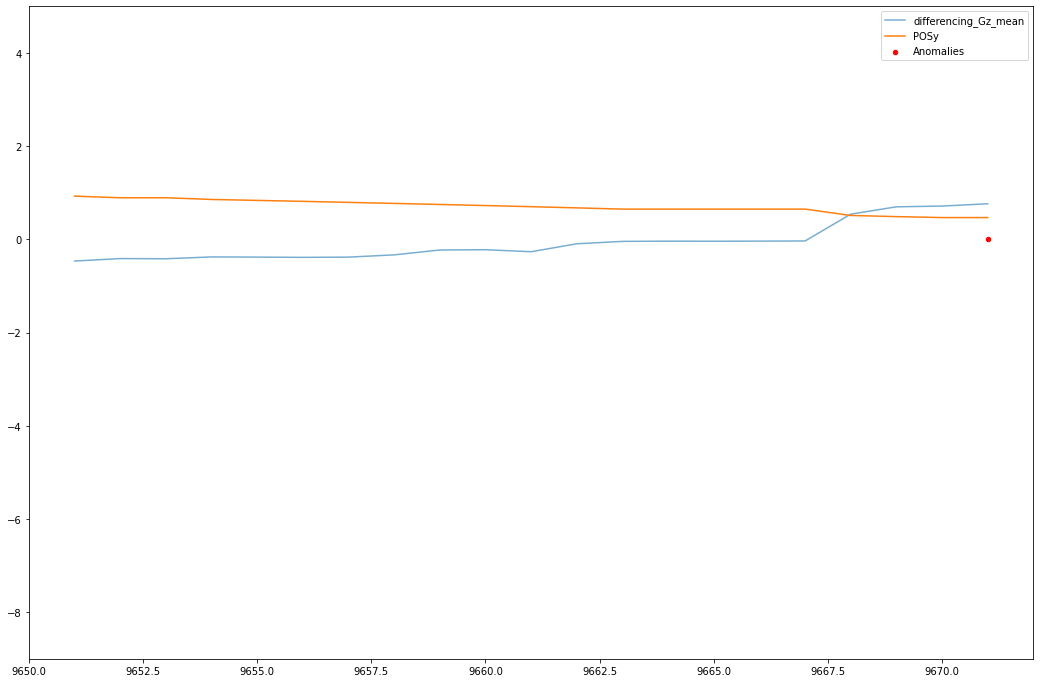

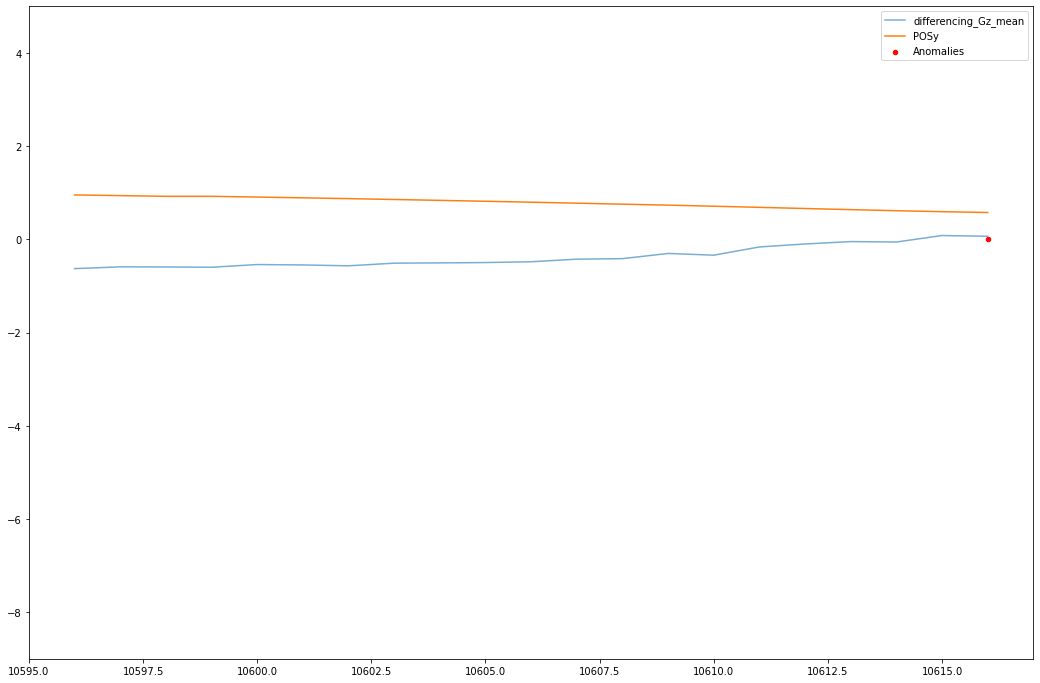

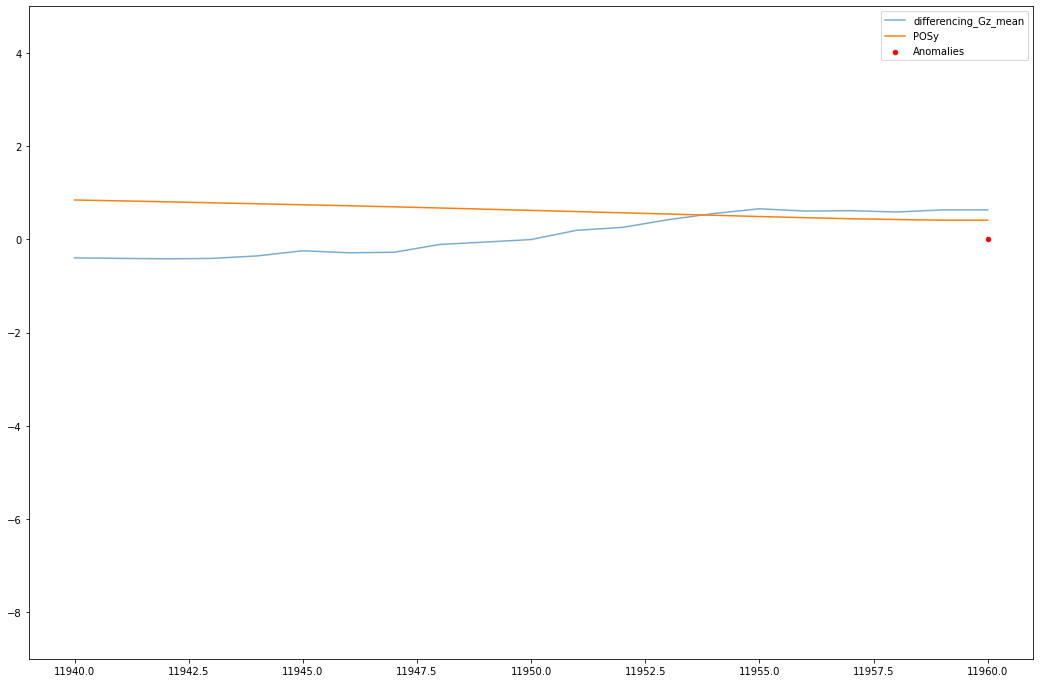

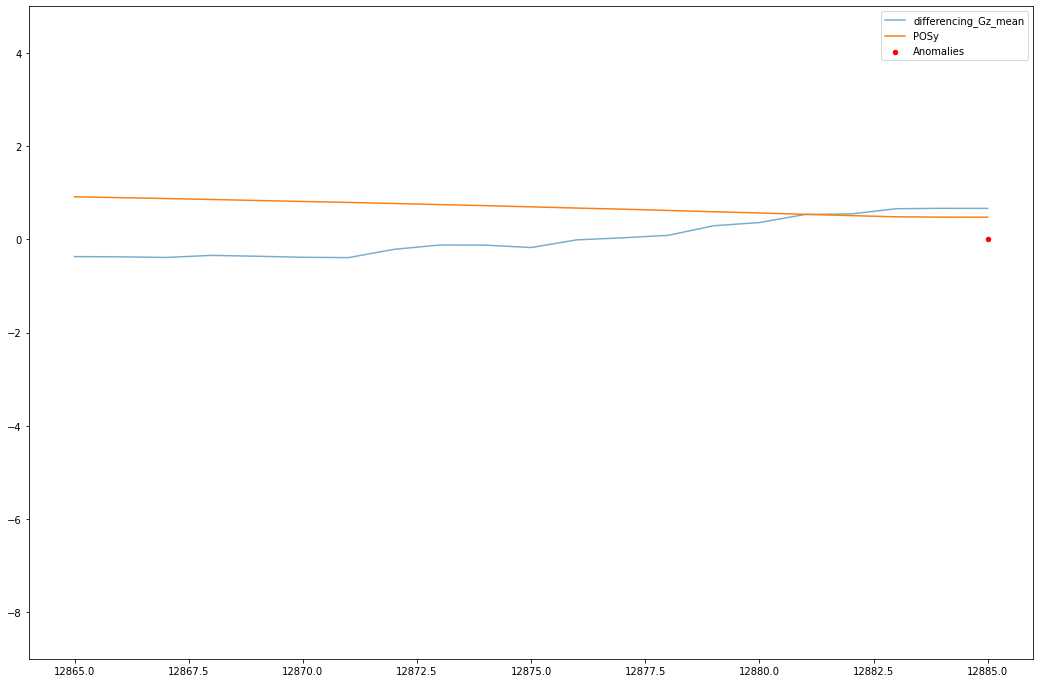

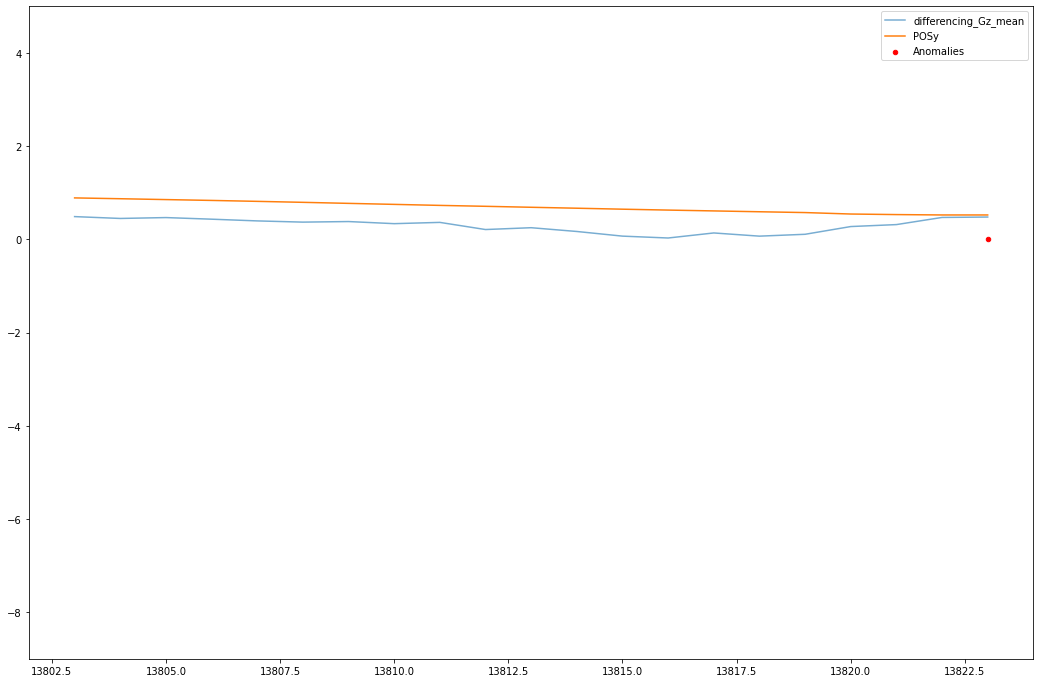

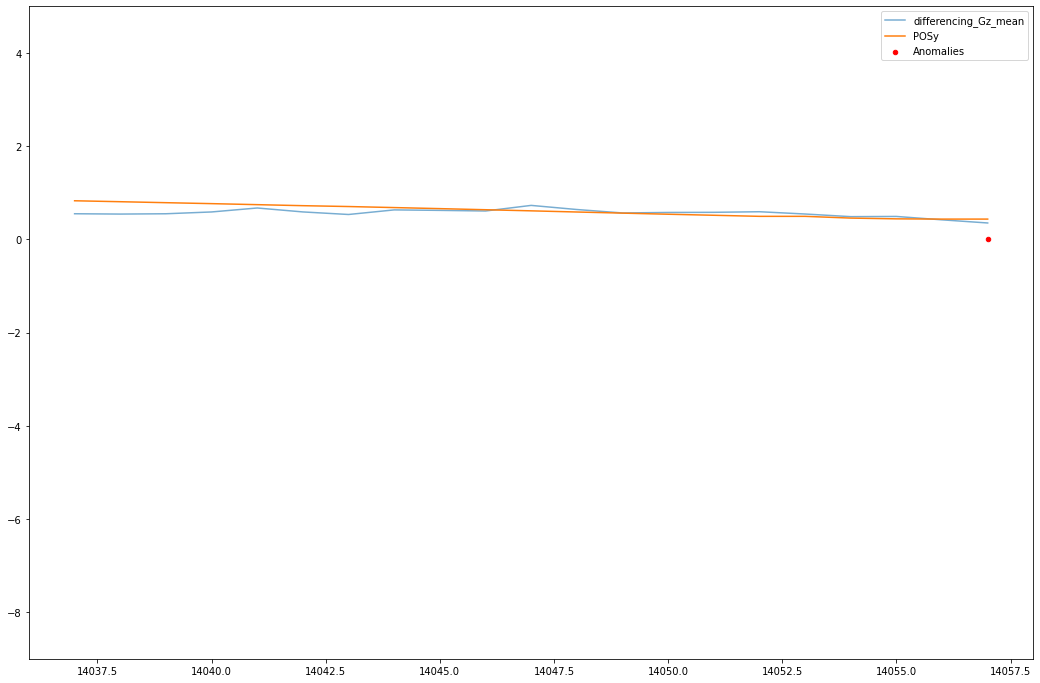

In [44]:
plot_only_faults(df, "differencing_Gz_mean")

# Machine learning

## Dataset preprocessing for machine learning models

In this section, RUL labels are converted to binary labels (`0/1`, namely `not_fault/fault`) in order to perform RUL classification instead of RUL regression.

In [45]:
training_columns = ["differencing_Gz_mean", "differencing_Ax_mean", 
                    "differencing_Ay_mean", "label"]

We will prepare the training, validation and test set with the following function.

In [46]:
def build_dataset_for_ml_model(df, split_size=0.75, as_list=False, ae=False):
    dfs = []
    df_main = df[training_columns]
    fault_indexes = df_main.index[df_main["label"] == 0].tolist() # list of indexes representing faults
    good_samples_thr = margin * 2
    
    previous = 0
    for fi in fault_indexes:
        dfs.append(df_main.iloc[previous:fi+1, :])
        previous = fi + 1
    
    rnd_list = list(range(len(dfs)))
    # Disable the following istruction if you want to compare different models on same test data
    # random.shuffle(rnd_list) 
    
    # If split_size is 1, there will be no val/test set
    train_size = floor(len(dfs) * split_size)
    train_index = rnd_list[:train_size]
    test_index = rnd_list[train_size:]
    train_rul = []
    test_rul = []
    
    if not as_list:
        first = True
        for ti in train_index:
            if not ae:
                to_concat = dfs[ti].copy()
            else:
                to_concat = dfs[ti][dfs[ti]["label"] >= good_samples_thr].copy()
            if first:
                training_set = to_concat
                first = False
            else:
                training_set = pd.concat([training_set, to_concat])

        first = True
        for ti in test_index:
            to_concat = dfs[ti].copy()
            if first:
                test_set = to_concat
                first = False
            else:
                test_set = pd.concat([test_set, to_concat])
        
        train_rul = training_set['label'].tolist()
        if split_size < 1:
            test_rul = test_set['label'].tolist()
        
        training_set['label'] = (training_set['label'] >= margin).map({True: 1, False: 0})
        if split_size < 1:
            test_set['label'] = (test_set['label'] >= margin).map({True: 1, False: 0})

        training_set = training_set.to_numpy()
        if split_size < 1:
            test_set = test_set.to_numpy()
        
    else:
        first = True
        for ti in train_index:
            if not ae:
                to_concat = dfs[ti].copy()
            else:
                to_concat = dfs[ti][dfs[ti]["label"] >= good_samples_thr].copy()
            if first:
                training_set = [to_concat]
                first = False
            else:
                training_set.append(to_concat)
                
        first = True
        for ti in test_index:
            to_concat = dfs[ti].copy()
            if first:
                test_set = [to_concat]
                first = False
            else:
                test_set.append(to_concat)
        
        for t in training_set:
            train_rul = train_rul + t['label'].tolist()
            t['label'] = (t['label'] >= margin).map({True: 1, False: 0})
        if split_size < 1:
            for t in test_set:
                test_rul = test_rul + t['label'].tolist()
                t['label'] = (t['label'] >= margin).map({True: 1, False: 0})
    if split_size < 1:
        return training_set, test_set
    return training_set

## Cost model for threshold optimization and performance evaluation

In general ML models, such as Logistic Neural Networks, predict as output a continuous value, such as a sigmoidal output between 0 and 1. Hence, it is necessary to determine a threshold for the classification of a fault. This process goes under the name of "Threshold Optimization", and it is basically an iterative procedure, testing over a set of possible good threshold.

The threshold optimization process involves same arguments, such as the cost for false positive (false alarms) and false negative (missed faults). For the moment, we will keep these values constant.

In the following 2 lists we will collect the performance of the ML models over the validation (`all_perf`) and test set (`all_perf_test`).

In [47]:
all_perf = [] 

In [48]:
all_perf_test = []

In [49]:
BASE_FP = 0.2
BASE_FN = 1

def false_positive_cost(i, is_fault, fault_found):
    return BASE_FP

def false_negative_cost(i, is_fault, fault_found):
    if not fault_found:
        for j in range(1, margin + 1):
            if i + j < is_fault.shape[0] and not is_fault[i + j] or i + j >= is_fault.shape[0]:
                return (margin + 1 - j) * BASE_FN
    else:
        return 0

In [50]:
def threshold_optimization(signal, rul, start, end, n_steps):
    best_cost = sys.maxsize
    best_thr = -1
    all_cost = []
    all_thr = []
    is_fault = (rul == 0)
    
    for thr in np.linspace(start, end, n_steps):
        tmp_cost = 0
        fault_found = False
        for i in range(signal.shape[0]):
            if is_fault[i] and signal[i] >= thr:
                fault_found = True
            if not is_fault[i]:
                fault_found = False
            if not is_fault[i] and signal[i] >= thr:
                tmp_cost += false_positive_cost(i, is_fault, fault_found)
            elif is_fault[i] and signal[i] <= thr:
                tmp_cost += false_negative_cost(i, is_fault, fault_found)
        if tmp_cost < best_cost:
            best_thr = thr
            best_cost = tmp_cost
        all_cost.append(tmp_cost)
        all_thr.append(thr)
        
    print(f'Best threshold: {best_thr:.3f}, best cost = {best_cost:.3f}')

    return best_cost, best_thr, all_cost, all_thr

In [51]:
def plot_threshold(signal, thr, rul):

    plt.plot(signal, alpha=0.5)
    plt.plot(range(len(signal)), [thr] * len(signal))

    ranges = []
    signal_values = []
    for i in range(len(rul)):
        if rul[i] == 0:
            ranges.append(i)
            signal_values.append(signal[i])

    plt.scatter(ranges, signal_values, color="red", s=10)
    
    plt.ylabel('Alarm signal intensity')
    plt.xlabel('Time')
    plt.legend(['Alarm signal', "Threshold", 'Anomalies'], loc='upper right')
    plt.show()
    plt.show()

In [52]:
def performance_evaluation(signal, thr, rul):
    fp, fn, tp, tot_p = 0, 0, 0, 0
    cost = 0
    alarm = (signal >= thr)
    anticipation = []
    is_fault = (rul == 0)
    
    fault_found = False
    for i in range(len(rul)):
        if i > 0 and is_fault[i] and not is_fault[i - 1]:
            tot_p += 1
            start = i
        if is_fault[i] and not fault_found and alarm[i]:
            tp += 1
            fault_found = True
            anticipation.append((margin - 1) - (i - start))
        if (i < len(rul) - 1 and is_fault[i] and not is_fault[i + 1] and not fault_found) or (i == len(rul) - 1 and not fault_found):
            fn += 1 
        if is_fault[i] and signal[i] <= thr:
            cost += false_negative_cost(i, is_fault, fault_found)
        if not is_fault[i]:
            fault_found = False
            if alarm[i]:
                fp += 1
                cost += false_positive_cost(i, is_fault, fault_found)
        
    print(f'The total cost of the model is {cost:.3f}')
    print(f'Detected {tp} faults over {tot_p}, missed faults: {fn}. False alarm: {fp}')
    print(f'Faults detected with an anticipation of:')
    for a in anticipation:
        a = a / 10
        print(f' - {a:.1f}s')
    tot_a = sum(anticipation) / 10
    if sum(anticipation) > 0:
        mean_a = mean(anticipation) / 10
    else:
        mean_a = 0
    print(f'The mean anticipation is {mean_a:.2f}s. Total amount of anticipation is {tot_a:.1f}s')
    
    return [cost, mean_a, tp, fn, fp]

## RUL estimation with pre-trained Logistic Neural Network

A logistic neural network outputs whether a sample is faulty or not independently from the history, by just looking at the current features.

#### Load models

In [53]:
lin_cl = keras.models.load_model('models/lin_cl.bin')
    
with open('threshold/lin_cl.bin', 'rb') as handle:
    best_thr_lin_cl = pickle.load(handle)

#### Evaluation of pre-trained neural network

We will now evaluate the results of a pre-trained neural network on the dataset that we have just collected.

In [54]:
test_set_lin = build_dataset_for_ml_model(df, split_size=1)

In [55]:
test_preds_lin = lin_cl.predict(test_set_lin[:, :-1]).ravel()

In [56]:
test_signal_lin_cl = pd.Series(data=(1 - test_preds_lin))
test_rul_lin_cl = test_set_lin[:, -1]

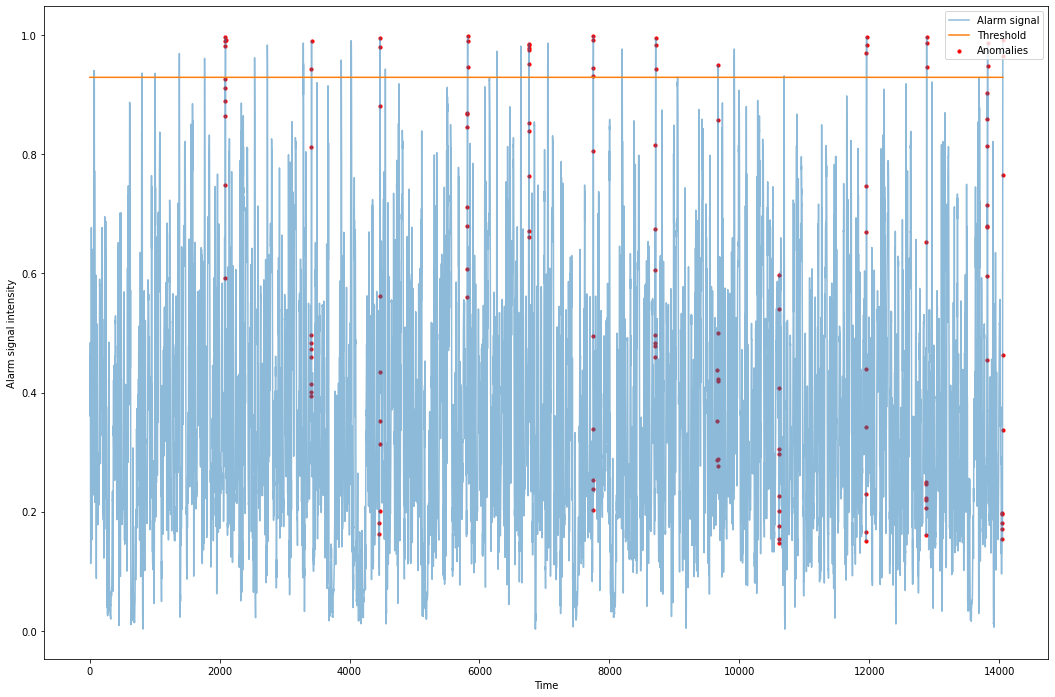

In [57]:
plot_threshold(test_signal_lin_cl, best_thr_lin_cl, test_rul_lin_cl)

In [58]:
test_perf_lin_cl = performance_evaluation(test_signal_lin_cl, best_thr_lin_cl, test_rul_lin_cl)

The total cost of the model is 424.600
Detected 12 faults over 13, missed faults: 1. False alarm: 58
Faults detected with an anticipation of:
 - 0.3s
 - 0.1s
 - 0.1s
 - 0.2s
 - 0.4s
 - 0.3s
 - 0.2s
 - 0.0s
 - 0.2s
 - 0.2s
 - 0.1s
 - 0.1s
The mean anticipation is 0.18s. Total amount of anticipation is 2.2s


In [59]:
all_perf_test.append(["logistic_nn_loaded"] + test_perf_lin_cl)

#### Analysis over the test set

In [60]:
pd.DataFrame(all_perf_test, columns=["model", "cost", "anticipation", "detected_faults", "missed_faults", "false_alarms"]) 

model     cost  anticipation  detected_faults  missed_faults  \
0  logistic_nn_loaded 424.6000        0.1833               12              1   

   false_alarms  
0            58

## Training a Neural Network from scratch

Now you are ready to train a new model from scratch! 

We will import some data collected in a few hours of experiments and process them as we did before.

#### Paths

In [61]:
f_acc_train = r'train_data/dataset_acc.csv'
f_pos_train = r'train_data/dataset_pos.csv'
f_labels_train = r'train_data/labels.csv'

#### Import data

In [62]:
acc_df_train = pd.read_csv(f_acc_train, names=col_acc)
pos_df_train = pd.read_csv(f_pos_train, names=col_pos)
lab_df_train = pd.read_csv(f_labels_train, names=col_lab)

In [63]:
merged_data_train, _ = merge_data(acc_df_train, pos_df_train, lab_df_train)

The 1° lap lasts for approx. 97.0 seconds
The 2° lap lasts for approx. 209.9 seconds
The 3° lap lasts for approx. 168.6 seconds
The 4° lap lasts for approx. 100.3 seconds
The 5° lap lasts for approx. 96.7 seconds
The 6° lap lasts for approx. 170.4 seconds
The 7° lap lasts for approx. 207.1 seconds
The 8° lap lasts for approx. 61.0 seconds
The 9° lap lasts for approx. 62.4 seconds
The 10° lap lasts for approx. 101.8 seconds
The 11° lap lasts for approx. 209.1 seconds
The 12° lap lasts for approx. 133.9 seconds
The 13° lap lasts for approx. 137.9 seconds
The 14° lap lasts for approx. 133.1 seconds
The 15° lap lasts for approx. 71.5 seconds
The 16° lap lasts for approx. 98.0 seconds
The 17° lap lasts for approx. 136.2 seconds
The 18° lap lasts for approx. 135.4 seconds
The 19° lap lasts for approx. 176.2 seconds
The 20° lap lasts for approx. 60.2 seconds
The 21° lap lasts for approx. 100.8 seconds
The 22° lap lasts for approx. 105.6 seconds
The 23° lap lasts for approx. 176.3 seconds
The 

#### Data processing

In [64]:
raw_df_train = pd.DataFrame(merged_data_train, columns=col_acc+["time_server_pos"]+col_pos[1:]+["label"])
raw_df_reduced_train = raw_df_train[useful_columns_raw]

df_split_train = []
fault_indexes_train = raw_df_reduced_train.index[raw_df_reduced_train["label"] == 0].tolist() # list of indexes representing faults
        
previous = 0
for fi in fault_indexes_train:
    df_split_train.append(raw_df_reduced_train.iloc[previous:fi+1, :])
    previous = fi + 1

print(f'There are {len(df_split_train)} faults, hence {len(df_split_train)} datasets.')
for i, df_tmp in enumerate(df_split_train):
    print(i, df_tmp.shape)

There are 28 faults, hence 28 datasets.
0 (970, 7)
1 (2099, 7)
2 (1686, 7)
3 (1003, 7)
4 (967, 7)
5 (1704, 7)
6 (2071, 7)
7 (610, 7)
8 (624, 7)
9 (1018, 7)
10 (2091, 7)
11 (1339, 7)
12 (1379, 7)
13 (1331, 7)
14 (715, 7)
15 (980, 7)
16 (1362, 7)
17 (1354, 7)
18 (1762, 7)
19 (602, 7)
20 (1008, 7)
21 (1056, 7)
22 (1763, 7)
23 (605, 7)
24 (951, 7)
25 (428, 7)
26 (727, 7)
27 (1657, 7)


#### Feature Creation

In [65]:
new_dfs_train = []

for temps in df_split_train:
    
    means = temps.rolling(w_len).mean()
    means.columns = [t + "_mean" for t in temps.columns]
    
    mins = temps.rolling(w_len).min()
    mins.columns = [t + "_min" for t in temps.columns]
    
    maxs = temps.rolling(w_len).max()
    maxs.columns = [t + "_max" for t in temps.columns]
    
    temps_diff = temps - temps.shift(1)
    temps_diff.columns = [t + "_diff" for t in temps.columns]
    
    df_with_nan = pd.concat([temps, means, mins, maxs, temps_diff], axis=1)
    df_curr = df_with_nan.dropna()
    
    new_dfs_train.append(df_curr)
    
df_new_features_train = new_dfs_train[0]
for to_concat in new_dfs_train[1:]:
    df_new_features_train = pd.concat([df_new_features_train, to_concat])

df_new_features_train = df_new_features_train[new_features]
df_new_features_train = df_new_features_train.reset_index(drop=True)

#### Handling seasonality with differencing over position and orientation

In [66]:
df_new_features_train["orient_discr"] = pd.Series([1 if (orient > -45 and orient < 45) 
                                                  else -1 if (orient < -135 or orient > 135) 
                                                  else 0 for orient in df_new_features_train["orient"]])
df_new_features_train["POSy_discr"] = pd.Series([find_nearest(fixed_pos, curr_pos, return_index=False) 
                                                for curr_pos in df_new_features_train["POSy"]])

Ax_differencing_dict_train = {}
Ay_differencing_dict_train = {}
Gz_differencing_dict_train = {}
count_dict_train = {}
differencing_list_Ax_train = []
differencing_list_Ay_train = []
differencing_list_Gz_train = []

for _, row in df_new_features_train.iterrows():
    if row["label"] >= margin:
        keys = (row["orient_discr"], row["POSy_discr"])
        if keys not in Ax_differencing_dict_train:
            Ax_differencing_dict_train[keys] = row["Ax_mean"]
            Ay_differencing_dict_train[keys] = row["Ay_mean"]
            Gz_differencing_dict_train[keys] = row["Gz_mean"]
            count_dict_train[keys] = 1
        else:
            Ax_differencing_dict_train[keys] += row["Ax_mean"]
            Ay_differencing_dict_train[keys] += row["Ay_mean"]
            Gz_differencing_dict_train[keys] += row["Gz_mean"]
            count_dict_train[keys] += 1
        
for keys in Ax_differencing_dict_train:
    Ax_differencing_dict_train[keys] = Ax_differencing_dict_train[keys] / count_dict_train[keys]
    Ay_differencing_dict_train[keys] = Ay_differencing_dict_train[keys] / count_dict_train[keys]
    Gz_differencing_dict_train[keys] = Gz_differencing_dict_train[keys] / count_dict_train[keys]
    
for _, row in df_new_features_train.iterrows():
    keys = (row["orient_discr"], row["POSy_discr"])
    differencing_list_Ax_train.append(row["Ax_mean"] - Ax_differencing_dict_train[keys])
    differencing_list_Ay_train.append(row["Ay_mean"] - Ay_differencing_dict_train[keys])
    differencing_list_Gz_train.append(row["Gz_mean"] - Gz_differencing_dict_train[keys])
    
df_new_features_train["differencing_Ax_mean"] = pd.Series(differencing_list_Ax_train)
df_new_features_train["differencing_Ay_mean"] = pd.Series(differencing_list_Ay_train)
df_new_features_train["differencing_Gz_mean"] = pd.Series(differencing_list_Gz_train)

#### Feature scaling

In [67]:
scaler_train = StandardScaler()
df_train = pd.DataFrame(scaler_train.fit_transform(df_new_features_train), 
                       columns=list(df_new_features_train.columns))
df_train = df_train.drop(columns=["label", 'orient_discr','POSy_discr'])
df_train["orient_discr"] = df_new_features_train["orient_discr"]
df_train["POSy_discr"] = df_new_features_train["POSy_discr"]
df_train["label"] = df_new_features_train["label"]
df_train.head()

Gz      Ax      Ay  Gz_mean  Ax_mean  Ay_mean  Gz_min  Ax_min  Ay_min  \
0 -0.6282 -0.1351 -0.2329  -0.7442   1.2804   1.1006 -0.4221  0.8635  1.0306   
1 -0.6079  1.1653  0.4926  -0.7306   1.3201   1.0493 -0.4221  0.8635  1.0306   
2 -0.5917  1.4625  0.5144  -0.7158   1.4003   1.2590 -0.4221  0.8635  1.2123   
3 -0.5632 -0.0590  0.9757  -0.6954   1.2243   1.4664 -0.4055  0.8635  1.2123   
4  0.5498  0.2192  0.6788  -0.5616   1.2194   1.4140 -0.4055  0.8635  1.2123   

   Gz_max  ...  Ay_diff    POSx    POSy  orient  differencing_Ax_mean  \
0 -0.9778  ...  -0.0609 -0.3129 -1.2136 -0.1270                0.3449   
1 -0.9572  ...   0.5677 -0.3348 -1.1995 -0.1294                0.4098   
2 -0.9408  ...   0.0172 -0.3585 -1.1849 -0.1316                0.5824   
3 -0.9119  ...   0.3611 -0.3841 -1.1696 -0.1337                0.2945   
4  0.2165  ...  -0.2320 -0.3881 -1.1560 -0.1336                0.3242   

   differencing_Ay_mean  differencing_Gz_mean  orient_discr  POSy_discr  label  
0                1.0756               -0.0996             1     20.6000    960  
1                1.0222               -0.0826             1     20.6000    959  
2                1.1887               -0.0896             1     20.7000    958  
3                1.4046               -0.0642             1     20.7000    957  
4                1.3965                0.0672             1     20.8000    956  

[5 rows x 24 columns]

#### Machine Learning

The data are now ready, we will now instantiate several classifiers with the `build_classifier` function.

As an exercise, try to use some hidden units or to change the activation function of the neural network.

In [68]:
training_set_nn, validation_set_nn = build_dataset_for_ml_model(df_train)

In [69]:
def build_classifier(input_size, hidden, activation='relu'):
    input_shape = (input_size,)
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation=activation)(x)
    model_out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(model_in, model_out)
    return model

In [70]:
# Plot train loss and validation loss
def plot_loss(history, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
    plt.show()

**Class weights** are useful when you have an **unbalanced dataset** and you want to improve single-label classification results. With class weights, you can weight more the samples belonging to the rarest class.

In [71]:
counts_nn = pd.Series(training_set_nn[:, -1]).value_counts(normalize=True)
class_weight_nn = {0: 1/counts_nn[0], 1: 1/counts_nn[1]}
class_weight_nn

{0: 126.12380952380953, 1: 1.007992084031055}

In [72]:
input_size_nn = training_set_nn.shape[1] - 1

#### Model definition

Here we build the model and compile it, meaning we assign to it an optimizer and a loss function.

In [73]:
lin_cl = build_classifier(input_size=input_size_nn, hidden=[])
lin_cl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [74]:
lin_cl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
               loss='binary_crossentropy')

#### Training

In the training process there are other hyper-parameters, such as the batch size and the number of epochs. Can you identify the tradeoff that those involve?

In [75]:
cb_lin = [callbacks.EarlyStopping(patience=30, restore_best_weights=True)]
history_lin_cl = lin_cl.fit(training_set_nn[:, :-1], training_set_nn[:, -1], validation_split=0.2,
                            callbacks=cb_lin, class_weight=class_weight_nn,
                            batch_size=32, epochs=1000, verbose=1)

Epoch 1/1000
663/663 [==============================] - 2s 2ms/step - loss: 2.0241 - val_loss: 0.8984
Epoch 2/1000
663/663 [==============================] - 1s 2ms/step - loss: 1.6438 - val_loss: 0.9148
Epoch 3/1000
663/663 [==============================] - 2s 2ms/step - loss: 1.3976 - val_loss: 0.9115
Epoch 4/1000
663/663 [==============================] - 2s 3ms/step - loss: 1.2521 - val_loss: 0.8860
Epoch 5/1000
663/663 [==============================] - 2s 3ms/step - loss: 1.1671 - val_loss: 0.8526
Epoch 6/1000
663/663 [==============================] - 2s 3ms/step - loss: 1.1121 - val_loss: 0.8177
Epoch 7/1000
663/663 [==============================] - 1s 2ms/step - loss: 1.0738 - val_loss: 0.7848
Epoch 8/1000
663/663 [==============================] - 2s 2ms/step - loss: 1.0466 - val_loss: 0.7555
Epoch 9/1000
663/663 [==============================] - 2s 2ms/step - loss: 1.0275 - val_loss: 0.7324
Epoch 10/1000
663/663 [==============================] - 1s 2ms/step - loss: 1.014

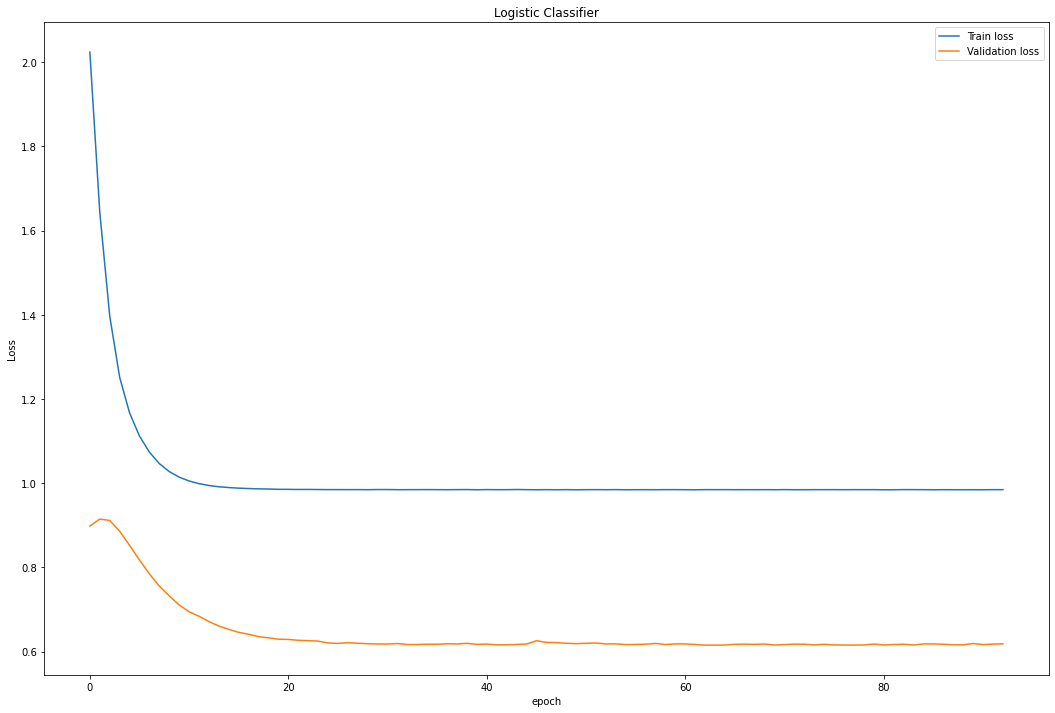

In [76]:
plot_loss(history_lin_cl, "Logistic Classifier")

#### Threshold optimization

In [77]:
preds_lin_cl = lin_cl.predict(validation_set_nn[:, :-1]).ravel()

In [78]:
signal_lin_cl = pd.Series(data=(1 - preds_lin_cl))
rul_lin_cl = validation_set_nn[:, -1]

best_cost_lin_cl, best_thr_lin_cl, all_cost_lin_cl, all_thr_lin_cl = threshold_optimization(signal_lin_cl, rul_lin_cl, start=0, end=signal_lin_cl.max(), n_steps=200)

Best threshold: 0.959, best cost = 262.000


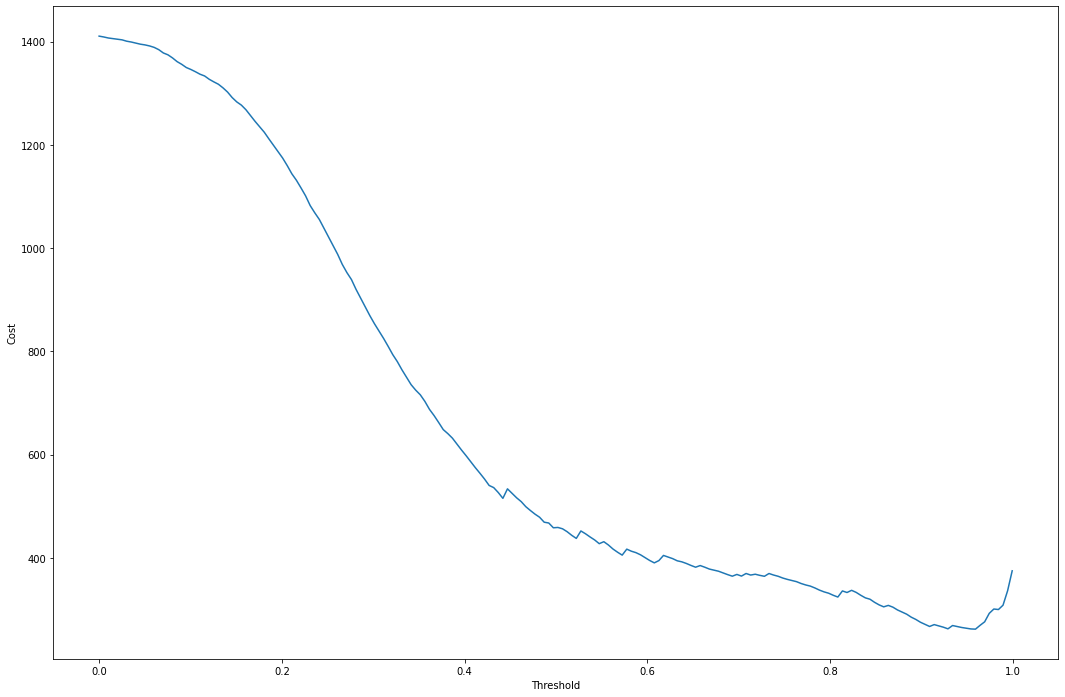

In [79]:
plt.xlabel('Threshold')
plt.ylabel('Cost')
plt.plot(all_thr_lin_cl, all_cost_lin_cl)
plt.show()

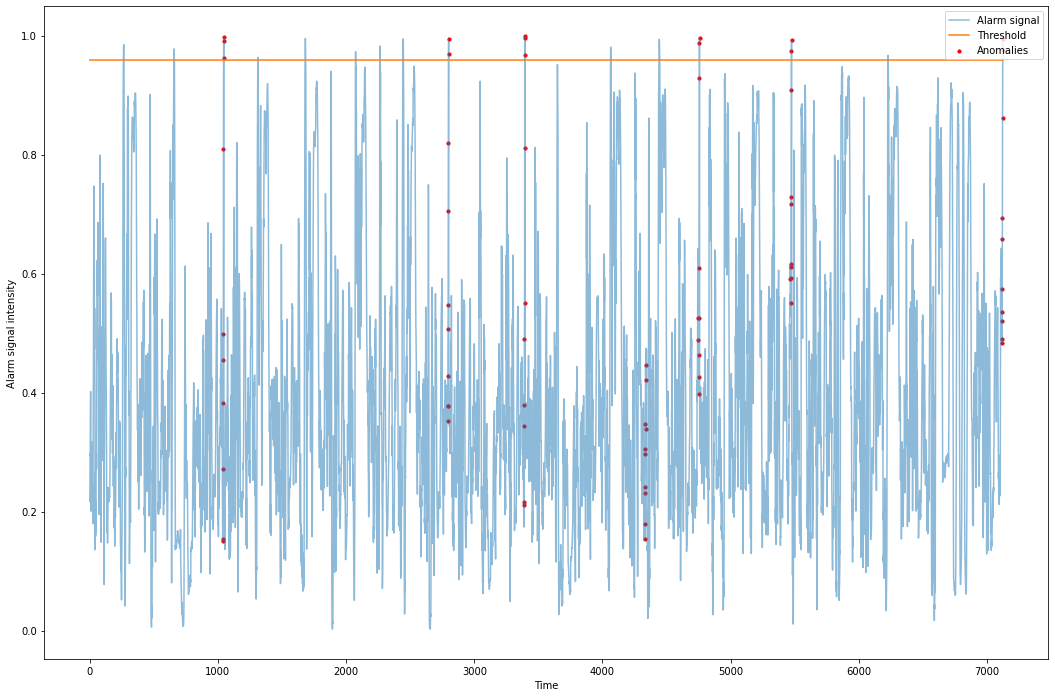

In [80]:
plot_threshold(signal_lin_cl, best_thr_lin_cl, rul_lin_cl)

In [81]:
perf_lin_cl = performance_evaluation(signal_lin_cl, best_thr_lin_cl, rul_lin_cl)

The total cost of the model is 262.000
Detected 6 faults over 7, missed faults: 1. False alarm: 35
Faults detected with an anticipation of:
 - 0.2s
 - 0.1s
 - 0.2s
 - 0.1s
 - 0.1s
 - 0.1s
The mean anticipation is 0.13s. Total amount of anticipation is 0.8s


In [82]:
all_perf.append(["logistic_nn"] + perf_lin_cl)

#### Analysis over the validation set

In [83]:
pd.DataFrame(all_perf, columns=["model", "cost", "anticipation", "detected_faults", "missed_faults", "false_alarms"]) 

model     cost  anticipation  detected_faults  missed_faults  \
0  logistic_nn 262.0000        0.1333                6              1   

   false_alarms  
0            35

#### Analysis over the test set

In [84]:
test_set_lin = build_dataset_for_ml_model(df, split_size=1)

In [85]:
test_preds_lin = lin_cl.predict(test_set_lin[:, :-1]).ravel()

In [86]:
test_signal_lin_cl = pd.Series(data=(1 - test_preds_lin))
test_rul_lin_cl = test_set_lin[:, -1]

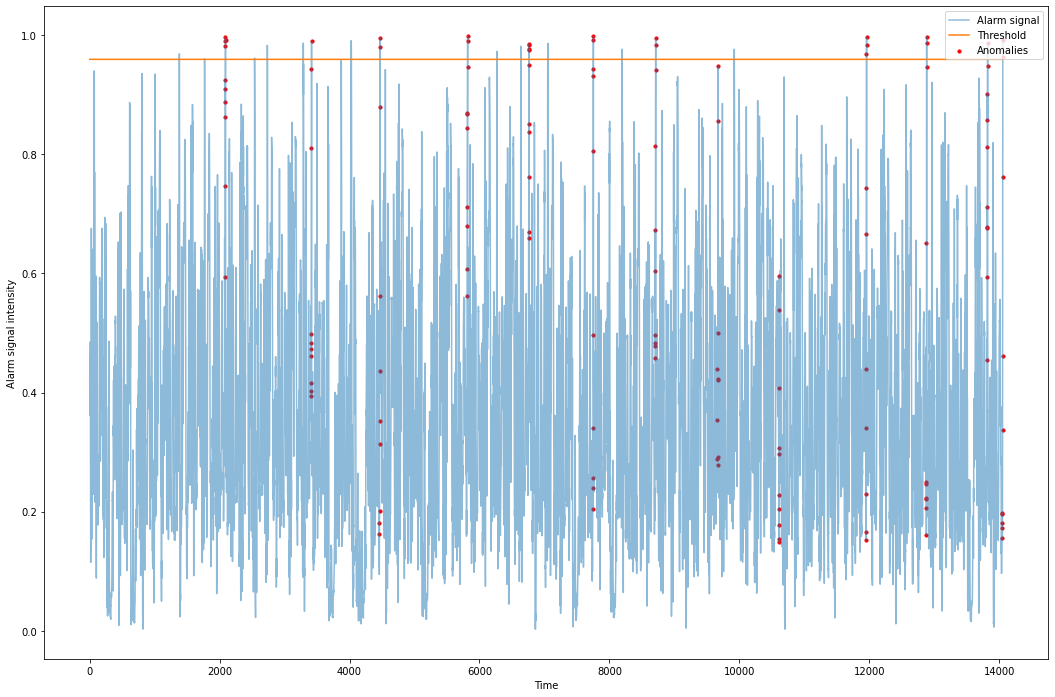

In [87]:
plot_threshold(test_signal_lin_cl, best_thr_lin_cl, test_rul_lin_cl)

In [88]:
test_perf_lin_cl = performance_evaluation(test_signal_lin_cl, best_thr_lin_cl, test_rul_lin_cl)

The total cost of the model is 491.600
Detected 11 faults over 13, missed faults: 2. False alarm: 28
Faults detected with an anticipation of:
 - 0.3s
 - 0.0s
 - 0.1s
 - 0.1s
 - 0.3s
 - 0.1s
 - 0.1s
 - 0.2s
 - 0.1s
 - 0.0s
 - 0.1s
The mean anticipation is 0.13s. Total amount of anticipation is 1.4s


In [89]:
all_perf_test.append(["logistic_nn"] + test_perf_lin_cl)

In [90]:
pd.DataFrame(all_perf_test, columns=["model", "cost", "anticipation", "detected_faults", "missed_faults", "false_alarms"]) 

model     cost  anticipation  detected_faults  missed_faults  \
0  logistic_nn_loaded 424.6000        0.1833               12              1   
1         logistic_nn 491.6000        0.1273               11              2   

   false_alarms  
0            58  
1            28